### Deep Kung-Fu with advantage actor-critic

In this notebook you'll build a deep reinforcement learning agent for atari [KungFuMaster](https://gym.openai.com/envs/KungFuMaster-v0/) and train it with advantage actor-critic.

![http://www.retroland.com/wp-content/uploads/2011/07/King-Fu-Master.jpg](http://www.retroland.com/wp-content/uploads/2011/07/King-Fu-Master.jpg)

In [1]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [2]:
import atari_util

For starters, let's take a look at the game itself:
* Image resized to 42x42 and grayscale to run faster
* Rewards divided by 100 'cuz they are all divisible by 100
* Agent sees last 4 frames of game to account for object velocity

In [3]:
import gym
import atari_util
import utils
def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    
    env = atari_util.PrimaryAtariWrap(env, 
                                      clip_rewards=False,
                                      frame_skip=False,
                                      width=64, 
                                      height=64, 
                                      margins=[95,8,1,40], 
                                      n_frames=4,
                                      reward_scale=0.01)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
# print("Action names:", env.env.env.get_action_meanings())

Observation shape: (4, 64, 64)
Num actions: 14


D:\Tools\Python\Anaconda\lib\site-packages\gym\logger.py:30: UserWarning: WARN: <class 'atari_wrappers.RewardScale'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


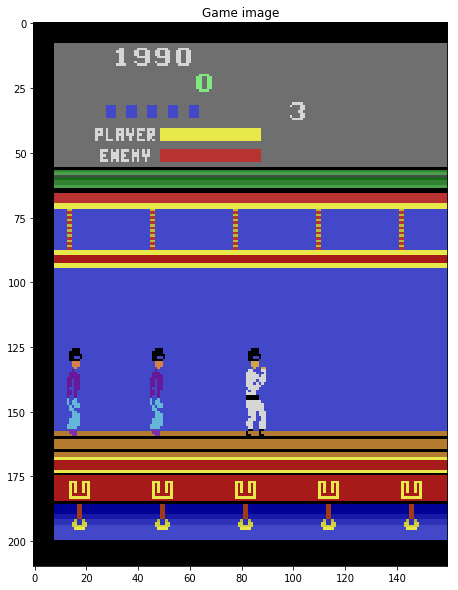

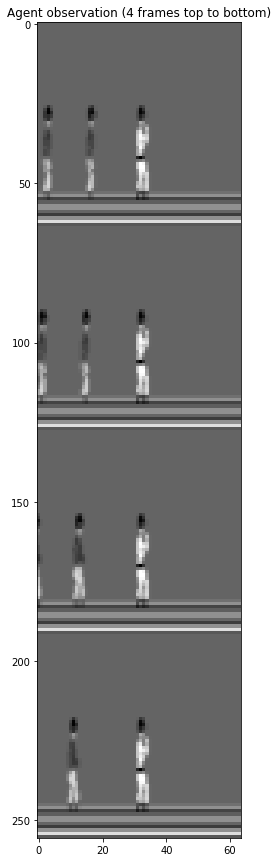

In [4]:
s = env.reset()
for _ in range(100):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, obs_shape), cmap='gray')
plt.show()

### Build an agent

We now have to build an agent for actor-critic training - a convolutional neural network that converts states into action probabilities $\pi$ and state values $V$.

Your assignment here is to build and apply a neural network - with any framework you want. 

For starters, we want you to implement this architecture:
![https://s17.postimg.org/orswlfzcv/nnet_arch.png](https://s17.postimg.org/orswlfzcv/nnet_arch.png)

After you get above 50 points, we encourage you to experiment with model architecture to score even better.

In [4]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device=torch.device('cpu')

In [5]:
def conv2d_size_out(size, kernel_size=3, stride=2):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride + 1


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)


In [6]:
class Agent(nn.Module):
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        super(Agent, self).__init__()

        # Prepare neural network architecture
        ### Your code here: prepare any necessary layers, variables, etc.
        self.n_actions = n_actions
        self.state_shape = state_shape
        print(state_shape)
        c, h, w = state_shape
        
        self.common = nn.Sequential(
        nn.Conv2d(state_shape[0], 32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, stride=2),
        nn.ReLU(),
        Flatten())
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        # we want to flatten given images to verctor for dense layers.
        self.fc = nn.Sequential(
            nn.Linear(linear_input_size, 128),
            nn.ReLU()
        )
        self.Vs = nn.Linear(128, 1)
        self.logits = nn.Linear(128, n_actions)
    
    def forward(self, state_t):
        """
        Takes agent's previous step and observation, 
        returns next state and whatever it needs to learn (tf tensors)
        """
        # Apply neural network
        ### Your code here: apply agent's neural network to get policy logits and state values.
        state_t = self.common(state_t)
        state_t = self.fc(state_t)
        logits = self.logits(state_t)
        state_value = self.Vs(state_t)[:, 0]
        
        assert torch.is_tensor(state_value) and len(state_value.shape) == 1, \
            "please return 1D torch tensor of state values [you got %s]" % repr(state_value)
        assert torch.is_tensor(logits) \
            and len(logits.shape) == 2 \
            and logits.shape[0] == logits.shape[0] \
            and logits.shape[1] == n_actions, \
            "please return 2d tf tensor of logits [you got %s]" % repr(logits)
        # hint: if you triggered state_values assert with your shape being [None, 1], 
        # just select [:, 0]-th element of state values as new state values
        
        return logits, state_value
      
     
    def step(self, state_t):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        state_t = torch.tensor(state_t, device=model_device, dtype=torch.float)
        logits, state_value = self.forward(state_t)
        
        return logits.data.cpu().numpy(), state_value.data.cpu().numpy()
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [7]:
agent = Agent("agent", obs_shape, n_actions).to(device)

(4, 64, 64)


In [8]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[-0.07834003  0.04762375  0.02385109  0.08780253  0.02204554  0.04577139
  -0.04215956  0.06236473 -0.07735182 -0.06333277  0.00051016 -0.07680595
   0.00426527  0.0038794 ]]
state values:
 [0.03179021]


### Let's play!
Let's build a function that measures agent's average reward.

In [9]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards


In [10]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

[0.0, 0.0, 1.0]


In [11]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices



<video width="640" height="480" controls>
  <source src="./kungfu_videos/openaigym.video.0.1796.video000001.mp4" type="video/mp4">
</video>

### Training on parallel games
![img](https://s7.postimg.org/4y36s2b2z/env_pool.png)

To make actor-critic training more stable, we shall play several games in parallel. This means ya'll have to initialize several parallel gym envs, send agent's actions there and .reset() each env if it becomes terminated. To minimize learner brain damage, we've taken care of them for ya - just make sure you read it before you use it.


In [10]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

__Let's try it out:__

In [11]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])


State shape: (10, 4, 64, 64)
Actions: [ 1 11  2]
Rewards: [0. 0. 0.]
Done: [False False False]


# Actor-critic

Here we define a loss functions and learning algorithms as usual.

In [12]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [13]:
import torch.nn.functional as F
def compute_loss(states, actions, rewards, next_states, is_done, 
                 agent, device=device):
    """ Compute  loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    
    # logits[n_envs, n_actions] and state_values[n_envs, n_actions]
    logits, state_values = agent.forward(states)
    next_logits, next_state_values = agent.forward(next_states)
    next_state_values = next_state_values * (1 - is_done)
    is_not_done = 1 - is_done
    
    # probabilities and log-probabilities for all actions
    probs = F.softmax(logits)            # [n_envs, n_actions]
    logprobs = F.log_softmax(logits)     # [n_envs, n_actions]
    #  log-probabilities only for agent's chosen actions
    logp_actions = torch.sum(logprobs * to_one_hot(actions, env.action_space.n), dim=-1) # [n_envs,]
    
    # compute advantage using rewards_ph, state_values and next_state_values
    gamma = 0.99
    
    advantage = rewards + (gamma * next_state_values) - state_values
    assert len(advantage.shape) == 1, "please compute advantage for each sample, vector of shape [n_envs,]"
    # compute policy entropy given logits_seq. Mind the sign!
    entropy = -(probs * logprobs).sum(-1)
    assert len(entropy.shape) == 1, "please compute pointwise entropy vector of shape [n_envs,] "
    
    actor_loss = - torch.mean(logp_actions * advantage.detach()) - 0.001 * entropy.mean()
    
    # compute target state values using temporal difference formula. Use rewards_ph and next_step_values
    target_state_values = rewards + gamma * next_state_values * is_not_done
    
    critic_loss = torch.mean((state_values - target_state_values.detach())**2)
    
    return actor_loss + critic_loss, entropy



In [14]:
# Sanity checks to catch some errors. Specific to KungFuMaster in assignment's default setup.
loss, ent = compute_loss(batch_states, batch_actions, batch_rewards, batch_states, batch_done, 
                 agent, device=device)



assert abs(loss) < 200, "losses seem abnormally large"
assert 0 <= ent.mean() <= np.log(n_actions), "impossible entropy value, double-check the formula pls"
if ent.mean() < np.log(n_actions) / 2: print("Entropy is too low for untrained agent")
print("You just might be fine!")

You just might be fine!


D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Train 

Just the usual - play a bit, compute loss, follow the graidents, repeat a few million times.
![img](http://images6.fanpop.com/image/photos/38900000/Daniel-san-training-the-karate-kid-38947361-499-288.gif)

In [16]:
from IPython.display import clear_output
from tqdm import trange
import pandas as pd
env_batch = EnvBatch(10)
pd.DataFrame.ewm
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]

D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


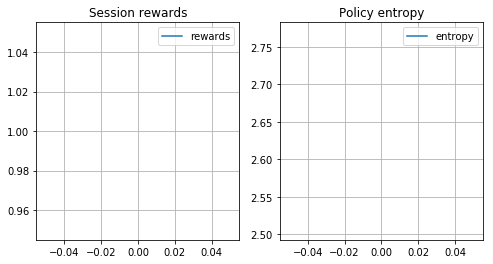

  0%|                                                                           | 1/100000 [00:10<303:24:23, 10.92s/it]

  0%|                                                                           | 2/100000 [00:11<213:20:24,  7.68s/it]

  0%|                                                                           | 3/100000 [00:11<150:39:38,  5.42s/it]

  0%|                                                                           | 4/100000 [00:11<106:38:08,  3.84s/it]

  0%|                                                                            | 5/100000 [00:11<75:43:37,  2.73s/it]

  0%|                                                                            | 6/100000 [00:11<54:12:57,  1.95s/it]

  0%|                                                                            | 7/100000 [00:11<39:05:30,  1.41s/it]

  0%|                                                                            | 8/100000 [00:11<28:31:47,  1.03s/it]

  0%|                                                                            | 9/100000 [00:12<21:08:11,  1.31it/s]

  0%|                                                                           | 10/100000 [00:12<15:58:40,  1.74it/s]

  0%|                                                                           | 11/100000 [00:12<12:20:31,  2.25it/s]

  0%|                                                                            | 12/100000 [00:12<9:47:18,  2.84it/s]

  0%|                                                                            | 13/100000 [00:12<8:00:34,  3.47it/s]

  0%|                                                                            | 14/100000 [00:12<6:47:50,  4.09it/s]

  0%|                                                                            | 15/100000 [00:12<5:57:55,  4.66it/s]

  0%|                                                                            | 16/100000 [00:13<5:21:29,  5.18it/s]

  0%|                                                                            | 17/100000 [00:13<4:50:59,  5.73it/s]

  0%|                                                                            | 18/100000 [00:13<4:29:38,  6.18it/s]

  0%|                                                                            | 19/100000 [00:13<4:29:41,  6.18it/s]

  0%|                                                                            | 20/100000 [00:13<4:23:13,  6.33it/s]

  0%|                                                                            | 21/100000 [00:13<4:16:41,  6.49it/s]

  0%|                                                                            | 22/100000 [00:13<4:11:37,  6.62it/s]

  0%|                                                                            | 23/100000 [00:14<4:08:04,  6.72it/s]

  0%|                                                                            | 24/100000 [00:14<4:06:05,  6.77it/s]

  0%|                                                                            | 25/100000 [00:14<4:04:12,  6.82it/s]

  0%|                                                                            | 26/100000 [00:14<4:05:52,  6.78it/s]

  0%|                                                                            | 27/100000 [00:14<4:04:33,  6.81it/s]

  0%|                                                                            | 28/100000 [00:14<4:05:07,  6.80it/s]

  0%|                                                                            | 29/100000 [00:14<4:01:01,  6.91it/s]

  0%|                                                                            | 30/100000 [00:15<4:06:38,  6.76it/s]

  0%|                                                                            | 31/100000 [00:15<4:04:05,  6.83it/s]

  0%|                                                                            | 32/100000 [00:15<4:09:17,  6.68it/s]

  0%|                                                                            | 33/100000 [00:15<4:07:26,  6.73it/s]

  0%|                                                                            | 34/100000 [00:15<4:00:08,  6.94it/s]

  0%|                                                                            | 35/100000 [00:15<3:58:31,  6.98it/s]

  0%|                                                                            | 36/100000 [00:15<3:56:54,  7.03it/s]

  0%|                                                                            | 37/100000 [00:16<4:00:15,  6.93it/s]

  0%|                                                                            | 38/100000 [00:16<3:57:06,  7.03it/s]

  0%|                                                                            | 39/100000 [00:16<3:57:24,  7.02it/s]

  0%|                                                                            | 40/100000 [00:16<4:03:06,  6.85it/s]

  0%|                                                                            | 41/100000 [00:16<4:02:36,  6.87it/s]

  0%|                                                                            | 42/100000 [00:16<4:00:45,  6.92it/s]

  0%|                                                                            | 43/100000 [00:16<4:01:57,  6.89it/s]

  0%|                                                                            | 44/100000 [00:17<3:59:17,  6.96it/s]

  0%|                                                                            | 45/100000 [00:17<3:58:55,  6.97it/s]

  0%|                                                                            | 46/100000 [00:17<4:02:10,  6.88it/s]

  0%|                                                                            | 47/100000 [00:17<4:07:26,  6.73it/s]

  0%|                                                                            | 48/100000 [00:17<4:08:37,  6.70it/s]

  0%|                                                                            | 49/100000 [00:17<4:06:27,  6.76it/s]

  0%|                                                                            | 50/100000 [00:17<4:06:56,  6.75it/s]

  0%|                                                                            | 51/100000 [00:18<4:01:46,  6.89it/s]

  0%|                                                                            | 52/100000 [00:18<4:04:09,  6.82it/s]

  0%|                                                                            | 53/100000 [00:18<4:01:20,  6.90it/s]

  0%|                                                                            | 54/100000 [00:18<4:01:51,  6.89it/s]

  0%|                                                                            | 55/100000 [00:18<3:58:12,  6.99it/s]

  0%|                                                                            | 56/100000 [00:18<3:59:40,  6.95it/s]

  0%|                                                                            | 57/100000 [00:18<3:59:11,  6.96it/s]

  0%|                                                                            | 58/100000 [00:19<3:58:50,  6.97it/s]

  0%|                                                                            | 59/100000 [00:19<4:00:06,  6.94it/s]

  0%|                                                                            | 60/100000 [00:19<3:58:59,  6.97it/s]

  0%|                                                                            | 61/100000 [00:19<3:57:12,  7.02it/s]

  0%|                                                                            | 62/100000 [00:19<3:51:27,  7.20it/s]

  0%|                                                                            | 63/100000 [00:19<3:50:56,  7.21it/s]

  0%|                                                                            | 64/100000 [00:19<3:49:04,  7.27it/s]

  0%|                                                                            | 65/100000 [00:20<3:51:15,  7.20it/s]

  0%|                                                                            | 66/100000 [00:20<3:48:18,  7.30it/s]

  0%|                                                                            | 67/100000 [00:20<3:49:43,  7.25it/s]

  0%|                                                                            | 68/100000 [00:20<3:49:43,  7.25it/s]

  0%|                                                                            | 69/100000 [00:20<3:47:42,  7.31it/s]

  0%|                                                                            | 70/100000 [00:20<3:50:48,  7.22it/s]

  0%|                                                                            | 71/100000 [00:20<4:01:27,  6.90it/s]

  0%|                                                                            | 72/100000 [00:21<4:00:55,  6.91it/s]

  0%|                                                                            | 73/100000 [00:21<3:59:33,  6.95it/s]

  0%|                                                                            | 74/100000 [00:21<4:00:35,  6.92it/s]

  0%|                                                                            | 75/100000 [00:21<4:03:18,  6.84it/s]

  0%|                                                                            | 76/100000 [00:21<4:06:12,  6.76it/s]

  0%|                                                                            | 77/100000 [00:21<4:03:45,  6.83it/s]

  0%|                                                                            | 78/100000 [00:21<4:07:31,  6.73it/s]

  0%|                                                                            | 79/100000 [00:22<4:05:39,  6.78it/s]

  0%|                                                                            | 80/100000 [00:22<4:02:21,  6.87it/s]

  0%|                                                                            | 81/100000 [00:22<3:55:03,  7.08it/s]

  0%|                                                                            | 82/100000 [00:22<3:52:26,  7.16it/s]

  0%|                                                                            | 83/100000 [00:22<3:56:07,  7.05it/s]

  0%|                                                                            | 84/100000 [00:22<3:53:10,  7.14it/s]

  0%|                                                                            | 85/100000 [00:22<3:57:06,  7.02it/s]

  0%|                                                                            | 86/100000 [00:23<3:56:52,  7.03it/s]

  0%|                                                                            | 87/100000 [00:23<3:59:42,  6.95it/s]

  0%|                                                                            | 88/100000 [00:23<3:55:41,  7.07it/s]

  0%|                                                                            | 89/100000 [00:23<3:55:52,  7.06it/s]

  0%|                                                                            | 90/100000 [00:23<3:53:30,  7.13it/s]

  0%|                                                                            | 91/100000 [00:23<3:51:51,  7.18it/s]

  0%|                                                                            | 92/100000 [00:23<3:51:11,  7.20it/s]

  0%|                                                                            | 93/100000 [00:24<3:52:43,  7.15it/s]

  0%|                                                                            | 94/100000 [00:24<3:59:47,  6.94it/s]

  0%|                                                                            | 95/100000 [00:24<3:58:44,  6.97it/s]

  0%|                                                                            | 96/100000 [00:24<3:56:30,  7.04it/s]

  0%|                                                                            | 97/100000 [00:24<3:56:56,  7.03it/s]

  0%|                                                                            | 98/100000 [00:24<3:57:14,  7.02it/s]

  0%|                                                                            | 99/100000 [00:24<3:59:27,  6.95it/s]

  0%|                                                                           | 100/100000 [00:25<3:59:30,  6.95it/s]

  0%|                                                                           | 101/100000 [00:25<3:57:32,  7.01it/s]

  0%|                                                                           | 102/100000 [00:25<3:58:09,  6.99it/s]

  0%|                                                                           | 103/100000 [00:25<3:55:36,  7.07it/s]

  0%|                                                                           | 104/100000 [00:25<3:56:18,  7.05it/s]

  0%|                                                                           | 105/100000 [00:25<3:54:17,  7.11it/s]

  0%|                                                                           | 106/100000 [00:25<3:56:23,  7.04it/s]

  0%|                                                                           | 107/100000 [00:26<3:53:51,  7.12it/s]

  0%|                                                                           | 108/100000 [00:26<3:54:04,  7.11it/s]

  0%|                                                                           | 109/100000 [00:26<3:55:14,  7.08it/s]

  0%|                                                                           | 110/100000 [00:26<3:52:33,  7.16it/s]

  0%|                                                                           | 111/100000 [00:26<3:52:39,  7.16it/s]

  0%|                                                                           | 112/100000 [00:26<3:56:44,  7.03it/s]

  0%|                                                                           | 113/100000 [00:26<3:51:06,  7.20it/s]

  0%|                                                                           | 114/100000 [00:27<3:54:38,  7.09it/s]

  0%|                                                                           | 115/100000 [00:27<3:56:37,  7.04it/s]

  0%|                                                                           | 116/100000 [00:27<3:57:30,  7.01it/s]

  0%|                                                                           | 117/100000 [00:27<4:03:07,  6.85it/s]

  0%|                                                                           | 118/100000 [00:27<4:01:33,  6.89it/s]

  0%|                                                                           | 119/100000 [00:27<3:57:58,  7.00it/s]

  0%|                                                                           | 120/100000 [00:27<3:50:57,  7.21it/s]

  0%|                                                                           | 121/100000 [00:28<3:54:02,  7.11it/s]

  0%|                                                                           | 122/100000 [00:28<3:51:42,  7.18it/s]

  0%|                                                                           | 123/100000 [00:28<3:51:34,  7.19it/s]

  0%|                                                                           | 124/100000 [00:28<3:51:58,  7.18it/s]

  0%|                                                                           | 125/100000 [00:28<3:48:15,  7.29it/s]

  0%|                                                                           | 126/100000 [00:28<3:48:39,  7.28it/s]

  0%|                                                                           | 127/100000 [00:28<3:45:25,  7.38it/s]

  0%|                                                                           | 128/100000 [00:28<3:45:40,  7.38it/s]

  0%|                                                                           | 129/100000 [00:29<3:45:20,  7.39it/s]

  0%|                                                                           | 130/100000 [00:29<3:47:06,  7.33it/s]

  0%|                                                                           | 131/100000 [00:29<3:42:21,  7.49it/s]

  0%|                                                                           | 132/100000 [00:29<3:43:01,  7.46it/s]

  0%|                                                                           | 133/100000 [00:29<3:42:29,  7.48it/s]

  0%|                                                                           | 134/100000 [00:29<3:42:36,  7.48it/s]

  0%|                                                                           | 135/100000 [00:29<3:48:11,  7.29it/s]

  0%|                                                                           | 136/100000 [00:30<3:47:35,  7.31it/s]

  0%|                                                                           | 137/100000 [00:30<3:49:10,  7.26it/s]

  0%|                                                                           | 138/100000 [00:30<3:47:47,  7.31it/s]

  0%|                                                                           | 139/100000 [00:30<3:48:49,  7.27it/s]

  0%|                                                                           | 140/100000 [00:30<3:47:32,  7.31it/s]

  0%|                                                                           | 141/100000 [00:30<3:48:38,  7.28it/s]

  0%|                                                                           | 142/100000 [00:30<3:45:24,  7.38it/s]

  0%|                                                                           | 143/100000 [00:31<3:48:38,  7.28it/s]

  0%|                                                                           | 144/100000 [00:31<3:46:25,  7.35it/s]

  0%|                                                                           | 145/100000 [00:31<3:50:50,  7.21it/s]

  0%|                                                                           | 146/100000 [00:31<3:50:56,  7.21it/s]

  0%|                                                                           | 147/100000 [00:31<3:50:31,  7.22it/s]

  0%|                                                                           | 148/100000 [00:31<3:53:42,  7.12it/s]

  0%|                                                                           | 149/100000 [00:31<3:58:56,  6.96it/s]

  0%|                                                                           | 150/100000 [00:32<4:01:06,  6.90it/s]

  0%|                                                                           | 151/100000 [00:32<4:02:37,  6.86it/s]

  0%|                                                                           | 152/100000 [00:32<4:07:10,  6.73it/s]

  0%|                                                                           | 153/100000 [00:32<4:01:52,  6.88it/s]

  0%|                                                                           | 154/100000 [00:32<3:55:40,  7.06it/s]

  0%|                                                                           | 155/100000 [00:32<3:58:18,  6.98it/s]

  0%|                                                                           | 156/100000 [00:32<3:57:39,  7.00it/s]

  0%|                                                                           | 157/100000 [00:33<3:54:42,  7.09it/s]

  0%|                                                                           | 158/100000 [00:33<3:52:39,  7.15it/s]

  0%|                                                                           | 159/100000 [00:33<3:53:12,  7.14it/s]

  0%|                                                                           | 160/100000 [00:33<3:46:36,  7.34it/s]

  0%|                                                                           | 161/100000 [00:33<3:43:28,  7.45it/s]

  0%|                                                                           | 162/100000 [00:33<3:43:17,  7.45it/s]

  0%|                                                                           | 163/100000 [00:33<3:44:08,  7.42it/s]

  0%|                                                                           | 164/100000 [00:33<3:45:15,  7.39it/s]

  0%|                                                                           | 165/100000 [00:34<3:48:01,  7.30it/s]

  0%|                                                                           | 166/100000 [00:34<3:47:57,  7.30it/s]

  0%|▏                                                                          | 167/100000 [00:34<3:44:55,  7.40it/s]

  0%|▏                                                                          | 168/100000 [00:34<3:46:17,  7.35it/s]

  0%|▏                                                                          | 169/100000 [00:34<3:54:43,  7.09it/s]

  0%|▏                                                                          | 170/100000 [00:34<3:57:38,  7.00it/s]

  0%|▏                                                                          | 171/100000 [00:34<3:58:40,  6.97it/s]

  0%|▏                                                                          | 172/100000 [00:35<3:57:24,  7.01it/s]

  0%|▏                                                                          | 173/100000 [00:35<3:56:31,  7.03it/s]

  0%|▏                                                                          | 174/100000 [00:35<3:56:24,  7.04it/s]

  0%|▏                                                                          | 175/100000 [00:35<3:53:49,  7.12it/s]

  0%|▏                                                                          | 176/100000 [00:35<3:57:30,  7.01it/s]

  0%|▏                                                                          | 177/100000 [00:35<3:54:35,  7.09it/s]

  0%|▏                                                                          | 178/100000 [00:35<3:54:32,  7.09it/s]

  0%|▏                                                                          | 179/100000 [00:36<3:54:30,  7.09it/s]

  0%|▏                                                                          | 180/100000 [00:36<3:52:29,  7.16it/s]

  0%|▏                                                                          | 181/100000 [00:36<3:55:34,  7.06it/s]

  0%|▏                                                                          | 182/100000 [00:36<3:47:23,  7.32it/s]

  0%|▏                                                                          | 183/100000 [00:36<3:44:31,  7.41it/s]

  0%|▏                                                                          | 184/100000 [00:36<3:43:00,  7.46it/s]

  0%|▏                                                                          | 185/100000 [00:36<3:42:26,  7.48it/s]

  0%|▏                                                                          | 186/100000 [00:37<3:44:02,  7.43it/s]

  0%|▏                                                                          | 187/100000 [00:37<3:44:39,  7.40it/s]

  0%|▏                                                                          | 188/100000 [00:37<3:47:05,  7.33it/s]

  0%|▏                                                                          | 189/100000 [00:37<3:42:18,  7.48it/s]

  0%|▏                                                                          | 190/100000 [00:37<3:41:56,  7.50it/s]

  0%|▏                                                                          | 191/100000 [00:37<3:41:11,  7.52it/s]

  0%|▏                                                                          | 192/100000 [00:37<3:44:39,  7.40it/s]

  0%|▏                                                                          | 193/100000 [00:37<3:41:06,  7.52it/s]

  0%|▏                                                                          | 194/100000 [00:38<3:40:06,  7.56it/s]

  0%|▏                                                                          | 195/100000 [00:38<3:38:24,  7.62it/s]

  0%|▏                                                                          | 196/100000 [00:38<3:40:12,  7.55it/s]

  0%|▏                                                                          | 197/100000 [00:38<3:42:58,  7.46it/s]

  0%|▏                                                                          | 198/100000 [00:38<3:41:54,  7.50it/s]

  0%|▏                                                                          | 199/100000 [00:38<3:41:10,  7.52it/s]

  0%|▏                                                                          | 200/100000 [00:38<3:42:38,  7.47it/s]

  0%|▏                                                                          | 201/100000 [00:39<3:45:39,  7.37it/s]

  0%|▏                                                                          | 202/100000 [00:39<3:43:17,  7.45it/s]

  0%|▏                                                                          | 203/100000 [00:39<3:45:37,  7.37it/s]

  0%|▏                                                                          | 204/100000 [00:39<3:45:15,  7.38it/s]

  0%|▏                                                                          | 205/100000 [00:39<3:42:00,  7.49it/s]

  0%|▏                                                                          | 206/100000 [00:39<3:47:12,  7.32it/s]

  0%|▏                                                                          | 207/100000 [00:39<3:49:21,  7.25it/s]

  0%|▏                                                                          | 208/100000 [00:40<3:54:21,  7.10it/s]

  0%|▏                                                                          | 209/100000 [00:40<3:52:21,  7.16it/s]

  0%|▏                                                                          | 210/100000 [00:40<3:46:28,  7.34it/s]

  0%|▏                                                                          | 211/100000 [00:40<3:44:51,  7.40it/s]

  0%|▏                                                                          | 212/100000 [00:40<3:45:12,  7.38it/s]

  0%|▏                                                                          | 213/100000 [00:40<3:43:58,  7.43it/s]

  0%|▏                                                                          | 214/100000 [00:40<3:44:35,  7.40it/s]

  0%|▏                                                                          | 215/100000 [00:40<3:52:30,  7.15it/s]

  0%|▏                                                                          | 216/100000 [00:41<3:52:03,  7.17it/s]

  0%|▏                                                                          | 217/100000 [00:41<3:48:15,  7.29it/s]

  0%|▏                                                                          | 218/100000 [00:41<3:48:05,  7.29it/s]

  0%|▏                                                                          | 219/100000 [00:41<3:47:28,  7.31it/s]

  0%|▏                                                                          | 220/100000 [00:41<3:45:02,  7.39it/s]

  0%|▏                                                                          | 221/100000 [00:41<3:43:50,  7.43it/s]

  0%|▏                                                                          | 222/100000 [00:41<3:52:28,  7.15it/s]

  0%|▏                                                                          | 223/100000 [00:42<3:53:02,  7.14it/s]

  0%|▏                                                                          | 224/100000 [00:42<3:52:25,  7.15it/s]

  0%|▏                                                                          | 225/100000 [00:42<3:51:30,  7.18it/s]

  0%|▏                                                                          | 226/100000 [00:42<3:50:51,  7.20it/s]

  0%|▏                                                                          | 227/100000 [00:42<3:46:54,  7.33it/s]

  0%|▏                                                                          | 228/100000 [00:42<3:46:08,  7.35it/s]

  0%|▏                                                                          | 229/100000 [00:42<3:46:36,  7.34it/s]

  0%|▏                                                                          | 230/100000 [00:43<3:46:55,  7.33it/s]

  0%|▏                                                                          | 231/100000 [00:43<3:43:09,  7.45it/s]

  0%|▏                                                                          | 232/100000 [00:43<3:43:30,  7.44it/s]

  0%|▏                                                                          | 233/100000 [00:43<3:43:45,  7.43it/s]

  0%|▏                                                                          | 234/100000 [00:43<3:42:56,  7.46it/s]

  0%|▏                                                                          | 235/100000 [00:43<3:47:50,  7.30it/s]

  0%|▏                                                                          | 236/100000 [00:43<3:50:16,  7.22it/s]

  0%|▏                                                                          | 237/100000 [00:43<3:51:29,  7.18it/s]

  0%|▏                                                                          | 238/100000 [00:44<3:50:20,  7.22it/s]

  0%|▏                                                                          | 239/100000 [00:44<3:49:31,  7.24it/s]

  0%|▏                                                                          | 240/100000 [00:44<3:44:58,  7.39it/s]

  0%|▏                                                                          | 241/100000 [00:44<3:41:17,  7.51it/s]

  0%|▏                                                                          | 242/100000 [00:44<3:37:42,  7.64it/s]

  0%|▏                                                                          | 243/100000 [00:44<3:40:11,  7.55it/s]

  0%|▏                                                                          | 244/100000 [00:44<3:44:55,  7.39it/s]

  0%|▏                                                                          | 245/100000 [00:45<3:48:13,  7.28it/s]

  0%|▏                                                                          | 246/100000 [00:45<3:48:03,  7.29it/s]

  0%|▏                                                                          | 247/100000 [00:45<3:44:26,  7.41it/s]

  0%|▏                                                                          | 248/100000 [00:45<3:44:23,  7.41it/s]

  0%|▏                                                                          | 249/100000 [00:45<3:47:21,  7.31it/s]

  0%|▏                                                                          | 250/100000 [00:45<3:44:27,  7.41it/s]

  0%|▏                                                                          | 251/100000 [00:45<3:43:24,  7.44it/s]

  0%|▏                                                                          | 252/100000 [00:46<3:48:09,  7.29it/s]

  0%|▏                                                                          | 253/100000 [00:46<3:49:59,  7.23it/s]

  0%|▏                                                                          | 254/100000 [00:46<3:45:17,  7.38it/s]

  0%|▏                                                                          | 255/100000 [00:46<3:46:59,  7.32it/s]

  0%|▏                                                                          | 256/100000 [00:46<3:46:10,  7.35it/s]

  0%|▏                                                                          | 257/100000 [00:46<3:45:36,  7.37it/s]

  0%|▏                                                                          | 258/100000 [00:46<3:40:43,  7.53it/s]

  0%|▏                                                                          | 259/100000 [00:46<3:44:17,  7.41it/s]

  0%|▏                                                                          | 260/100000 [00:47<3:45:46,  7.36it/s]

  0%|▏                                                                          | 261/100000 [00:47<3:43:50,  7.43it/s]

  0%|▏                                                                          | 262/100000 [00:47<3:44:27,  7.41it/s]

  0%|▏                                                                          | 263/100000 [00:47<3:44:54,  7.39it/s]

  0%|▏                                                                          | 264/100000 [00:47<3:44:13,  7.41it/s]

  0%|▏                                                                          | 265/100000 [00:47<3:46:13,  7.35it/s]

  0%|▏                                                                          | 266/100000 [00:47<3:41:39,  7.50it/s]

  0%|▏                                                                          | 267/100000 [00:48<3:43:25,  7.44it/s]

  0%|▏                                                                          | 268/100000 [00:48<3:44:10,  7.41it/s]

  0%|▏                                                                          | 269/100000 [00:48<3:43:42,  7.43it/s]

  0%|▏                                                                          | 270/100000 [00:48<3:43:22,  7.44it/s]

  0%|▏                                                                          | 271/100000 [00:48<3:40:38,  7.53it/s]

  0%|▏                                                                          | 272/100000 [00:48<3:43:43,  7.43it/s]

  0%|▏                                                                          | 273/100000 [00:48<3:43:22,  7.44it/s]

  0%|▏                                                                          | 274/100000 [00:48<3:41:38,  7.50it/s]

  0%|▏                                                                          | 275/100000 [00:49<3:39:56,  7.56it/s]

  0%|▏                                                                          | 276/100000 [00:49<3:35:44,  7.70it/s]

  0%|▏                                                                          | 277/100000 [00:49<3:35:18,  7.72it/s]

  0%|▏                                                                          | 278/100000 [00:49<3:37:29,  7.64it/s]

  0%|▏                                                                          | 279/100000 [00:49<3:37:01,  7.66it/s]

  0%|▏                                                                          | 280/100000 [00:49<3:39:11,  7.58it/s]

  0%|▏                                                                          | 281/100000 [00:49<3:43:11,  7.45it/s]

  0%|▏                                                                          | 282/100000 [00:50<3:41:30,  7.50it/s]

  0%|▏                                                                          | 283/100000 [00:50<3:40:19,  7.54it/s]

  0%|▏                                                                          | 284/100000 [00:50<3:41:00,  7.52it/s]

  0%|▏                                                                          | 285/100000 [00:50<3:41:28,  7.50it/s]

  0%|▏                                                                          | 286/100000 [00:50<3:46:16,  7.34it/s]

  0%|▏                                                                          | 287/100000 [00:50<3:56:07,  7.04it/s]

  0%|▏                                                                          | 288/100000 [00:50<4:00:31,  6.91it/s]

  0%|▏                                                                          | 289/100000 [00:51<3:56:37,  7.02it/s]

  0%|▏                                                                          | 290/100000 [00:51<3:56:23,  7.03it/s]

  0%|▏                                                                          | 291/100000 [00:51<3:57:43,  6.99it/s]

  0%|▏                                                                          | 292/100000 [00:51<3:59:09,  6.95it/s]

  0%|▏                                                                          | 293/100000 [00:51<4:00:38,  6.91it/s]

  0%|▏                                                                          | 294/100000 [00:51<3:58:42,  6.96it/s]

  0%|▏                                                                          | 295/100000 [00:51<3:54:21,  7.09it/s]

  0%|▏                                                                          | 296/100000 [00:52<4:02:46,  6.84it/s]

  0%|▏                                                                          | 297/100000 [00:52<4:03:10,  6.83it/s]

  0%|▏                                                                          | 298/100000 [00:52<3:58:58,  6.95it/s]

  0%|▏                                                                          | 299/100000 [00:52<4:01:01,  6.89it/s]

  0%|▏                                                                          | 300/100000 [00:52<3:57:57,  6.98it/s]

  0%|▏                                                                          | 301/100000 [00:52<4:00:18,  6.91it/s]

  0%|▏                                                                          | 302/100000 [00:52<4:00:27,  6.91it/s]

  0%|▏                                                                          | 303/100000 [00:53<4:02:32,  6.85it/s]

  0%|▏                                                                          | 304/100000 [00:53<4:02:31,  6.85it/s]

  0%|▏                                                                          | 305/100000 [00:53<3:57:30,  7.00it/s]

  0%|▏                                                                          | 306/100000 [00:53<3:56:30,  7.03it/s]

  0%|▏                                                                          | 307/100000 [00:53<3:57:47,  6.99it/s]

  0%|▏                                                                          | 308/100000 [00:53<3:56:11,  7.03it/s]

  0%|▏                                                                          | 309/100000 [00:53<3:59:03,  6.95it/s]

  0%|▏                                                                          | 310/100000 [00:54<4:03:03,  6.84it/s]

  0%|▏                                                                          | 311/100000 [00:54<4:01:52,  6.87it/s]

  0%|▏                                                                          | 312/100000 [00:54<4:00:03,  6.92it/s]

  0%|▏                                                                          | 313/100000 [00:54<3:57:46,  6.99it/s]

  0%|▏                                                                          | 314/100000 [00:54<3:58:40,  6.96it/s]

  0%|▏                                                                          | 315/100000 [00:54<4:00:47,  6.90it/s]

  0%|▏                                                                          | 316/100000 [00:54<3:58:17,  6.97it/s]

  0%|▏                                                                          | 317/100000 [00:55<3:55:02,  7.07it/s]

  0%|▏                                                                          | 318/100000 [00:55<3:53:46,  7.11it/s]

  0%|▏                                                                          | 319/100000 [00:55<3:57:51,  6.98it/s]

  0%|▏                                                                          | 320/100000 [00:55<4:02:42,  6.84it/s]

  0%|▏                                                                          | 321/100000 [00:55<4:07:06,  6.72it/s]

  0%|▏                                                                          | 322/100000 [00:55<4:03:42,  6.82it/s]

  0%|▏                                                                          | 323/100000 [00:55<4:03:48,  6.81it/s]

  0%|▏                                                                          | 324/100000 [00:56<4:04:52,  6.78it/s]

  0%|▏                                                                          | 325/100000 [00:56<4:02:38,  6.85it/s]

  0%|▏                                                                          | 326/100000 [00:56<4:03:33,  6.82it/s]

  0%|▏                                                                          | 327/100000 [00:56<4:00:43,  6.90it/s]

  0%|▏                                                                          | 328/100000 [00:56<3:57:14,  7.00it/s]

  0%|▏                                                                          | 329/100000 [00:56<3:53:18,  7.12it/s]

  0%|▏                                                                          | 330/100000 [00:56<3:53:02,  7.13it/s]

  0%|▏                                                                          | 331/100000 [00:57<3:51:21,  7.18it/s]

  0%|▏                                                                          | 332/100000 [00:57<3:48:41,  7.26it/s]

  0%|▏                                                                          | 333/100000 [00:57<3:45:49,  7.36it/s]

  0%|▎                                                                          | 334/100000 [00:57<3:47:18,  7.31it/s]

  0%|▎                                                                          | 335/100000 [00:57<3:44:51,  7.39it/s]

  0%|▎                                                                          | 336/100000 [00:57<3:43:37,  7.43it/s]

  0%|▎                                                                          | 337/100000 [00:57<3:45:16,  7.37it/s]

  0%|▎                                                                          | 338/100000 [00:57<3:50:23,  7.21it/s]

  0%|▎                                                                          | 339/100000 [00:58<3:50:00,  7.22it/s]

  0%|▎                                                                          | 340/100000 [00:58<3:45:44,  7.36it/s]

  0%|▎                                                                          | 341/100000 [00:58<3:43:15,  7.44it/s]

  0%|▎                                                                          | 342/100000 [00:58<3:42:30,  7.46it/s]

  0%|▎                                                                          | 343/100000 [00:58<3:44:28,  7.40it/s]

  0%|▎                                                                          | 344/100000 [00:58<3:42:52,  7.45it/s]

  0%|▎                                                                          | 345/100000 [00:58<3:42:44,  7.46it/s]

  0%|▎                                                                          | 346/100000 [00:59<3:48:07,  7.28it/s]

  0%|▎                                                                          | 347/100000 [00:59<3:45:25,  7.37it/s]

  0%|▎                                                                          | 348/100000 [00:59<3:53:58,  7.10it/s]

  0%|▎                                                                          | 349/100000 [00:59<3:51:30,  7.17it/s]

  0%|▎                                                                          | 350/100000 [00:59<3:49:16,  7.24it/s]

  0%|▎                                                                          | 351/100000 [00:59<3:48:12,  7.28it/s]

  0%|▎                                                                          | 352/100000 [00:59<3:44:29,  7.40it/s]

  0%|▎                                                                          | 353/100000 [01:00<3:44:51,  7.39it/s]

  0%|▎                                                                          | 354/100000 [01:00<3:45:07,  7.38it/s]

  0%|▎                                                                          | 355/100000 [01:00<3:42:18,  7.47it/s]

  0%|▎                                                                          | 356/100000 [01:00<3:40:50,  7.52it/s]

  0%|▎                                                                          | 357/100000 [01:00<3:38:49,  7.59it/s]

  0%|▎                                                                          | 358/100000 [01:00<3:38:24,  7.60it/s]

  0%|▎                                                                          | 359/100000 [01:00<3:42:05,  7.48it/s]

  0%|▎                                                                          | 360/100000 [01:00<3:44:40,  7.39it/s]

  0%|▎                                                                          | 361/100000 [01:01<3:44:59,  7.38it/s]

  0%|▎                                                                          | 362/100000 [01:01<3:45:12,  7.37it/s]

  0%|▎                                                                          | 363/100000 [01:01<3:44:51,  7.39it/s]

  0%|▎                                                                          | 364/100000 [01:01<3:47:06,  7.31it/s]

  0%|▎                                                                          | 365/100000 [01:01<3:56:08,  7.03it/s]

  0%|▎                                                                          | 366/100000 [01:01<3:58:59,  6.95it/s]

  0%|▎                                                                          | 367/100000 [01:01<4:03:27,  6.82it/s]

  0%|▎                                                                          | 368/100000 [01:02<4:06:35,  6.73it/s]

  0%|▎                                                                          | 369/100000 [01:02<4:07:17,  6.71it/s]

  0%|▎                                                                          | 370/100000 [01:02<4:04:18,  6.80it/s]

  0%|▎                                                                          | 371/100000 [01:02<3:57:13,  7.00it/s]

  0%|▎                                                                          | 372/100000 [01:02<3:51:46,  7.16it/s]

  0%|▎                                                                          | 373/100000 [01:02<3:52:55,  7.13it/s]

  0%|▎                                                                          | 374/100000 [01:02<3:54:29,  7.08it/s]

  0%|▎                                                                          | 375/100000 [01:03<3:55:50,  7.04it/s]

  0%|▎                                                                          | 376/100000 [01:03<3:49:48,  7.23it/s]

  0%|▎                                                                          | 377/100000 [01:03<3:47:04,  7.31it/s]

  0%|▎                                                                          | 378/100000 [01:03<3:44:09,  7.41it/s]

  0%|▎                                                                          | 379/100000 [01:03<3:45:36,  7.36it/s]

  0%|▎                                                                          | 380/100000 [01:03<3:41:08,  7.51it/s]

  0%|▎                                                                          | 381/100000 [01:03<3:47:58,  7.28it/s]

  0%|▎                                                                          | 382/100000 [01:04<3:53:15,  7.12it/s]

  0%|▎                                                                          | 383/100000 [01:04<3:52:07,  7.15it/s]

  0%|▎                                                                          | 384/100000 [01:04<3:53:08,  7.12it/s]

  0%|▎                                                                          | 385/100000 [01:04<3:51:25,  7.17it/s]

  0%|▎                                                                          | 386/100000 [01:04<3:50:41,  7.20it/s]

  0%|▎                                                                          | 387/100000 [01:04<3:48:41,  7.26it/s]

  0%|▎                                                                          | 388/100000 [01:04<3:48:46,  7.26it/s]

  0%|▎                                                                          | 389/100000 [01:05<3:54:31,  7.08it/s]

  0%|▎                                                                          | 390/100000 [01:05<3:57:50,  6.98it/s]

  0%|▎                                                                          | 391/100000 [01:05<3:54:10,  7.09it/s]

  0%|▎                                                                          | 392/100000 [01:05<3:53:39,  7.10it/s]

  0%|▎                                                                          | 393/100000 [01:05<3:57:43,  6.98it/s]

  0%|▎                                                                          | 394/100000 [01:05<3:56:35,  7.02it/s]

  0%|▎                                                                          | 395/100000 [01:05<3:55:54,  7.04it/s]

  0%|▎                                                                          | 396/100000 [01:06<3:56:20,  7.02it/s]

  0%|▎                                                                          | 397/100000 [01:06<3:57:06,  7.00it/s]

  0%|▎                                                                          | 398/100000 [01:06<3:52:40,  7.13it/s]

  0%|▎                                                                          | 399/100000 [01:06<3:55:02,  7.06it/s]

  0%|▎                                                                          | 400/100000 [01:06<4:00:40,  6.90it/s]

  0%|▎                                                                          | 401/100000 [01:06<4:05:07,  6.77it/s]

  0%|▎                                                                          | 402/100000 [01:06<4:06:44,  6.73it/s]

  0%|▎                                                                          | 403/100000 [01:07<4:03:23,  6.82it/s]

  0%|▎                                                                          | 404/100000 [01:07<4:00:02,  6.92it/s]

  0%|▎                                                                          | 405/100000 [01:07<3:54:43,  7.07it/s]

  0%|▎                                                                          | 406/100000 [01:07<3:57:57,  6.98it/s]

  0%|▎                                                                          | 407/100000 [01:07<4:01:13,  6.88it/s]

  0%|▎                                                                          | 408/100000 [01:07<4:00:01,  6.92it/s]

  0%|▎                                                                          | 409/100000 [01:07<3:59:10,  6.94it/s]

  0%|▎                                                                          | 410/100000 [01:08<4:01:34,  6.87it/s]

  0%|▎                                                                          | 411/100000 [01:08<4:01:45,  6.87it/s]

  0%|▎                                                                          | 412/100000 [01:08<4:03:22,  6.82it/s]

  0%|▎                                                                          | 413/100000 [01:08<3:58:32,  6.96it/s]

  0%|▎                                                                          | 414/100000 [01:08<4:00:38,  6.90it/s]

  0%|▎                                                                          | 415/100000 [01:08<3:59:06,  6.94it/s]

  0%|▎                                                                          | 416/100000 [01:08<4:00:31,  6.90it/s]

  0%|▎                                                                          | 417/100000 [01:09<3:56:32,  7.02it/s]

  0%|▎                                                                          | 418/100000 [01:09<3:50:45,  7.19it/s]

  0%|▎                                                                          | 419/100000 [01:09<3:54:11,  7.09it/s]

  0%|▎                                                                          | 420/100000 [01:09<3:59:33,  6.93it/s]

  0%|▎                                                                          | 421/100000 [01:09<3:54:22,  7.08it/s]

  0%|▎                                                                          | 422/100000 [01:09<3:58:12,  6.97it/s]

  0%|▎                                                                          | 423/100000 [01:09<4:03:22,  6.82it/s]

  0%|▎                                                                          | 424/100000 [01:10<4:00:01,  6.91it/s]

  0%|▎                                                                          | 425/100000 [01:10<3:57:40,  6.98it/s]

  0%|▎                                                                          | 426/100000 [01:10<3:54:02,  7.09it/s]

  0%|▎                                                                          | 427/100000 [01:10<3:51:59,  7.15it/s]

  0%|▎                                                                          | 428/100000 [01:10<3:52:03,  7.15it/s]

  0%|▎                                                                          | 429/100000 [01:10<3:52:35,  7.13it/s]

  0%|▎                                                                          | 430/100000 [01:10<3:51:28,  7.17it/s]

  0%|▎                                                                          | 431/100000 [01:11<3:54:40,  7.07it/s]

  0%|▎                                                                          | 432/100000 [01:11<3:53:25,  7.11it/s]

  0%|▎                                                                          | 433/100000 [01:11<3:50:34,  7.20it/s]

  0%|▎                                                                          | 434/100000 [01:11<3:49:03,  7.24it/s]

  0%|▎                                                                          | 435/100000 [01:11<3:52:29,  7.14it/s]

  0%|▎                                                                          | 436/100000 [01:11<3:57:22,  6.99it/s]

  0%|▎                                                                          | 437/100000 [01:11<3:53:19,  7.11it/s]

  0%|▎                                                                          | 438/100000 [01:12<3:51:58,  7.15it/s]

  0%|▎                                                                          | 439/100000 [01:12<3:54:01,  7.09it/s]

  0%|▎                                                                          | 440/100000 [01:12<3:55:57,  7.03it/s]

  0%|▎                                                                          | 441/100000 [01:12<3:53:49,  7.10it/s]

  0%|▎                                                                          | 442/100000 [01:12<3:58:18,  6.96it/s]

  0%|▎                                                                          | 443/100000 [01:12<3:54:58,  7.06it/s]

  0%|▎                                                                          | 444/100000 [01:12<3:54:37,  7.07it/s]

  0%|▎                                                                          | 445/100000 [01:13<3:55:22,  7.05it/s]

  0%|▎                                                                          | 446/100000 [01:13<3:58:23,  6.96it/s]

  0%|▎                                                                          | 447/100000 [01:13<3:55:01,  7.06it/s]

  0%|▎                                                                          | 448/100000 [01:13<3:53:10,  7.12it/s]

  0%|▎                                                                          | 449/100000 [01:13<3:49:22,  7.23it/s]

  0%|▎                                                                          | 450/100000 [01:13<3:51:42,  7.16it/s]

  0%|▎                                                                          | 451/100000 [01:13<3:53:49,  7.10it/s]

  0%|▎                                                                          | 452/100000 [01:14<3:55:18,  7.05it/s]

  0%|▎                                                                          | 453/100000 [01:14<3:53:51,  7.09it/s]

  0%|▎                                                                          | 454/100000 [01:14<3:49:51,  7.22it/s]

  0%|▎                                                                          | 455/100000 [01:14<3:49:32,  7.23it/s]

  0%|▎                                                                          | 456/100000 [01:14<3:48:49,  7.25it/s]

  0%|▎                                                                          | 457/100000 [01:14<3:47:19,  7.30it/s]

  0%|▎                                                                          | 458/100000 [01:14<3:50:45,  7.19it/s]

  0%|▎                                                                          | 459/100000 [01:14<3:53:09,  7.12it/s]

  0%|▎                                                                          | 460/100000 [01:15<3:55:20,  7.05it/s]

  0%|▎                                                                          | 461/100000 [01:15<3:56:51,  7.00it/s]

  0%|▎                                                                          | 462/100000 [01:15<3:54:26,  7.08it/s]

  0%|▎                                                                          | 463/100000 [01:15<3:53:44,  7.10it/s]

  0%|▎                                                                          | 464/100000 [01:15<3:54:44,  7.07it/s]

  0%|▎                                                                          | 465/100000 [01:15<3:53:27,  7.11it/s]

  0%|▎                                                                          | 466/100000 [01:15<3:55:02,  7.06it/s]

  0%|▎                                                                          | 467/100000 [01:16<3:56:08,  7.02it/s]

  0%|▎                                                                          | 468/100000 [01:16<3:59:24,  6.93it/s]

  0%|▎                                                                          | 469/100000 [01:16<4:00:42,  6.89it/s]

  0%|▎                                                                          | 470/100000 [01:16<4:03:05,  6.82it/s]

  0%|▎                                                                          | 471/100000 [01:16<4:01:17,  6.87it/s]

  0%|▎                                                                          | 472/100000 [01:16<4:03:30,  6.81it/s]

  0%|▎                                                                          | 473/100000 [01:17<4:02:04,  6.85it/s]

  0%|▎                                                                          | 474/100000 [01:17<3:56:35,  7.01it/s]

  0%|▎                                                                          | 475/100000 [01:17<3:58:13,  6.96it/s]

  0%|▎                                                                          | 476/100000 [01:17<3:57:22,  6.99it/s]

  0%|▎                                                                          | 477/100000 [01:17<3:57:46,  6.98it/s]

  0%|▎                                                                          | 478/100000 [01:17<3:56:33,  7.01it/s]

  0%|▎                                                                          | 479/100000 [01:17<3:55:13,  7.05it/s]

  0%|▎                                                                          | 480/100000 [01:18<3:57:15,  6.99it/s]

  0%|▎                                                                          | 481/100000 [01:18<3:57:41,  6.98it/s]

  0%|▎                                                                          | 482/100000 [01:18<3:54:30,  7.07it/s]

  0%|▎                                                                          | 483/100000 [01:18<3:53:16,  7.11it/s]

  0%|▎                                                                          | 484/100000 [01:18<3:55:54,  7.03it/s]

  0%|▎                                                                          | 485/100000 [01:18<3:55:44,  7.04it/s]

  0%|▎                                                                          | 486/100000 [01:18<3:58:07,  6.97it/s]

  0%|▎                                                                          | 487/100000 [01:18<3:56:47,  7.00it/s]

  0%|▎                                                                          | 488/100000 [01:19<3:57:51,  6.97it/s]

  0%|▎                                                                          | 489/100000 [01:19<3:58:36,  6.95it/s]

  0%|▎                                                                          | 490/100000 [01:19<3:52:39,  7.13it/s]

  0%|▎                                                                          | 491/100000 [01:19<3:48:29,  7.26it/s]

  0%|▎                                                                          | 492/100000 [01:19<3:47:34,  7.29it/s]

  0%|▎                                                                          | 493/100000 [01:19<3:47:25,  7.29it/s]

  0%|▎                                                                          | 494/100000 [01:19<3:50:47,  7.19it/s]

  0%|▎                                                                          | 495/100000 [01:20<3:51:10,  7.17it/s]

  0%|▎                                                                          | 496/100000 [01:20<3:53:25,  7.10it/s]

  0%|▎                                                                          | 497/100000 [01:20<3:50:01,  7.21it/s]

  0%|▎                                                                          | 498/100000 [01:20<3:48:08,  7.27it/s]

  0%|▎                                                                          | 499/100000 [01:20<3:56:45,  7.00it/s]

  0%|▍                                                                          | 500/100000 [01:20<3:57:49,  6.97it/s]

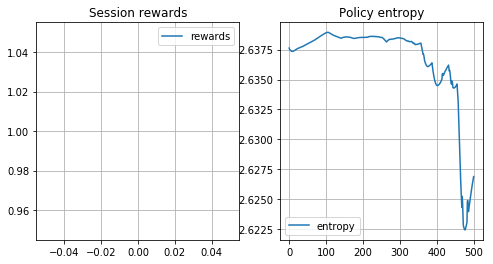

  1%|▍                                                                          | 501/100000 [01:21<7:15:28,  3.81it/s]

  1%|▍                                                                          | 502/100000 [01:21<6:05:58,  4.53it/s]

  1%|▍                                                                          | 503/100000 [01:21<5:32:15,  4.99it/s]

  1%|▍                                                                          | 504/100000 [01:21<5:05:39,  5.43it/s]

  1%|▍                                                                          | 505/100000 [01:21<4:51:31,  5.69it/s]

  1%|▍                                                                          | 506/100000 [01:22<4:39:08,  5.94it/s]

  1%|▍                                                                          | 507/100000 [01:22<4:24:00,  6.28it/s]

  1%|▍                                                                          | 508/100000 [01:22<4:14:54,  6.51it/s]

  1%|▍                                                                          | 509/100000 [01:22<4:10:01,  6.63it/s]

  1%|▍                                                                          | 510/100000 [01:22<4:07:36,  6.70it/s]

  1%|▍                                                                          | 511/100000 [01:22<3:57:56,  6.97it/s]

  1%|▍                                                                          | 512/100000 [01:22<3:58:09,  6.96it/s]

  1%|▍                                                                          | 513/100000 [01:23<3:57:47,  6.97it/s]

  1%|▍                                                                          | 514/100000 [01:23<3:55:33,  7.04it/s]

  1%|▍                                                                          | 515/100000 [01:23<3:55:58,  7.03it/s]

  1%|▍                                                                          | 516/100000 [01:23<3:54:17,  7.08it/s]

  1%|▍                                                                          | 517/100000 [01:23<3:53:35,  7.10it/s]

  1%|▍                                                                          | 518/100000 [01:23<3:54:06,  7.08it/s]

  1%|▍                                                                          | 519/100000 [01:23<3:55:27,  7.04it/s]

  1%|▍                                                                          | 520/100000 [01:24<3:58:23,  6.95it/s]

  1%|▍                                                                          | 521/100000 [01:24<4:00:26,  6.90it/s]

  1%|▍                                                                          | 522/100000 [01:24<3:58:24,  6.95it/s]

  1%|▍                                                                          | 523/100000 [01:24<3:55:58,  7.03it/s]

  1%|▍                                                                          | 524/100000 [01:24<4:00:44,  6.89it/s]

  1%|▍                                                                          | 525/100000 [01:24<3:55:37,  7.04it/s]

  1%|▍                                                                          | 526/100000 [01:24<4:00:59,  6.88it/s]

  1%|▍                                                                          | 527/100000 [01:25<3:58:46,  6.94it/s]

  1%|▍                                                                          | 528/100000 [01:25<3:58:13,  6.96it/s]

  1%|▍                                                                          | 529/100000 [01:25<3:58:28,  6.95it/s]

  1%|▍                                                                          | 530/100000 [01:25<3:50:33,  7.19it/s]

  1%|▍                                                                          | 531/100000 [01:25<3:49:29,  7.22it/s]

  1%|▍                                                                          | 532/100000 [01:25<3:54:12,  7.08it/s]

  1%|▍                                                                          | 533/100000 [01:25<3:52:32,  7.13it/s]

  1%|▍                                                                          | 534/100000 [01:26<3:56:49,  7.00it/s]

  1%|▍                                                                          | 535/100000 [01:26<3:54:22,  7.07it/s]

  1%|▍                                                                          | 536/100000 [01:26<3:54:08,  7.08it/s]

  1%|▍                                                                          | 537/100000 [01:26<3:55:58,  7.03it/s]

  1%|▍                                                                          | 538/100000 [01:26<3:55:45,  7.03it/s]

  1%|▍                                                                          | 539/100000 [01:26<3:56:35,  7.01it/s]

  1%|▍                                                                          | 540/100000 [01:26<3:59:10,  6.93it/s]

  1%|▍                                                                          | 541/100000 [01:27<3:56:30,  7.01it/s]

  1%|▍                                                                          | 542/100000 [01:27<3:56:07,  7.02it/s]

  1%|▍                                                                          | 543/100000 [01:27<3:59:50,  6.91it/s]

  1%|▍                                                                          | 544/100000 [01:27<3:58:57,  6.94it/s]

  1%|▍                                                                          | 545/100000 [01:27<3:53:51,  7.09it/s]

  1%|▍                                                                          | 546/100000 [01:27<3:52:46,  7.12it/s]

  1%|▍                                                                          | 547/100000 [01:27<3:52:01,  7.14it/s]

  1%|▍                                                                          | 548/100000 [01:28<3:48:30,  7.25it/s]

  1%|▍                                                                          | 549/100000 [01:28<3:51:31,  7.16it/s]

  1%|▍                                                                          | 550/100000 [01:28<3:48:39,  7.25it/s]

  1%|▍                                                                          | 551/100000 [01:28<3:48:08,  7.27it/s]

  1%|▍                                                                          | 552/100000 [01:28<3:57:43,  6.97it/s]

  1%|▍                                                                          | 553/100000 [01:28<3:55:28,  7.04it/s]

  1%|▍                                                                          | 554/100000 [01:28<4:00:28,  6.89it/s]

  1%|▍                                                                          | 555/100000 [01:29<3:59:23,  6.92it/s]

  1%|▍                                                                          | 556/100000 [01:29<3:54:09,  7.08it/s]

  1%|▍                                                                          | 557/100000 [01:29<3:55:58,  7.02it/s]

  1%|▍                                                                          | 558/100000 [01:29<3:59:13,  6.93it/s]

  1%|▍                                                                          | 559/100000 [01:29<3:56:31,  7.01it/s]

  1%|▍                                                                          | 560/100000 [01:29<3:54:08,  7.08it/s]

  1%|▍                                                                          | 561/100000 [01:29<3:52:57,  7.11it/s]

  1%|▍                                                                          | 562/100000 [01:30<3:48:10,  7.26it/s]

  1%|▍                                                                          | 563/100000 [01:30<3:49:16,  7.23it/s]

  1%|▍                                                                          | 564/100000 [01:30<3:48:04,  7.27it/s]

  1%|▍                                                                          | 565/100000 [01:30<3:54:11,  7.08it/s]

  1%|▍                                                                          | 566/100000 [01:30<3:56:28,  7.01it/s]

  1%|▍                                                                          | 567/100000 [01:30<3:56:34,  7.00it/s]

  1%|▍                                                                          | 568/100000 [01:30<3:52:41,  7.12it/s]

  1%|▍                                                                          | 569/100000 [01:31<3:56:54,  6.99it/s]

  1%|▍                                                                          | 570/100000 [01:31<3:59:52,  6.91it/s]

  1%|▍                                                                          | 571/100000 [01:31<4:03:55,  6.79it/s]

  1%|▍                                                                          | 572/100000 [01:31<4:02:47,  6.83it/s]

  1%|▍                                                                          | 573/100000 [01:31<4:00:45,  6.88it/s]

  1%|▍                                                                          | 574/100000 [01:31<4:09:00,  6.65it/s]

  1%|▍                                                                          | 575/100000 [01:31<4:09:49,  6.63it/s]

  1%|▍                                                                          | 576/100000 [01:32<4:15:51,  6.48it/s]

  1%|▍                                                                          | 577/100000 [01:32<4:19:35,  6.38it/s]

  1%|▍                                                                          | 578/100000 [01:32<4:24:40,  6.26it/s]

  1%|▍                                                                          | 579/100000 [01:32<4:28:14,  6.18it/s]

  1%|▍                                                                          | 580/100000 [01:32<4:27:15,  6.20it/s]

  1%|▍                                                                          | 581/100000 [01:32<4:26:19,  6.22it/s]

  1%|▍                                                                          | 582/100000 [01:33<4:19:57,  6.37it/s]

  1%|▍                                                                          | 583/100000 [01:33<4:17:28,  6.44it/s]

  1%|▍                                                                          | 584/100000 [01:33<4:13:45,  6.53it/s]

  1%|▍                                                                          | 585/100000 [01:33<4:11:39,  6.58it/s]

  1%|▍                                                                          | 586/100000 [01:33<4:05:51,  6.74it/s]

  1%|▍                                                                          | 587/100000 [01:33<3:58:39,  6.94it/s]

  1%|▍                                                                          | 588/100000 [01:33<4:02:04,  6.84it/s]

  1%|▍                                                                          | 589/100000 [01:34<3:57:37,  6.97it/s]

  1%|▍                                                                          | 590/100000 [01:34<3:56:52,  6.99it/s]

  1%|▍                                                                          | 591/100000 [01:34<3:59:05,  6.93it/s]

  1%|▍                                                                          | 592/100000 [01:34<3:58:53,  6.94it/s]

  1%|▍                                                                          | 593/100000 [01:34<3:55:16,  7.04it/s]

  1%|▍                                                                          | 594/100000 [01:34<3:52:14,  7.13it/s]

  1%|▍                                                                          | 595/100000 [01:34<3:51:07,  7.17it/s]

  1%|▍                                                                          | 596/100000 [01:35<3:57:17,  6.98it/s]

  1%|▍                                                                          | 597/100000 [01:35<3:56:43,  7.00it/s]

  1%|▍                                                                          | 598/100000 [01:35<3:58:13,  6.95it/s]

  1%|▍                                                                          | 599/100000 [01:35<3:54:51,  7.05it/s]

  1%|▍                                                                          | 600/100000 [01:35<3:54:56,  7.05it/s]

  1%|▍                                                                          | 601/100000 [01:35<3:55:58,  7.02it/s]

  1%|▍                                                                          | 602/100000 [01:35<3:55:25,  7.04it/s]

  1%|▍                                                                          | 603/100000 [01:36<3:58:48,  6.94it/s]

  1%|▍                                                                          | 604/100000 [01:36<3:59:10,  6.93it/s]

  1%|▍                                                                          | 605/100000 [01:36<3:55:28,  7.04it/s]

  1%|▍                                                                          | 606/100000 [01:36<3:58:20,  6.95it/s]

  1%|▍                                                                          | 607/100000 [01:36<3:57:21,  6.98it/s]

  1%|▍                                                                          | 608/100000 [01:36<3:58:10,  6.96it/s]

  1%|▍                                                                          | 609/100000 [01:36<3:56:15,  7.01it/s]

  1%|▍                                                                          | 610/100000 [01:37<3:58:37,  6.94it/s]

  1%|▍                                                                          | 611/100000 [01:37<3:56:04,  7.02it/s]

  1%|▍                                                                          | 612/100000 [01:37<3:53:17,  7.10it/s]

  1%|▍                                                                          | 613/100000 [01:37<3:54:19,  7.07it/s]

  1%|▍                                                                          | 614/100000 [01:37<3:53:33,  7.09it/s]

  1%|▍                                                                          | 615/100000 [01:37<3:57:58,  6.96it/s]

  1%|▍                                                                          | 616/100000 [01:37<3:58:06,  6.96it/s]

  1%|▍                                                                          | 617/100000 [01:38<3:56:41,  7.00it/s]

  1%|▍                                                                          | 618/100000 [01:38<3:57:41,  6.97it/s]

  1%|▍                                                                          | 619/100000 [01:38<4:01:22,  6.86it/s]

  1%|▍                                                                          | 620/100000 [01:38<4:04:26,  6.78it/s]

  1%|▍                                                                          | 621/100000 [01:38<4:02:37,  6.83it/s]

  1%|▍                                                                          | 622/100000 [01:38<4:07:18,  6.70it/s]

  1%|▍                                                                          | 623/100000 [01:38<4:05:36,  6.74it/s]

  1%|▍                                                                          | 624/100000 [01:39<4:05:25,  6.75it/s]

  1%|▍                                                                          | 625/100000 [01:39<4:02:18,  6.84it/s]

  1%|▍                                                                          | 626/100000 [01:39<3:57:38,  6.97it/s]

  1%|▍                                                                          | 627/100000 [01:39<3:55:52,  7.02it/s]

  1%|▍                                                                          | 628/100000 [01:39<3:58:36,  6.94it/s]

  1%|▍                                                                          | 629/100000 [01:39<4:12:25,  6.56it/s]

  1%|▍                                                                          | 630/100000 [01:39<4:10:11,  6.62it/s]

  1%|▍                                                                          | 631/100000 [01:40<4:03:09,  6.81it/s]

  1%|▍                                                                          | 632/100000 [01:40<4:05:11,  6.75it/s]

  1%|▍                                                                          | 633/100000 [01:40<4:00:39,  6.88it/s]

  1%|▍                                                                          | 634/100000 [01:40<3:57:28,  6.97it/s]

  1%|▍                                                                          | 635/100000 [01:40<4:01:42,  6.85it/s]

  1%|▍                                                                          | 636/100000 [01:40<4:02:10,  6.84it/s]

  1%|▍                                                                          | 637/100000 [01:40<4:02:01,  6.84it/s]

  1%|▍                                                                          | 638/100000 [01:41<4:01:24,  6.86it/s]

  1%|▍                                                                          | 639/100000 [01:41<3:59:29,  6.91it/s]

  1%|▍                                                                          | 640/100000 [01:41<4:03:36,  6.80it/s]

  1%|▍                                                                          | 641/100000 [01:41<4:04:59,  6.76it/s]

  1%|▍                                                                          | 642/100000 [01:41<4:14:24,  6.51it/s]

  1%|▍                                                                          | 643/100000 [01:41<4:07:06,  6.70it/s]

  1%|▍                                                                          | 644/100000 [01:42<4:00:59,  6.87it/s]

  1%|▍                                                                          | 645/100000 [01:42<4:02:10,  6.84it/s]

  1%|▍                                                                          | 646/100000 [01:42<4:01:00,  6.87it/s]

  1%|▍                                                                          | 647/100000 [01:42<3:57:13,  6.98it/s]

  1%|▍                                                                          | 648/100000 [01:42<3:57:02,  6.99it/s]

  1%|▍                                                                          | 649/100000 [01:42<3:54:56,  7.05it/s]

  1%|▍                                                                          | 650/100000 [01:42<3:55:27,  7.03it/s]

  1%|▍                                                                          | 651/100000 [01:43<3:57:17,  6.98it/s]

  1%|▍                                                                          | 652/100000 [01:43<3:58:05,  6.95it/s]

  1%|▍                                                                          | 653/100000 [01:43<3:53:41,  7.09it/s]

  1%|▍                                                                          | 654/100000 [01:43<3:52:34,  7.12it/s]

  1%|▍                                                                          | 655/100000 [01:43<3:53:18,  7.10it/s]

  1%|▍                                                                          | 656/100000 [01:43<3:56:46,  6.99it/s]

  1%|▍                                                                          | 657/100000 [01:43<3:52:16,  7.13it/s]

  1%|▍                                                                          | 658/100000 [01:44<3:55:33,  7.03it/s]

  1%|▍                                                                          | 659/100000 [01:44<3:55:22,  7.03it/s]

  1%|▍                                                                          | 660/100000 [01:44<3:58:43,  6.94it/s]

  1%|▍                                                                          | 661/100000 [01:44<3:58:05,  6.95it/s]

  1%|▍                                                                          | 662/100000 [01:44<3:56:39,  7.00it/s]

  1%|▍                                                                          | 663/100000 [01:44<4:01:36,  6.85it/s]

  1%|▍                                                                          | 664/100000 [01:44<4:01:06,  6.87it/s]

  1%|▍                                                                          | 665/100000 [01:45<4:05:42,  6.74it/s]

  1%|▍                                                                          | 666/100000 [01:45<4:02:58,  6.81it/s]

  1%|▌                                                                          | 667/100000 [01:45<4:02:33,  6.83it/s]

  1%|▌                                                                          | 668/100000 [01:45<4:06:43,  6.71it/s]

  1%|▌                                                                          | 669/100000 [01:45<4:10:08,  6.62it/s]

  1%|▌                                                                          | 670/100000 [01:45<4:16:00,  6.47it/s]

  1%|▌                                                                          | 671/100000 [01:45<4:14:09,  6.51it/s]

  1%|▌                                                                          | 672/100000 [01:46<4:07:23,  6.69it/s]

  1%|▌                                                                          | 673/100000 [01:46<3:57:41,  6.96it/s]

  1%|▌                                                                          | 674/100000 [01:46<3:57:21,  6.97it/s]

  1%|▌                                                                          | 675/100000 [01:46<3:51:40,  7.15it/s]

  1%|▌                                                                          | 676/100000 [01:46<3:50:39,  7.18it/s]

  1%|▌                                                                          | 677/100000 [01:46<3:48:57,  7.23it/s]

  1%|▌                                                                          | 678/100000 [01:46<3:50:15,  7.19it/s]

  1%|▌                                                                          | 679/100000 [01:47<3:47:40,  7.27it/s]

  1%|▌                                                                          | 680/100000 [01:47<3:47:52,  7.26it/s]

  1%|▌                                                                          | 681/100000 [01:47<3:50:28,  7.18it/s]

  1%|▌                                                                          | 682/100000 [01:47<3:48:49,  7.23it/s]

  1%|▌                                                                          | 683/100000 [01:47<3:51:38,  7.15it/s]

  1%|▌                                                                          | 684/100000 [01:47<3:48:39,  7.24it/s]

  1%|▌                                                                          | 685/100000 [01:47<3:48:32,  7.24it/s]

  1%|▌                                                                          | 686/100000 [01:48<3:46:28,  7.31it/s]

  1%|▌                                                                          | 687/100000 [01:48<3:46:01,  7.32it/s]

  1%|▌                                                                          | 688/100000 [01:48<3:47:41,  7.27it/s]

  1%|▌                                                                          | 689/100000 [01:48<3:51:50,  7.14it/s]

  1%|▌                                                                          | 690/100000 [01:48<3:51:45,  7.14it/s]

  1%|▌                                                                          | 691/100000 [01:48<3:51:42,  7.14it/s]

  1%|▌                                                                          | 692/100000 [01:48<3:53:09,  7.10it/s]

  1%|▌                                                                          | 693/100000 [01:49<3:56:39,  6.99it/s]

  1%|▌                                                                          | 694/100000 [01:49<3:54:08,  7.07it/s]

  1%|▌                                                                          | 695/100000 [01:49<3:50:23,  7.18it/s]

  1%|▌                                                                          | 696/100000 [01:49<3:50:14,  7.19it/s]

  1%|▌                                                                          | 697/100000 [01:49<3:48:39,  7.24it/s]

  1%|▌                                                                          | 698/100000 [01:49<3:49:31,  7.21it/s]

  1%|▌                                                                          | 699/100000 [01:49<3:48:39,  7.24it/s]

  1%|▌                                                                          | 700/100000 [01:49<3:52:30,  7.12it/s]

  1%|▌                                                                          | 701/100000 [01:50<3:51:43,  7.14it/s]

  1%|▌                                                                          | 702/100000 [01:50<3:49:41,  7.21it/s]

  1%|▌                                                                          | 703/100000 [01:50<3:50:44,  7.17it/s]

  1%|▌                                                                          | 704/100000 [01:50<3:48:00,  7.26it/s]

  1%|▌                                                                          | 705/100000 [01:50<3:48:04,  7.26it/s]

  1%|▌                                                                          | 706/100000 [01:50<3:49:07,  7.22it/s]

  1%|▌                                                                          | 707/100000 [01:50<3:49:50,  7.20it/s]

  1%|▌                                                                          | 708/100000 [01:51<3:51:50,  7.14it/s]

  1%|▌                                                                          | 709/100000 [01:51<3:50:15,  7.19it/s]

  1%|▌                                                                          | 710/100000 [01:51<3:45:11,  7.35it/s]

  1%|▌                                                                          | 711/100000 [01:51<3:45:36,  7.34it/s]

  1%|▌                                                                          | 712/100000 [01:51<3:45:23,  7.34it/s]

  1%|▌                                                                          | 713/100000 [01:51<3:48:13,  7.25it/s]

  1%|▌                                                                          | 714/100000 [01:51<3:50:12,  7.19it/s]

  1%|▌                                                                          | 715/100000 [01:52<3:53:05,  7.10it/s]

  1%|▌                                                                          | 716/100000 [01:52<3:56:35,  6.99it/s]

  1%|▌                                                                          | 717/100000 [01:52<3:55:04,  7.04it/s]

  1%|▌                                                                          | 718/100000 [01:52<3:58:28,  6.94it/s]

  1%|▌                                                                          | 719/100000 [01:52<3:53:24,  7.09it/s]

  1%|▌                                                                          | 720/100000 [01:52<3:48:52,  7.23it/s]

  1%|▌                                                                          | 721/100000 [01:52<3:55:36,  7.02it/s]

  1%|▌                                                                          | 722/100000 [01:53<3:54:52,  7.04it/s]

  1%|▌                                                                          | 723/100000 [01:53<3:54:51,  7.05it/s]

  1%|▌                                                                          | 724/100000 [01:53<3:54:21,  7.06it/s]

  1%|▌                                                                          | 725/100000 [01:53<3:53:29,  7.09it/s]

  1%|▌                                                                          | 726/100000 [01:53<3:50:25,  7.18it/s]

  1%|▌                                                                          | 727/100000 [01:53<3:51:14,  7.16it/s]

  1%|▌                                                                          | 728/100000 [01:53<3:55:17,  7.03it/s]

  1%|▌                                                                          | 729/100000 [01:54<3:57:07,  6.98it/s]

  1%|▌                                                                          | 730/100000 [01:54<3:57:25,  6.97it/s]

  1%|▌                                                                          | 731/100000 [01:54<4:00:06,  6.89it/s]

  1%|▌                                                                          | 732/100000 [01:54<3:55:32,  7.02it/s]

  1%|▌                                                                          | 733/100000 [01:54<3:53:19,  7.09it/s]

  1%|▌                                                                          | 734/100000 [01:54<4:03:41,  6.79it/s]

  1%|▌                                                                          | 735/100000 [01:54<3:55:33,  7.02it/s]

  1%|▌                                                                          | 736/100000 [01:55<4:01:16,  6.86it/s]

  1%|▌                                                                          | 737/100000 [01:55<3:58:20,  6.94it/s]

  1%|▌                                                                          | 738/100000 [01:55<3:53:47,  7.08it/s]

  1%|▌                                                                          | 739/100000 [01:55<3:55:05,  7.04it/s]

  1%|▌                                                                          | 740/100000 [01:55<3:58:27,  6.94it/s]

  1%|▌                                                                          | 741/100000 [01:55<3:57:21,  6.97it/s]

  1%|▌                                                                          | 742/100000 [01:55<3:57:04,  6.98it/s]

  1%|▌                                                                          | 743/100000 [01:56<3:56:52,  6.98it/s]

  1%|▌                                                                          | 744/100000 [01:56<3:56:44,  6.99it/s]

  1%|▌                                                                          | 745/100000 [01:56<3:52:10,  7.12it/s]

  1%|▌                                                                          | 746/100000 [01:56<3:53:26,  7.09it/s]

  1%|▌                                                                          | 747/100000 [01:56<3:54:20,  7.06it/s]

  1%|▌                                                                          | 748/100000 [01:56<3:45:02,  7.35it/s]

  1%|▌                                                                          | 749/100000 [01:56<3:45:58,  7.32it/s]

  1%|▌                                                                          | 750/100000 [01:57<3:49:35,  7.20it/s]

  1%|▌                                                                          | 751/100000 [01:57<3:53:07,  7.10it/s]

  1%|▌                                                                          | 752/100000 [01:57<3:55:06,  7.04it/s]

  1%|▌                                                                          | 753/100000 [01:57<3:56:58,  6.98it/s]

  1%|▌                                                                          | 754/100000 [01:57<3:51:20,  7.15it/s]

  1%|▌                                                                          | 755/100000 [01:57<3:53:21,  7.09it/s]

  1%|▌                                                                          | 756/100000 [01:57<3:52:16,  7.12it/s]

  1%|▌                                                                          | 757/100000 [01:58<3:55:00,  7.04it/s]

  1%|▌                                                                          | 758/100000 [01:58<3:52:26,  7.12it/s]

  1%|▌                                                                          | 759/100000 [01:58<3:52:08,  7.13it/s]

  1%|▌                                                                          | 760/100000 [01:58<3:55:23,  7.03it/s]

  1%|▌                                                                          | 761/100000 [01:58<3:52:13,  7.12it/s]

  1%|▌                                                                          | 762/100000 [01:58<3:51:58,  7.13it/s]

  1%|▌                                                                          | 763/100000 [01:58<3:53:17,  7.09it/s]

  1%|▌                                                                          | 764/100000 [01:58<3:50:44,  7.17it/s]

  1%|▌                                                                          | 765/100000 [01:59<3:49:57,  7.19it/s]

  1%|▌                                                                          | 766/100000 [01:59<3:47:54,  7.26it/s]

  1%|▌                                                                          | 767/100000 [01:59<3:49:27,  7.21it/s]

  1%|▌                                                                          | 768/100000 [01:59<3:48:33,  7.24it/s]

  1%|▌                                                                          | 769/100000 [01:59<3:49:24,  7.21it/s]

  1%|▌                                                                          | 770/100000 [01:59<3:50:00,  7.19it/s]

  1%|▌                                                                          | 771/100000 [01:59<3:54:23,  7.06it/s]

  1%|▌                                                                          | 772/100000 [02:00<3:54:58,  7.04it/s]

  1%|▌                                                                          | 773/100000 [02:00<3:52:54,  7.10it/s]

  1%|▌                                                                          | 774/100000 [02:00<3:53:26,  7.08it/s]

  1%|▌                                                                          | 775/100000 [02:00<3:50:20,  7.18it/s]

  1%|▌                                                                          | 776/100000 [02:00<3:49:40,  7.20it/s]

  1%|▌                                                                          | 777/100000 [02:00<3:46:42,  7.29it/s]

  1%|▌                                                                          | 778/100000 [02:00<3:48:06,  7.25it/s]

  1%|▌                                                                          | 779/100000 [02:01<3:51:04,  7.16it/s]

  1%|▌                                                                          | 780/100000 [02:01<3:49:10,  7.22it/s]

  1%|▌                                                                          | 781/100000 [02:01<3:50:49,  7.16it/s]

  1%|▌                                                                          | 782/100000 [02:01<3:49:30,  7.21it/s]

  1%|▌                                                                          | 783/100000 [02:01<3:55:31,  7.02it/s]

  1%|▌                                                                          | 784/100000 [02:01<4:02:12,  6.83it/s]

  1%|▌                                                                          | 785/100000 [02:01<4:08:22,  6.66it/s]

  1%|▌                                                                          | 786/100000 [02:02<4:06:44,  6.70it/s]

  1%|▌                                                                          | 787/100000 [02:02<4:12:32,  6.55it/s]

  1%|▌                                                                          | 788/100000 [02:02<4:24:01,  6.26it/s]

  1%|▌                                                                          | 789/100000 [02:02<4:12:44,  6.54it/s]

  1%|▌                                                                          | 790/100000 [02:02<4:10:17,  6.61it/s]

  1%|▌                                                                          | 791/100000 [02:02<4:08:34,  6.65it/s]

  1%|▌                                                                          | 792/100000 [02:03<4:01:25,  6.85it/s]

  1%|▌                                                                          | 793/100000 [02:03<3:58:23,  6.94it/s]

  1%|▌                                                                          | 794/100000 [02:03<3:57:16,  6.97it/s]

  1%|▌                                                                          | 795/100000 [02:03<3:54:59,  7.04it/s]

  1%|▌                                                                          | 796/100000 [02:03<3:56:52,  6.98it/s]

  1%|▌                                                                          | 797/100000 [02:03<4:05:07,  6.75it/s]

  1%|▌                                                                          | 798/100000 [02:03<4:00:59,  6.86it/s]

  1%|▌                                                                          | 799/100000 [02:04<3:56:06,  7.00it/s]

  1%|▌                                                                          | 800/100000 [02:04<3:57:38,  6.96it/s]

  1%|▌                                                                          | 801/100000 [02:04<3:57:44,  6.95it/s]

  1%|▌                                                                          | 802/100000 [02:04<3:55:48,  7.01it/s]

  1%|▌                                                                          | 803/100000 [02:04<3:55:27,  7.02it/s]

  1%|▌                                                                          | 804/100000 [02:04<3:47:16,  7.27it/s]

  1%|▌                                                                          | 805/100000 [02:04<3:47:00,  7.28it/s]

  1%|▌                                                                          | 806/100000 [02:05<3:51:45,  7.13it/s]

  1%|▌                                                                          | 807/100000 [02:05<3:50:38,  7.17it/s]

  1%|▌                                                                          | 808/100000 [02:05<3:48:21,  7.24it/s]

  1%|▌                                                                          | 809/100000 [02:05<3:49:44,  7.20it/s]

  1%|▌                                                                          | 810/100000 [02:05<3:47:14,  7.28it/s]

  1%|▌                                                                          | 811/100000 [02:05<3:50:26,  7.17it/s]

  1%|▌                                                                          | 812/100000 [02:05<3:56:08,  7.00it/s]

  1%|▌                                                                          | 813/100000 [02:05<3:54:41,  7.04it/s]

  1%|▌                                                                          | 814/100000 [02:06<3:53:40,  7.07it/s]

  1%|▌                                                                          | 815/100000 [02:06<3:54:26,  7.05it/s]

  1%|▌                                                                          | 816/100000 [02:06<3:50:01,  7.19it/s]

  1%|▌                                                                          | 817/100000 [02:06<3:53:22,  7.08it/s]

  1%|▌                                                                          | 818/100000 [02:06<3:50:46,  7.16it/s]

  1%|▌                                                                          | 819/100000 [02:06<3:52:24,  7.11it/s]

  1%|▌                                                                          | 820/100000 [02:06<3:55:32,  7.02it/s]

  1%|▌                                                                          | 821/100000 [02:07<3:53:16,  7.09it/s]

  1%|▌                                                                          | 822/100000 [02:07<3:54:39,  7.04it/s]

  1%|▌                                                                          | 823/100000 [02:07<3:50:10,  7.18it/s]

  1%|▌                                                                          | 824/100000 [02:07<3:44:33,  7.36it/s]

  1%|▌                                                                          | 825/100000 [02:07<3:43:35,  7.39it/s]

  1%|▌                                                                          | 826/100000 [02:07<3:45:24,  7.33it/s]

  1%|▌                                                                          | 827/100000 [02:07<3:45:40,  7.32it/s]

  1%|▌                                                                          | 828/100000 [02:08<3:50:49,  7.16it/s]

  1%|▌                                                                          | 829/100000 [02:08<3:50:57,  7.16it/s]

  1%|▌                                                                          | 830/100000 [02:08<3:51:02,  7.15it/s]

  1%|▌                                                                          | 831/100000 [02:08<3:54:04,  7.06it/s]

  1%|▌                                                                          | 832/100000 [02:08<3:56:12,  7.00it/s]

  1%|▌                                                                          | 833/100000 [02:08<3:50:45,  7.16it/s]

  1%|▋                                                                          | 834/100000 [02:08<3:51:53,  7.13it/s]

  1%|▋                                                                          | 835/100000 [02:09<3:52:41,  7.10it/s]

  1%|▋                                                                          | 836/100000 [02:09<3:54:14,  7.06it/s]

  1%|▋                                                                          | 837/100000 [02:09<3:54:19,  7.05it/s]

  1%|▋                                                                          | 838/100000 [02:09<3:55:23,  7.02it/s]

  1%|▋                                                                          | 839/100000 [02:09<3:56:07,  7.00it/s]

  1%|▋                                                                          | 840/100000 [02:09<3:56:38,  6.98it/s]

  1%|▋                                                                          | 841/100000 [02:09<3:56:59,  6.97it/s]

  1%|▋                                                                          | 842/100000 [02:10<4:00:43,  6.87it/s]

  1%|▋                                                                          | 843/100000 [02:10<3:58:51,  6.92it/s]

  1%|▋                                                                          | 844/100000 [02:10<3:52:06,  7.12it/s]

  1%|▋                                                                          | 845/100000 [02:10<3:55:48,  7.01it/s]

  1%|▋                                                                          | 846/100000 [02:10<3:52:56,  7.09it/s]

  1%|▋                                                                          | 847/100000 [02:10<3:57:52,  6.95it/s]

  1%|▋                                                                          | 848/100000 [02:10<3:54:23,  7.05it/s]

  1%|▋                                                                          | 849/100000 [02:11<3:58:53,  6.92it/s]

  1%|▋                                                                          | 850/100000 [02:11<3:58:04,  6.94it/s]

  1%|▋                                                                          | 851/100000 [02:11<3:54:01,  7.06it/s]

  1%|▋                                                                          | 852/100000 [02:11<3:54:40,  7.04it/s]

  1%|▋                                                                          | 853/100000 [02:11<3:56:36,  6.98it/s]

  1%|▋                                                                          | 854/100000 [02:11<3:56:57,  6.97it/s]

  1%|▋                                                                          | 855/100000 [02:11<3:56:43,  6.98it/s]

  1%|▋                                                                          | 856/100000 [02:12<3:59:31,  6.90it/s]

  1%|▋                                                                          | 857/100000 [02:12<3:57:31,  6.96it/s]

  1%|▋                                                                          | 858/100000 [02:12<4:12:27,  6.54it/s]

  1%|▋                                                                          | 859/100000 [02:12<4:01:07,  6.85it/s]

  1%|▋                                                                          | 860/100000 [02:12<3:59:38,  6.90it/s]

  1%|▋                                                                          | 861/100000 [02:12<3:55:36,  7.01it/s]

  1%|▋                                                                          | 862/100000 [02:12<3:51:18,  7.14it/s]

  1%|▋                                                                          | 863/100000 [02:13<3:59:41,  6.89it/s]

  1%|▋                                                                          | 864/100000 [02:13<4:00:06,  6.88it/s]

  1%|▋                                                                          | 865/100000 [02:13<3:56:26,  6.99it/s]

  1%|▋                                                                          | 866/100000 [02:13<3:53:52,  7.06it/s]

  1%|▋                                                                          | 867/100000 [02:13<3:53:03,  7.09it/s]

  1%|▋                                                                          | 868/100000 [02:13<3:59:25,  6.90it/s]

  1%|▋                                                                          | 869/100000 [02:13<3:53:28,  7.08it/s]

  1%|▋                                                                          | 870/100000 [02:14<3:52:17,  7.11it/s]

  1%|▋                                                                          | 871/100000 [02:14<3:55:54,  7.00it/s]

  1%|▋                                                                          | 872/100000 [02:14<3:53:29,  7.08it/s]

  1%|▋                                                                          | 873/100000 [02:14<3:53:17,  7.08it/s]

  1%|▋                                                                          | 874/100000 [02:14<3:54:37,  7.04it/s]

  1%|▋                                                                          | 875/100000 [02:14<3:52:35,  7.10it/s]

  1%|▋                                                                          | 876/100000 [02:14<3:50:10,  7.18it/s]

  1%|▋                                                                          | 877/100000 [02:15<3:47:00,  7.28it/s]

  1%|▋                                                                          | 878/100000 [02:15<3:49:14,  7.21it/s]

  1%|▋                                                                          | 879/100000 [02:15<3:52:17,  7.11it/s]

  1%|▋                                                                          | 880/100000 [02:15<3:51:26,  7.14it/s]

  1%|▋                                                                          | 881/100000 [02:15<3:48:52,  7.22it/s]

  1%|▋                                                                          | 882/100000 [02:15<3:52:31,  7.10it/s]

  1%|▋                                                                          | 883/100000 [02:15<3:50:37,  7.16it/s]

  1%|▋                                                                          | 884/100000 [02:16<3:53:15,  7.08it/s]

  1%|▋                                                                          | 885/100000 [02:16<3:50:08,  7.18it/s]

  1%|▋                                                                          | 886/100000 [02:16<3:49:56,  7.18it/s]

  1%|▋                                                                          | 887/100000 [02:16<3:52:46,  7.10it/s]

  1%|▋                                                                          | 888/100000 [02:16<3:51:46,  7.13it/s]

  1%|▋                                                                          | 889/100000 [02:16<3:50:05,  7.18it/s]

  1%|▋                                                                          | 890/100000 [02:16<3:49:54,  7.18it/s]

  1%|▋                                                                          | 891/100000 [02:17<3:56:12,  6.99it/s]

  1%|▋                                                                          | 892/100000 [02:17<3:56:10,  6.99it/s]

  1%|▋                                                                          | 893/100000 [02:17<3:53:39,  7.07it/s]

  1%|▋                                                                          | 894/100000 [02:17<3:51:24,  7.14it/s]

  1%|▋                                                                          | 895/100000 [02:17<3:51:19,  7.14it/s]

  1%|▋                                                                          | 896/100000 [02:17<3:51:15,  7.14it/s]

  1%|▋                                                                          | 897/100000 [02:17<3:44:46,  7.35it/s]

  1%|▋                                                                          | 898/100000 [02:17<3:49:38,  7.19it/s]

  1%|▋                                                                          | 899/100000 [02:18<3:51:04,  7.15it/s]

  1%|▋                                                                          | 900/100000 [02:18<3:49:35,  7.19it/s]

  1%|▋                                                                          | 901/100000 [02:18<3:53:00,  7.09it/s]

  1%|▋                                                                          | 902/100000 [02:18<3:48:58,  7.21it/s]

  1%|▋                                                                          | 903/100000 [02:18<3:50:35,  7.16it/s]

  1%|▋                                                                          | 904/100000 [02:18<3:52:43,  7.10it/s]

  1%|▋                                                                          | 905/100000 [02:18<3:51:14,  7.14it/s]

  1%|▋                                                                          | 906/100000 [02:19<4:03:04,  6.79it/s]

  1%|▋                                                                          | 907/100000 [02:19<3:57:00,  6.97it/s]

  1%|▋                                                                          | 908/100000 [02:19<3:53:44,  7.07it/s]

  1%|▋                                                                          | 909/100000 [02:19<3:54:55,  7.03it/s]

  1%|▋                                                                          | 910/100000 [02:19<3:51:47,  7.13it/s]

  1%|▋                                                                          | 911/100000 [02:19<3:53:03,  7.09it/s]

  1%|▋                                                                          | 912/100000 [02:19<3:56:54,  6.97it/s]

  1%|▋                                                                          | 913/100000 [02:20<3:55:39,  7.01it/s]

  1%|▋                                                                          | 914/100000 [02:20<3:52:47,  7.09it/s]

  1%|▋                                                                          | 915/100000 [02:20<3:52:46,  7.09it/s]

  1%|▋                                                                          | 916/100000 [02:20<3:50:46,  7.16it/s]

  1%|▋                                                                          | 917/100000 [02:20<3:48:52,  7.22it/s]

  1%|▋                                                                          | 918/100000 [02:20<3:48:02,  7.24it/s]

  1%|▋                                                                          | 919/100000 [02:20<3:49:26,  7.20it/s]

  1%|▋                                                                          | 920/100000 [02:21<3:45:57,  7.31it/s]

  1%|▋                                                                          | 921/100000 [02:21<3:49:28,  7.20it/s]

  1%|▋                                                                          | 922/100000 [02:21<3:53:24,  7.07it/s]

  1%|▋                                                                          | 923/100000 [02:21<4:01:06,  6.85it/s]

  1%|▋                                                                          | 924/100000 [02:21<4:06:30,  6.70it/s]

  1%|▋                                                                          | 925/100000 [02:21<3:58:24,  6.93it/s]

  1%|▋                                                                          | 926/100000 [02:21<3:59:09,  6.90it/s]

  1%|▋                                                                          | 927/100000 [02:22<3:57:13,  6.96it/s]

  1%|▋                                                                          | 928/100000 [02:22<3:51:24,  7.14it/s]

  1%|▋                                                                          | 929/100000 [02:22<3:51:47,  7.12it/s]

  1%|▋                                                                          | 930/100000 [02:22<3:51:03,  7.15it/s]

  1%|▋                                                                          | 931/100000 [02:22<3:48:04,  7.24it/s]

  1%|▋                                                                          | 932/100000 [02:22<3:49:57,  7.18it/s]

  1%|▋                                                                          | 933/100000 [02:22<3:49:46,  7.19it/s]

  1%|▋                                                                          | 934/100000 [02:23<3:52:37,  7.10it/s]

  1%|▋                                                                          | 935/100000 [02:23<3:52:38,  7.10it/s]

  1%|▋                                                                          | 936/100000 [02:23<3:57:05,  6.96it/s]

  1%|▋                                                                          | 937/100000 [02:23<3:51:18,  7.14it/s]

  1%|▋                                                                          | 938/100000 [02:23<3:54:11,  7.05it/s]

  1%|▋                                                                          | 939/100000 [02:23<3:52:14,  7.11it/s]

  1%|▋                                                                          | 940/100000 [02:23<3:51:22,  7.14it/s]

  1%|▋                                                                          | 941/100000 [02:24<3:47:47,  7.25it/s]

  1%|▋                                                                          | 942/100000 [02:24<3:51:13,  7.14it/s]

  1%|▋                                                                          | 943/100000 [02:24<3:51:39,  7.13it/s]

  1%|▋                                                                          | 944/100000 [02:24<3:56:24,  6.98it/s]

  1%|▋                                                                          | 945/100000 [02:24<3:52:48,  7.09it/s]

  1%|▋                                                                          | 946/100000 [02:24<3:54:14,  7.05it/s]

  1%|▋                                                                          | 947/100000 [02:24<3:49:18,  7.20it/s]

  1%|▋                                                                          | 948/100000 [02:25<3:49:18,  7.20it/s]

  1%|▋                                                                          | 949/100000 [02:25<3:54:45,  7.03it/s]

  1%|▋                                                                          | 950/100000 [02:25<3:53:07,  7.08it/s]

  1%|▋                                                                          | 951/100000 [02:25<3:52:29,  7.10it/s]

  1%|▋                                                                          | 952/100000 [02:25<3:49:33,  7.19it/s]

  1%|▋                                                                          | 953/100000 [02:25<3:51:27,  7.13it/s]

  1%|▋                                                                          | 954/100000 [02:25<3:50:19,  7.17it/s]

  1%|▋                                                                          | 955/100000 [02:26<3:48:02,  7.24it/s]

  1%|▋                                                                          | 956/100000 [02:26<3:48:55,  7.21it/s]

  1%|▋                                                                          | 957/100000 [02:26<3:46:33,  7.29it/s]

  1%|▋                                                                          | 958/100000 [02:26<3:47:52,  7.24it/s]

  1%|▋                                                                          | 959/100000 [02:26<3:47:19,  7.26it/s]

  1%|▋                                                                          | 960/100000 [02:26<3:52:22,  7.10it/s]

  1%|▋                                                                          | 961/100000 [02:26<3:51:56,  7.12it/s]

  1%|▋                                                                          | 962/100000 [02:26<3:47:41,  7.25it/s]

  1%|▋                                                                          | 963/100000 [02:27<3:47:40,  7.25it/s]

  1%|▋                                                                          | 964/100000 [02:27<3:48:39,  7.22it/s]

  1%|▋                                                                          | 965/100000 [02:27<3:52:48,  7.09it/s]

  1%|▋                                                                          | 966/100000 [02:27<3:54:13,  7.05it/s]

  1%|▋                                                                          | 967/100000 [02:27<3:56:42,  6.97it/s]

  1%|▋                                                                          | 968/100000 [02:27<3:57:26,  6.95it/s]

  1%|▋                                                                          | 969/100000 [02:27<3:55:29,  7.01it/s]

  1%|▋                                                                          | 970/100000 [02:28<3:54:07,  7.05it/s]

  1%|▋                                                                          | 971/100000 [02:28<3:52:10,  7.11it/s]

  1%|▋                                                                          | 972/100000 [02:28<3:51:18,  7.14it/s]

  1%|▋                                                                          | 973/100000 [02:28<3:50:12,  7.17it/s]

  1%|▋                                                                          | 974/100000 [02:28<3:48:56,  7.21it/s]

  1%|▋                                                                          | 975/100000 [02:28<3:50:31,  7.16it/s]

  1%|▋                                                                          | 976/100000 [02:28<3:54:35,  7.04it/s]

  1%|▋                                                                          | 977/100000 [02:29<3:59:25,  6.89it/s]

  1%|▋                                                                          | 978/100000 [02:29<3:57:22,  6.95it/s]

  1%|▋                                                                          | 979/100000 [02:29<3:59:23,  6.89it/s]

  1%|▋                                                                          | 980/100000 [02:29<4:10:42,  6.58it/s]

  1%|▋                                                                          | 981/100000 [02:29<4:05:45,  6.72it/s]

  1%|▋                                                                          | 982/100000 [02:29<4:03:46,  6.77it/s]

  1%|▋                                                                          | 983/100000 [02:30<3:58:55,  6.91it/s]

  1%|▋                                                                          | 984/100000 [02:30<4:00:58,  6.85it/s]

  1%|▋                                                                          | 985/100000 [02:30<3:55:58,  6.99it/s]

  1%|▋                                                                          | 986/100000 [02:30<3:57:24,  6.95it/s]

  1%|▋                                                                          | 987/100000 [02:30<3:52:58,  7.08it/s]

  1%|▋                                                                          | 988/100000 [02:30<3:56:48,  6.97it/s]

  1%|▋                                                                          | 989/100000 [02:30<3:53:03,  7.08it/s]

  1%|▋                                                                          | 990/100000 [02:31<3:54:52,  7.03it/s]

  1%|▋                                                                          | 991/100000 [02:31<3:57:38,  6.94it/s]

  1%|▋                                                                          | 992/100000 [02:31<3:55:06,  7.02it/s]

  1%|▋                                                                          | 993/100000 [02:31<3:56:19,  6.98it/s]

  1%|▋                                                                          | 994/100000 [02:31<3:54:41,  7.03it/s]

  1%|▋                                                                          | 995/100000 [02:31<4:07:23,  6.67it/s]

  1%|▋                                                                          | 996/100000 [02:31<4:11:50,  6.55it/s]

  1%|▋                                                                          | 997/100000 [02:32<4:13:27,  6.51it/s]

  1%|▋                                                                          | 998/100000 [02:32<4:12:37,  6.53it/s]

  1%|▋                                                                          | 999/100000 [02:32<4:16:58,  6.42it/s]

  1%|▋                                                                         | 1000/100000 [02:32<4:05:40,  6.72it/s]

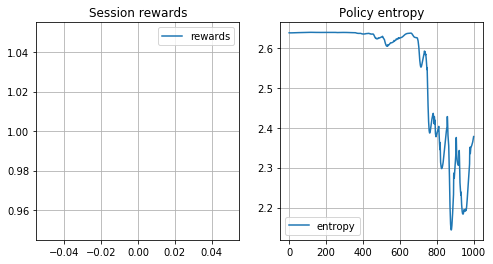

  1%|▋                                                                         | 1001/100000 [02:33<6:59:20,  3.93it/s]

  1%|▋                                                                         | 1002/100000 [02:33<5:49:55,  4.72it/s]

  1%|▋                                                                         | 1003/100000 [02:33<5:17:39,  5.19it/s]

  1%|▋                                                                         | 1004/100000 [02:33<4:48:39,  5.72it/s]

  1%|▋                                                                         | 1005/100000 [02:33<4:30:48,  6.09it/s]

  1%|▋                                                                         | 1006/100000 [02:33<4:23:46,  6.26it/s]

  1%|▋                                                                         | 1007/100000 [02:33<4:10:25,  6.59it/s]

  1%|▋                                                                         | 1008/100000 [02:33<4:07:01,  6.68it/s]

  1%|▋                                                                         | 1009/100000 [02:34<4:01:40,  6.83it/s]

  1%|▋                                                                         | 1010/100000 [02:34<3:59:54,  6.88it/s]

  1%|▋                                                                         | 1011/100000 [02:34<3:59:39,  6.88it/s]

  1%|▋                                                                         | 1012/100000 [02:34<3:57:00,  6.96it/s]

  1%|▋                                                                         | 1013/100000 [02:34<3:48:43,  7.21it/s]

  1%|▊                                                                         | 1014/100000 [02:34<3:49:51,  7.18it/s]

  1%|▊                                                                         | 1015/100000 [02:34<3:54:35,  7.03it/s]

  1%|▊                                                                         | 1016/100000 [02:35<3:53:57,  7.05it/s]

  1%|▊                                                                         | 1017/100000 [02:35<3:47:34,  7.25it/s]

  1%|▊                                                                         | 1018/100000 [02:35<3:44:05,  7.36it/s]

  1%|▊                                                                         | 1019/100000 [02:35<3:47:06,  7.26it/s]

  1%|▊                                                                         | 1020/100000 [02:35<3:46:14,  7.29it/s]

  1%|▊                                                                         | 1021/100000 [02:35<3:45:08,  7.33it/s]

  1%|▊                                                                         | 1022/100000 [02:35<3:48:19,  7.22it/s]

  1%|▊                                                                         | 1023/100000 [02:36<3:47:35,  7.25it/s]

  1%|▊                                                                         | 1024/100000 [02:36<3:45:05,  7.33it/s]

  1%|▊                                                                         | 1025/100000 [02:36<3:43:50,  7.37it/s]

  1%|▊                                                                         | 1026/100000 [02:36<3:48:23,  7.22it/s]

  1%|▊                                                                         | 1027/100000 [02:36<3:52:05,  7.11it/s]

  1%|▊                                                                         | 1028/100000 [02:36<3:50:12,  7.17it/s]

  1%|▊                                                                         | 1029/100000 [02:36<3:45:26,  7.32it/s]

  1%|▊                                                                         | 1030/100000 [02:37<3:44:04,  7.36it/s]

  1%|▊                                                                         | 1031/100000 [02:37<3:45:06,  7.33it/s]

  1%|▊                                                                         | 1032/100000 [02:37<3:43:50,  7.37it/s]

  1%|▊                                                                         | 1033/100000 [02:37<3:46:25,  7.28it/s]

  1%|▊                                                                         | 1034/100000 [02:37<3:44:16,  7.35it/s]

  1%|▊                                                                         | 1035/100000 [02:37<3:43:44,  7.37it/s]

  1%|▊                                                                         | 1036/100000 [02:37<4:01:40,  6.82it/s]

  1%|▊                                                                         | 1037/100000 [02:37<3:57:54,  6.93it/s]

  1%|▊                                                                         | 1038/100000 [02:38<3:59:43,  6.88it/s]

  1%|▊                                                                         | 1039/100000 [02:38<4:00:30,  6.86it/s]

  1%|▊                                                                         | 1040/100000 [02:38<3:57:05,  6.96it/s]

  1%|▊                                                                         | 1041/100000 [02:38<3:53:12,  7.07it/s]

  1%|▊                                                                         | 1042/100000 [02:38<3:46:32,  7.28it/s]

  1%|▊                                                                         | 1043/100000 [02:38<3:45:20,  7.32it/s]

  1%|▊                                                                         | 1044/100000 [02:38<3:43:00,  7.40it/s]

  1%|▊                                                                         | 1045/100000 [02:39<3:42:21,  7.42it/s]

  1%|▊                                                                         | 1046/100000 [02:39<3:43:53,  7.37it/s]

  1%|▊                                                                         | 1047/100000 [02:39<3:44:57,  7.33it/s]

  1%|▊                                                                         | 1048/100000 [02:39<3:46:41,  7.27it/s]

  1%|▊                                                                         | 1049/100000 [02:39<3:50:23,  7.16it/s]

  1%|▊                                                                         | 1050/100000 [02:39<3:52:28,  7.09it/s]

  1%|▊                                                                         | 1051/100000 [02:39<3:50:57,  7.14it/s]

  1%|▊                                                                         | 1052/100000 [02:40<3:49:24,  7.19it/s]

  1%|▊                                                                         | 1053/100000 [02:40<3:49:19,  7.19it/s]

  1%|▊                                                                         | 1054/100000 [02:40<3:53:12,  7.07it/s]

  1%|▊                                                                         | 1055/100000 [02:40<3:49:00,  7.20it/s]

  1%|▊                                                                         | 1056/100000 [02:40<3:47:02,  7.26it/s]

  1%|▊                                                                         | 1057/100000 [02:40<3:45:11,  7.32it/s]

  1%|▊                                                                         | 1058/100000 [02:40<3:46:21,  7.29it/s]

  1%|▊                                                                         | 1059/100000 [02:41<3:53:06,  7.07it/s]

  1%|▊                                                                         | 1060/100000 [02:41<3:52:23,  7.10it/s]

  1%|▊                                                                         | 1061/100000 [02:41<3:53:51,  7.05it/s]

  1%|▊                                                                         | 1062/100000 [02:41<3:47:58,  7.23it/s]

  1%|▊                                                                         | 1063/100000 [02:41<3:46:49,  7.27it/s]

  1%|▊                                                                         | 1064/100000 [02:41<3:51:26,  7.12it/s]

  1%|▊                                                                         | 1065/100000 [02:41<3:44:48,  7.34it/s]

  1%|▊                                                                         | 1066/100000 [02:42<3:47:04,  7.26it/s]

  1%|▊                                                                         | 1067/100000 [02:42<3:52:36,  7.09it/s]

  1%|▊                                                                         | 1068/100000 [02:42<3:49:04,  7.20it/s]

  1%|▊                                                                         | 1069/100000 [02:42<3:48:34,  7.21it/s]

  1%|▊                                                                         | 1070/100000 [02:42<3:47:43,  7.24it/s]

  1%|▊                                                                         | 1071/100000 [02:42<3:48:37,  7.21it/s]

  1%|▊                                                                         | 1072/100000 [02:42<3:45:17,  7.32it/s]

  1%|▊                                                                         | 1073/100000 [02:42<3:44:55,  7.33it/s]

  1%|▊                                                                         | 1074/100000 [02:43<3:45:40,  7.31it/s]

  1%|▊                                                                         | 1075/100000 [02:43<3:45:41,  7.31it/s]

  1%|▊                                                                         | 1076/100000 [02:43<3:46:41,  7.27it/s]

  1%|▊                                                                         | 1077/100000 [02:43<3:50:51,  7.14it/s]

  1%|▊                                                                         | 1078/100000 [02:43<3:49:48,  7.17it/s]

  1%|▊                                                                         | 1079/100000 [02:43<3:50:04,  7.17it/s]

  1%|▊                                                                         | 1080/100000 [02:43<3:49:15,  7.19it/s]

  1%|▊                                                                         | 1081/100000 [02:44<3:48:12,  7.22it/s]

  1%|▊                                                                         | 1082/100000 [02:44<3:48:27,  7.22it/s]

  1%|▊                                                                         | 1083/100000 [02:44<3:46:38,  7.27it/s]

  1%|▊                                                                         | 1084/100000 [02:44<3:48:20,  7.22it/s]

  1%|▊                                                                         | 1085/100000 [02:44<3:49:32,  7.18it/s]

  1%|▊                                                                         | 1086/100000 [02:44<3:49:22,  7.19it/s]

  1%|▊                                                                         | 1087/100000 [02:44<3:46:18,  7.28it/s]

  1%|▊                                                                         | 1088/100000 [02:45<3:45:08,  7.32it/s]

  1%|▊                                                                         | 1089/100000 [02:45<3:47:17,  7.25it/s]

  1%|▊                                                                         | 1090/100000 [02:45<3:47:48,  7.24it/s]

  1%|▊                                                                         | 1091/100000 [02:45<3:50:38,  7.15it/s]

  1%|▊                                                                         | 1092/100000 [02:45<3:52:36,  7.09it/s]

  1%|▊                                                                         | 1093/100000 [02:45<3:52:31,  7.09it/s]

  1%|▊                                                                         | 1094/100000 [02:45<3:52:56,  7.08it/s]

  1%|▊                                                                         | 1095/100000 [02:46<3:52:15,  7.10it/s]

  1%|▊                                                                         | 1096/100000 [02:46<3:55:43,  6.99it/s]

  1%|▊                                                                         | 1097/100000 [02:46<3:52:42,  7.08it/s]

  1%|▊                                                                         | 1098/100000 [02:46<3:53:34,  7.06it/s]

  1%|▊                                                                         | 1099/100000 [02:46<3:51:42,  7.11it/s]

  1%|▊                                                                         | 1100/100000 [02:46<4:03:44,  6.76it/s]

  1%|▊                                                                         | 1101/100000 [02:46<3:56:50,  6.96it/s]

  1%|▊                                                                         | 1102/100000 [02:47<3:55:57,  6.99it/s]

  1%|▊                                                                         | 1103/100000 [02:47<3:53:22,  7.06it/s]

  1%|▊                                                                         | 1104/100000 [02:47<3:55:00,  7.01it/s]

  1%|▊                                                                         | 1105/100000 [02:47<3:50:43,  7.14it/s]

  1%|▊                                                                         | 1106/100000 [02:47<3:46:14,  7.29it/s]

  1%|▊                                                                         | 1107/100000 [02:47<3:45:05,  7.32it/s]

  1%|▊                                                                         | 1108/100000 [02:47<3:41:18,  7.45it/s]

  1%|▊                                                                         | 1109/100000 [02:48<3:44:35,  7.34it/s]

  1%|▊                                                                         | 1110/100000 [02:48<3:41:27,  7.44it/s]

  1%|▊                                                                         | 1111/100000 [02:48<3:46:10,  7.29it/s]

  1%|▊                                                                         | 1112/100000 [02:48<3:46:01,  7.29it/s]

  1%|▊                                                                         | 1113/100000 [02:48<3:46:24,  7.28it/s]

  1%|▊                                                                         | 1114/100000 [02:48<3:48:09,  7.22it/s]

  1%|▊                                                                         | 1115/100000 [02:48<3:46:25,  7.28it/s]

  1%|▊                                                                         | 1116/100000 [02:48<3:51:37,  7.12it/s]

  1%|▊                                                                         | 1117/100000 [02:49<3:47:51,  7.23it/s]

  1%|▊                                                                         | 1118/100000 [02:49<3:49:10,  7.19it/s]

  1%|▊                                                                         | 1119/100000 [02:49<3:47:07,  7.26it/s]

  1%|▊                                                                         | 1120/100000 [02:49<3:54:35,  7.03it/s]

  1%|▊                                                                         | 1121/100000 [02:49<3:56:20,  6.97it/s]

  1%|▊                                                                         | 1122/100000 [02:49<3:57:05,  6.95it/s]

  1%|▊                                                                         | 1123/100000 [02:49<3:51:40,  7.11it/s]

  1%|▊                                                                         | 1124/100000 [02:50<3:50:50,  7.14it/s]

  1%|▊                                                                         | 1125/100000 [02:50<3:47:18,  7.25it/s]

  1%|▊                                                                         | 1126/100000 [02:50<3:46:48,  7.27it/s]

  1%|▊                                                                         | 1127/100000 [02:50<3:44:28,  7.34it/s]

  1%|▊                                                                         | 1128/100000 [02:50<3:49:15,  7.19it/s]

  1%|▊                                                                         | 1129/100000 [02:50<3:46:41,  7.27it/s]

  1%|▊                                                                         | 1130/100000 [02:50<3:46:22,  7.28it/s]

  1%|▊                                                                         | 1131/100000 [02:51<3:45:38,  7.30it/s]

  1%|▊                                                                         | 1132/100000 [02:51<3:44:09,  7.35it/s]

  1%|▊                                                                         | 1133/100000 [02:51<3:43:06,  7.39it/s]

  1%|▊                                                                         | 1134/100000 [02:51<3:43:21,  7.38it/s]

  1%|▊                                                                         | 1135/100000 [02:51<3:49:28,  7.18it/s]

  1%|▊                                                                         | 1136/100000 [02:51<3:54:44,  7.02it/s]

  1%|▊                                                                         | 1137/100000 [02:51<3:51:59,  7.10it/s]

  1%|▊                                                                         | 1138/100000 [02:52<3:48:05,  7.22it/s]

  1%|▊                                                                         | 1139/100000 [02:52<3:51:47,  7.11it/s]

  1%|▊                                                                         | 1140/100000 [02:52<3:48:27,  7.21it/s]

  1%|▊                                                                         | 1141/100000 [02:52<3:46:06,  7.29it/s]

  1%|▊                                                                         | 1142/100000 [02:52<3:45:57,  7.29it/s]

  1%|▊                                                                         | 1143/100000 [02:52<3:45:21,  7.31it/s]

  1%|▊                                                                         | 1144/100000 [02:52<3:44:55,  7.33it/s]

  1%|▊                                                                         | 1145/100000 [02:52<3:48:34,  7.21it/s]

  1%|▊                                                                         | 1146/100000 [02:53<3:47:40,  7.24it/s]

  1%|▊                                                                         | 1147/100000 [02:53<3:43:35,  7.37it/s]

  1%|▊                                                                         | 1148/100000 [02:53<3:43:41,  7.37it/s]

  1%|▊                                                                         | 1149/100000 [02:53<3:42:16,  7.41it/s]

  1%|▊                                                                         | 1150/100000 [02:53<3:45:14,  7.31it/s]

  1%|▊                                                                         | 1151/100000 [02:53<3:52:15,  7.09it/s]

  1%|▊                                                                         | 1152/100000 [02:53<3:53:42,  7.05it/s]

  1%|▊                                                                         | 1153/100000 [02:54<3:50:46,  7.14it/s]

  1%|▊                                                                         | 1154/100000 [02:54<3:49:12,  7.19it/s]

  1%|▊                                                                         | 1155/100000 [02:54<3:44:39,  7.33it/s]

  1%|▊                                                                         | 1156/100000 [02:54<3:47:23,  7.24it/s]

  1%|▊                                                                         | 1157/100000 [02:54<3:49:18,  7.18it/s]

  1%|▊                                                                         | 1158/100000 [02:54<3:45:13,  7.31it/s]

  1%|▊                                                                         | 1159/100000 [02:54<3:43:20,  7.38it/s]

  1%|▊                                                                         | 1160/100000 [02:55<3:44:59,  7.32it/s]

  1%|▊                                                                         | 1161/100000 [02:55<3:44:10,  7.35it/s]

  1%|▊                                                                         | 1162/100000 [02:55<3:45:34,  7.30it/s]

  1%|▊                                                                         | 1163/100000 [02:55<3:48:01,  7.22it/s]

  1%|▊                                                                         | 1164/100000 [02:55<3:49:45,  7.17it/s]

  1%|▊                                                                         | 1165/100000 [02:55<3:44:02,  7.35it/s]

  1%|▊                                                                         | 1166/100000 [02:55<3:44:59,  7.32it/s]

  1%|▊                                                                         | 1167/100000 [02:56<3:42:11,  7.41it/s]

  1%|▊                                                                         | 1168/100000 [02:56<3:48:07,  7.22it/s]

  1%|▊                                                                         | 1169/100000 [02:56<3:45:52,  7.29it/s]

  1%|▊                                                                         | 1170/100000 [02:56<3:47:44,  7.23it/s]

  1%|▊                                                                         | 1171/100000 [02:56<3:49:32,  7.18it/s]

  1%|▊                                                                         | 1172/100000 [02:56<3:49:19,  7.18it/s]

  1%|▊                                                                         | 1173/100000 [02:56<4:01:31,  6.82it/s]

  1%|▊                                                                         | 1174/100000 [02:57<3:57:42,  6.93it/s]

  1%|▊                                                                         | 1175/100000 [02:57<3:56:01,  6.98it/s]

  1%|▊                                                                         | 1176/100000 [02:57<3:48:55,  7.19it/s]

  1%|▊                                                                         | 1177/100000 [02:57<3:47:24,  7.24it/s]

  1%|▊                                                                         | 1178/100000 [02:57<3:46:50,  7.26it/s]

  1%|▊                                                                         | 1179/100000 [02:57<3:47:25,  7.24it/s]

  1%|▊                                                                         | 1180/100000 [02:57<3:50:47,  7.14it/s]

  1%|▊                                                                         | 1181/100000 [02:57<3:48:42,  7.20it/s]

  1%|▊                                                                         | 1182/100000 [02:58<3:43:47,  7.36it/s]

  1%|▉                                                                         | 1183/100000 [02:58<3:45:17,  7.31it/s]

  1%|▉                                                                         | 1184/100000 [02:58<3:47:19,  7.24it/s]

  1%|▉                                                                         | 1185/100000 [02:58<3:45:47,  7.29it/s]

  1%|▉                                                                         | 1186/100000 [02:58<3:40:45,  7.46it/s]

  1%|▉                                                                         | 1187/100000 [02:58<3:44:38,  7.33it/s]

  1%|▉                                                                         | 1188/100000 [02:58<3:47:51,  7.23it/s]

  1%|▉                                                                         | 1189/100000 [02:59<3:46:09,  7.28it/s]

  1%|▉                                                                         | 1190/100000 [02:59<3:45:27,  7.30it/s]

  1%|▉                                                                         | 1191/100000 [02:59<3:45:28,  7.30it/s]

  1%|▉                                                                         | 1192/100000 [02:59<3:48:26,  7.21it/s]

  1%|▉                                                                         | 1193/100000 [02:59<3:42:06,  7.41it/s]

  1%|▉                                                                         | 1194/100000 [02:59<3:52:30,  7.08it/s]

  1%|▉                                                                         | 1195/100000 [02:59<3:52:22,  7.09it/s]

  1%|▉                                                                         | 1196/100000 [03:00<3:57:12,  6.94it/s]

  1%|▉                                                                         | 1197/100000 [03:00<4:00:35,  6.84it/s]

  1%|▉                                                                         | 1198/100000 [03:00<3:52:06,  7.09it/s]

  1%|▉                                                                         | 1199/100000 [03:00<3:50:36,  7.14it/s]

  1%|▉                                                                         | 1200/100000 [03:00<3:50:32,  7.14it/s]

  1%|▉                                                                         | 1201/100000 [03:00<3:52:28,  7.08it/s]

  1%|▉                                                                         | 1202/100000 [03:00<3:47:24,  7.24it/s]

  1%|▉                                                                         | 1203/100000 [03:01<3:46:19,  7.28it/s]

  1%|▉                                                                         | 1204/100000 [03:01<3:51:59,  7.10it/s]

  1%|▉                                                                         | 1205/100000 [03:01<3:49:02,  7.19it/s]

  1%|▉                                                                         | 1206/100000 [03:01<3:48:27,  7.21it/s]

  1%|▉                                                                         | 1207/100000 [03:01<3:49:01,  7.19it/s]

  1%|▉                                                                         | 1208/100000 [03:01<3:58:48,  6.89it/s]

  1%|▉                                                                         | 1209/100000 [03:01<4:07:08,  6.66it/s]

  1%|▉                                                                         | 1210/100000 [03:02<4:12:58,  6.51it/s]

  1%|▉                                                                         | 1211/100000 [03:02<4:15:34,  6.44it/s]

  1%|▉                                                                         | 1212/100000 [03:02<4:17:52,  6.38it/s]

  1%|▉                                                                         | 1213/100000 [03:02<4:08:38,  6.62it/s]

  1%|▉                                                                         | 1214/100000 [03:02<4:04:38,  6.73it/s]

  1%|▉                                                                         | 1215/100000 [03:02<4:01:50,  6.81it/s]

  1%|▉                                                                         | 1216/100000 [03:02<3:59:52,  6.86it/s]

  1%|▉                                                                         | 1217/100000 [03:03<3:58:00,  6.92it/s]

  1%|▉                                                                         | 1218/100000 [03:03<3:54:43,  7.01it/s]

  1%|▉                                                                         | 1219/100000 [03:03<3:50:26,  7.14it/s]

  1%|▉                                                                         | 1220/100000 [03:03<3:55:50,  6.98it/s]

  1%|▉                                                                         | 1221/100000 [03:03<3:56:10,  6.97it/s]

  1%|▉                                                                         | 1222/100000 [03:03<3:55:54,  6.98it/s]

  1%|▉                                                                         | 1223/100000 [03:03<3:53:44,  7.04it/s]

  1%|▉                                                                         | 1224/100000 [03:04<3:52:43,  7.07it/s]

  1%|▉                                                                         | 1225/100000 [03:04<3:51:30,  7.11it/s]

  1%|▉                                                                         | 1226/100000 [03:04<3:55:06,  7.00it/s]

  1%|▉                                                                         | 1227/100000 [03:04<3:51:12,  7.12it/s]

  1%|▉                                                                         | 1228/100000 [03:04<3:48:28,  7.21it/s]

  1%|▉                                                                         | 1229/100000 [03:04<3:46:33,  7.27it/s]

  1%|▉                                                                         | 1230/100000 [03:04<3:47:41,  7.23it/s]

  1%|▉                                                                         | 1231/100000 [03:05<3:47:29,  7.24it/s]

  1%|▉                                                                         | 1232/100000 [03:05<3:46:51,  7.26it/s]

  1%|▉                                                                         | 1233/100000 [03:05<3:42:57,  7.38it/s]

  1%|▉                                                                         | 1234/100000 [03:05<3:47:38,  7.23it/s]

  1%|▉                                                                         | 1235/100000 [03:05<3:52:23,  7.08it/s]

  1%|▉                                                                         | 1236/100000 [03:05<3:55:42,  6.98it/s]

  1%|▉                                                                         | 1237/100000 [03:05<3:56:33,  6.96it/s]

  1%|▉                                                                         | 1238/100000 [03:06<3:58:37,  6.90it/s]

  1%|▉                                                                         | 1239/100000 [03:06<3:55:08,  7.00it/s]

  1%|▉                                                                         | 1240/100000 [03:06<3:49:15,  7.18it/s]

  1%|▉                                                                         | 1241/100000 [03:06<3:53:30,  7.05it/s]

  1%|▉                                                                         | 1242/100000 [03:06<3:53:02,  7.06it/s]

  1%|▉                                                                         | 1243/100000 [03:06<3:53:41,  7.04it/s]

  1%|▉                                                                         | 1244/100000 [03:06<3:50:42,  7.13it/s]

  1%|▉                                                                         | 1245/100000 [03:07<3:50:34,  7.14it/s]

  1%|▉                                                                         | 1246/100000 [03:07<3:52:57,  7.07it/s]

  1%|▉                                                                         | 1247/100000 [03:07<3:51:39,  7.10it/s]

  1%|▉                                                                         | 1248/100000 [03:07<3:53:13,  7.06it/s]

  1%|▉                                                                         | 1249/100000 [03:07<3:51:21,  7.11it/s]

  1%|▉                                                                         | 1250/100000 [03:07<3:51:31,  7.11it/s]

  1%|▉                                                                         | 1251/100000 [03:07<3:50:09,  7.15it/s]

  1%|▉                                                                         | 1252/100000 [03:08<3:49:12,  7.18it/s]

  1%|▉                                                                         | 1253/100000 [03:08<3:51:59,  7.09it/s]

  1%|▉                                                                         | 1254/100000 [03:08<3:51:58,  7.09it/s]

  1%|▉                                                                         | 1255/100000 [03:08<3:50:57,  7.13it/s]

  1%|▉                                                                         | 1256/100000 [03:08<3:47:18,  7.24it/s]

  1%|▉                                                                         | 1257/100000 [03:08<3:49:10,  7.18it/s]

  1%|▉                                                                         | 1258/100000 [03:08<3:43:34,  7.36it/s]

  1%|▉                                                                         | 1259/100000 [03:08<3:46:04,  7.28it/s]

  1%|▉                                                                         | 1260/100000 [03:09<3:49:47,  7.16it/s]

  1%|▉                                                                         | 1261/100000 [03:09<3:51:24,  7.11it/s]

  1%|▉                                                                         | 1262/100000 [03:09<3:47:36,  7.23it/s]

  1%|▉                                                                         | 1263/100000 [03:09<3:49:23,  7.17it/s]

  1%|▉                                                                         | 1264/100000 [03:09<3:49:09,  7.18it/s]

  1%|▉                                                                         | 1265/100000 [03:09<3:47:30,  7.23it/s]

  1%|▉                                                                         | 1266/100000 [03:09<3:51:17,  7.11it/s]

  1%|▉                                                                         | 1267/100000 [03:10<3:54:25,  7.02it/s]

  1%|▉                                                                         | 1268/100000 [03:10<3:53:39,  7.04it/s]

  1%|▉                                                                         | 1269/100000 [03:10<3:51:38,  7.10it/s]

  1%|▉                                                                         | 1270/100000 [03:10<3:49:44,  7.16it/s]

  1%|▉                                                                         | 1271/100000 [03:10<3:46:26,  7.27it/s]

  1%|▉                                                                         | 1272/100000 [03:10<3:43:07,  7.37it/s]

  1%|▉                                                                         | 1273/100000 [03:10<3:45:45,  7.29it/s]

  1%|▉                                                                         | 1274/100000 [03:11<3:48:04,  7.21it/s]

  1%|▉                                                                         | 1275/100000 [03:11<3:48:43,  7.19it/s]

  1%|▉                                                                         | 1276/100000 [03:11<3:49:10,  7.18it/s]

  1%|▉                                                                         | 1277/100000 [03:11<3:49:29,  7.17it/s]

  1%|▉                                                                         | 1278/100000 [03:11<3:48:13,  7.21it/s]

  1%|▉                                                                         | 1279/100000 [03:11<3:52:45,  7.07it/s]

  1%|▉                                                                         | 1280/100000 [03:11<3:50:31,  7.14it/s]

  1%|▉                                                                         | 1281/100000 [03:12<3:54:51,  7.01it/s]

  1%|▉                                                                         | 1282/100000 [03:12<3:53:28,  7.05it/s]

  1%|▉                                                                         | 1283/100000 [03:12<3:51:00,  7.12it/s]

  1%|▉                                                                         | 1284/100000 [03:12<3:51:15,  7.11it/s]

  1%|▉                                                                         | 1285/100000 [03:12<3:47:29,  7.23it/s]

  1%|▉                                                                         | 1286/100000 [03:12<3:50:16,  7.14it/s]

  1%|▉                                                                         | 1287/100000 [03:12<3:49:15,  7.18it/s]

  1%|▉                                                                         | 1288/100000 [03:13<3:48:03,  7.21it/s]

  1%|▉                                                                         | 1289/100000 [03:13<3:48:12,  7.21it/s]

  1%|▉                                                                         | 1290/100000 [03:13<3:47:19,  7.24it/s]

  1%|▉                                                                         | 1291/100000 [03:13<3:49:39,  7.16it/s]

  1%|▉                                                                         | 1292/100000 [03:13<3:51:17,  7.11it/s]

  1%|▉                                                                         | 1293/100000 [03:13<3:53:25,  7.05it/s]

  1%|▉                                                                         | 1294/100000 [03:13<3:49:59,  7.15it/s]

  1%|▉                                                                         | 1295/100000 [03:14<3:53:59,  7.03it/s]

  1%|▉                                                                         | 1296/100000 [03:14<3:53:49,  7.04it/s]

  1%|▉                                                                         | 1297/100000 [03:14<3:54:42,  7.01it/s]

  1%|▉                                                                         | 1298/100000 [03:14<3:52:51,  7.06it/s]

  1%|▉                                                                         | 1299/100000 [03:14<3:51:33,  7.10it/s]

  1%|▉                                                                         | 1300/100000 [03:14<3:50:38,  7.13it/s]

  1%|▉                                                                         | 1301/100000 [03:14<3:52:57,  7.06it/s]

  1%|▉                                                                         | 1302/100000 [03:15<3:54:05,  7.03it/s]

  1%|▉                                                                         | 1303/100000 [03:15<3:54:23,  7.02it/s]

  1%|▉                                                                         | 1304/100000 [03:15<4:08:24,  6.62it/s]

  1%|▉                                                                         | 1305/100000 [03:15<4:05:23,  6.70it/s]

  1%|▉                                                                         | 1306/100000 [03:15<4:01:18,  6.82it/s]

  1%|▉                                                                         | 1307/100000 [03:15<3:59:26,  6.87it/s]

  1%|▉                                                                         | 1308/100000 [03:15<3:58:08,  6.91it/s]

  1%|▉                                                                         | 1309/100000 [03:16<3:59:40,  6.86it/s]

  1%|▉                                                                         | 1310/100000 [03:16<3:57:48,  6.92it/s]

  1%|▉                                                                         | 1311/100000 [03:16<3:54:01,  7.03it/s]

  1%|▉                                                                         | 1312/100000 [03:16<3:48:54,  7.19it/s]

  1%|▉                                                                         | 1313/100000 [03:16<3:46:48,  7.25it/s]

  1%|▉                                                                         | 1314/100000 [03:16<3:49:17,  7.17it/s]

  1%|▉                                                                         | 1315/100000 [03:16<3:54:57,  7.00it/s]

  1%|▉                                                                         | 1316/100000 [03:17<3:59:25,  6.87it/s]

  1%|▉                                                                         | 1317/100000 [03:17<3:53:11,  7.05it/s]

  1%|▉                                                                         | 1318/100000 [03:17<3:51:46,  7.10it/s]

  1%|▉                                                                         | 1319/100000 [03:17<3:52:15,  7.08it/s]

  1%|▉                                                                         | 1320/100000 [03:17<3:48:39,  7.19it/s]

  1%|▉                                                                         | 1321/100000 [03:17<3:48:36,  7.19it/s]

  1%|▉                                                                         | 1322/100000 [03:17<3:51:31,  7.10it/s]

  1%|▉                                                                         | 1323/100000 [03:18<3:53:04,  7.06it/s]

  1%|▉                                                                         | 1324/100000 [03:18<3:49:42,  7.16it/s]

  1%|▉                                                                         | 1325/100000 [03:18<3:50:49,  7.13it/s]

  1%|▉                                                                         | 1326/100000 [03:18<3:50:36,  7.13it/s]

  1%|▉                                                                         | 1327/100000 [03:18<3:51:55,  7.09it/s]

  1%|▉                                                                         | 1328/100000 [03:18<3:44:58,  7.31it/s]

  1%|▉                                                                         | 1329/100000 [03:18<3:44:32,  7.32it/s]

  1%|▉                                                                         | 1330/100000 [03:18<3:46:12,  7.27it/s]

  1%|▉                                                                         | 1331/100000 [03:19<3:42:55,  7.38it/s]

  1%|▉                                                                         | 1332/100000 [03:19<3:42:07,  7.40it/s]

  1%|▉                                                                         | 1333/100000 [03:19<3:44:30,  7.32it/s]

  1%|▉                                                                         | 1334/100000 [03:19<3:42:14,  7.40it/s]

  1%|▉                                                                         | 1335/100000 [03:19<3:42:37,  7.39it/s]

  1%|▉                                                                         | 1336/100000 [03:19<3:51:15,  7.11it/s]

  1%|▉                                                                         | 1337/100000 [03:19<3:53:52,  7.03it/s]

  1%|▉                                                                         | 1338/100000 [03:20<3:54:42,  7.01it/s]

  1%|▉                                                                         | 1339/100000 [03:20<3:55:46,  6.97it/s]

  1%|▉                                                                         | 1340/100000 [03:20<3:52:35,  7.07it/s]

  1%|▉                                                                         | 1341/100000 [03:20<3:55:16,  6.99it/s]

  1%|▉                                                                         | 1342/100000 [03:20<3:56:40,  6.95it/s]

  1%|▉                                                                         | 1343/100000 [03:20<3:56:39,  6.95it/s]

  1%|▉                                                                         | 1344/100000 [03:20<3:55:10,  6.99it/s]

  1%|▉                                                                         | 1345/100000 [03:21<3:53:08,  7.05it/s]

  1%|▉                                                                         | 1346/100000 [03:21<3:53:41,  7.04it/s]

  1%|▉                                                                         | 1347/100000 [03:21<3:55:04,  6.99it/s]

  1%|▉                                                                         | 1348/100000 [03:21<3:56:01,  6.97it/s]

  1%|▉                                                                         | 1349/100000 [03:21<3:54:14,  7.02it/s]

  1%|▉                                                                         | 1350/100000 [03:21<3:52:58,  7.06it/s]

  1%|▉                                                                         | 1351/100000 [03:21<3:52:05,  7.08it/s]

  1%|█                                                                         | 1352/100000 [03:22<3:55:25,  6.98it/s]

  1%|█                                                                         | 1353/100000 [03:22<3:57:45,  6.92it/s]

  1%|█                                                                         | 1354/100000 [03:22<3:57:54,  6.91it/s]

  1%|█                                                                         | 1355/100000 [03:22<3:56:31,  6.95it/s]

  1%|█                                                                         | 1356/100000 [03:22<3:50:38,  7.13it/s]

  1%|█                                                                         | 1357/100000 [03:22<3:48:58,  7.18it/s]

  1%|█                                                                         | 1358/100000 [03:22<3:50:46,  7.12it/s]

  1%|█                                                                         | 1359/100000 [03:23<3:50:32,  7.13it/s]

  1%|█                                                                         | 1360/100000 [03:23<3:51:22,  7.11it/s]

  1%|█                                                                         | 1361/100000 [03:23<3:50:58,  7.12it/s]

  1%|█                                                                         | 1362/100000 [03:23<3:50:11,  7.14it/s]

  1%|█                                                                         | 1363/100000 [03:23<3:49:38,  7.16it/s]

  1%|█                                                                         | 1364/100000 [03:23<3:52:13,  7.08it/s]

  1%|█                                                                         | 1365/100000 [03:23<3:48:35,  7.19it/s]

  1%|█                                                                         | 1366/100000 [03:24<3:47:32,  7.22it/s]

  1%|█                                                                         | 1367/100000 [03:24<3:49:16,  7.17it/s]

  1%|█                                                                         | 1368/100000 [03:24<3:49:29,  7.16it/s]

  1%|█                                                                         | 1369/100000 [03:24<3:52:35,  7.07it/s]

  1%|█                                                                         | 1370/100000 [03:24<3:49:21,  7.17it/s]

  1%|█                                                                         | 1371/100000 [03:24<3:47:34,  7.22it/s]

  1%|█                                                                         | 1372/100000 [03:24<3:47:48,  7.22it/s]

  1%|█                                                                         | 1373/100000 [03:25<3:46:29,  7.26it/s]

  1%|█                                                                         | 1374/100000 [03:25<3:50:59,  7.12it/s]

  1%|█                                                                         | 1375/100000 [03:25<3:54:08,  7.02it/s]

  1%|█                                                                         | 1376/100000 [03:25<3:49:56,  7.15it/s]

  1%|█                                                                         | 1377/100000 [03:25<3:49:57,  7.15it/s]

  1%|█                                                                         | 1378/100000 [03:25<3:50:27,  7.13it/s]

  1%|█                                                                         | 1379/100000 [03:25<3:49:49,  7.15it/s]

  1%|█                                                                         | 1380/100000 [03:26<3:50:21,  7.14it/s]

  1%|█                                                                         | 1381/100000 [03:26<3:50:14,  7.14it/s]

  1%|█                                                                         | 1382/100000 [03:26<3:54:35,  7.01it/s]

  1%|█                                                                         | 1383/100000 [03:26<3:54:41,  7.00it/s]

  1%|█                                                                         | 1384/100000 [03:26<3:51:17,  7.11it/s]

  1%|█                                                                         | 1385/100000 [03:26<3:51:23,  7.10it/s]

  1%|█                                                                         | 1386/100000 [03:26<3:50:28,  7.13it/s]

  1%|█                                                                         | 1387/100000 [03:27<3:52:46,  7.06it/s]

  1%|█                                                                         | 1388/100000 [03:27<3:57:50,  6.91it/s]

  1%|█                                                                         | 1389/100000 [03:27<3:55:58,  6.96it/s]

  1%|█                                                                         | 1390/100000 [03:27<4:05:29,  6.69it/s]

  1%|█                                                                         | 1391/100000 [03:27<3:59:21,  6.87it/s]

  1%|█                                                                         | 1392/100000 [03:27<3:55:03,  6.99it/s]

  1%|█                                                                         | 1393/100000 [03:27<3:55:59,  6.96it/s]

  1%|█                                                                         | 1394/100000 [03:28<3:57:07,  6.93it/s]

  1%|█                                                                         | 1395/100000 [03:28<3:53:59,  7.02it/s]

  1%|█                                                                         | 1396/100000 [03:28<3:51:17,  7.11it/s]

  1%|█                                                                         | 1397/100000 [03:28<3:52:21,  7.07it/s]

  1%|█                                                                         | 1398/100000 [03:28<3:51:38,  7.09it/s]

  1%|█                                                                         | 1399/100000 [03:28<3:54:04,  7.02it/s]

  1%|█                                                                         | 1400/100000 [03:28<3:49:52,  7.15it/s]

  1%|█                                                                         | 1401/100000 [03:29<3:47:55,  7.21it/s]

  1%|█                                                                         | 1402/100000 [03:29<3:46:03,  7.27it/s]

  1%|█                                                                         | 1403/100000 [03:29<3:45:44,  7.28it/s]

  1%|█                                                                         | 1404/100000 [03:29<3:46:30,  7.25it/s]

  1%|█                                                                         | 1405/100000 [03:29<3:49:29,  7.16it/s]

  1%|█                                                                         | 1406/100000 [03:29<3:52:05,  7.08it/s]

  1%|█                                                                         | 1407/100000 [03:29<3:43:33,  7.35it/s]

  1%|█                                                                         | 1408/100000 [03:29<3:40:02,  7.47it/s]

  1%|█                                                                         | 1409/100000 [03:30<3:46:26,  7.26it/s]

  1%|█                                                                         | 1410/100000 [03:30<3:51:25,  7.10it/s]

  1%|█                                                                         | 1411/100000 [03:30<3:55:24,  6.98it/s]

  1%|█                                                                         | 1412/100000 [03:30<3:56:42,  6.94it/s]

  1%|█                                                                         | 1413/100000 [03:30<3:51:42,  7.09it/s]

  1%|█                                                                         | 1414/100000 [03:30<3:54:36,  7.00it/s]

  1%|█                                                                         | 1415/100000 [03:30<3:54:11,  7.02it/s]

  1%|█                                                                         | 1416/100000 [03:31<4:07:10,  6.65it/s]

  1%|█                                                                         | 1417/100000 [03:31<4:05:26,  6.69it/s]

  1%|█                                                                         | 1418/100000 [03:31<3:59:17,  6.87it/s]

  1%|█                                                                         | 1419/100000 [03:31<4:00:24,  6.83it/s]

  1%|█                                                                         | 1420/100000 [03:31<4:06:07,  6.68it/s]

  1%|█                                                                         | 1421/100000 [03:31<4:10:07,  6.57it/s]

  1%|█                                                                         | 1422/100000 [03:32<4:13:24,  6.48it/s]

  1%|█                                                                         | 1423/100000 [03:32<4:13:14,  6.49it/s]

  1%|█                                                                         | 1424/100000 [03:32<4:14:06,  6.47it/s]

  1%|█                                                                         | 1425/100000 [03:32<4:10:46,  6.55it/s]

  1%|█                                                                         | 1426/100000 [03:32<4:05:29,  6.69it/s]

  1%|█                                                                         | 1427/100000 [03:32<3:58:20,  6.89it/s]

  1%|█                                                                         | 1428/100000 [03:32<3:59:44,  6.85it/s]

  1%|█                                                                         | 1429/100000 [03:33<4:00:42,  6.82it/s]

  1%|█                                                                         | 1430/100000 [03:33<4:00:24,  6.83it/s]

  1%|█                                                                         | 1431/100000 [03:33<4:00:41,  6.83it/s]

  1%|█                                                                         | 1432/100000 [03:33<3:55:57,  6.96it/s]

  1%|█                                                                         | 1433/100000 [03:33<3:54:07,  7.02it/s]

  1%|█                                                                         | 1434/100000 [03:33<3:54:19,  7.01it/s]

  1%|█                                                                         | 1435/100000 [03:33<3:56:55,  6.93it/s]

  1%|█                                                                         | 1436/100000 [03:34<4:00:12,  6.84it/s]

  1%|█                                                                         | 1437/100000 [03:34<3:52:40,  7.06it/s]

  1%|█                                                                         | 1438/100000 [03:34<3:47:52,  7.21it/s]

  1%|█                                                                         | 1439/100000 [03:34<3:46:29,  7.25it/s]

  1%|█                                                                         | 1440/100000 [03:34<3:49:28,  7.16it/s]

  1%|█                                                                         | 1441/100000 [03:34<3:50:33,  7.12it/s]

  1%|█                                                                         | 1442/100000 [03:34<3:51:49,  7.09it/s]

  1%|█                                                                         | 1443/100000 [03:35<3:54:40,  7.00it/s]

  1%|█                                                                         | 1444/100000 [03:35<3:59:37,  6.86it/s]

  1%|█                                                                         | 1445/100000 [03:35<4:00:07,  6.84it/s]

  1%|█                                                                         | 1446/100000 [03:35<4:02:27,  6.77it/s]

  1%|█                                                                         | 1447/100000 [03:35<3:58:39,  6.88it/s]

  1%|█                                                                         | 1448/100000 [03:35<3:55:31,  6.97it/s]

  1%|█                                                                         | 1449/100000 [03:35<3:51:20,  7.10it/s]

  1%|█                                                                         | 1450/100000 [03:36<3:50:53,  7.11it/s]

  1%|█                                                                         | 1451/100000 [03:36<3:50:33,  7.12it/s]

  1%|█                                                                         | 1452/100000 [03:36<3:49:50,  7.15it/s]

  1%|█                                                                         | 1453/100000 [03:36<3:46:52,  7.24it/s]

  1%|█                                                                         | 1454/100000 [03:36<3:48:44,  7.18it/s]

  1%|█                                                                         | 1455/100000 [03:36<3:52:00,  7.08it/s]

  1%|█                                                                         | 1456/100000 [03:36<3:54:47,  7.00it/s]

  1%|█                                                                         | 1457/100000 [03:37<3:56:15,  6.95it/s]

  1%|█                                                                         | 1458/100000 [03:37<3:52:50,  7.05it/s]

  1%|█                                                                         | 1459/100000 [03:37<3:51:55,  7.08it/s]

  1%|█                                                                         | 1460/100000 [03:37<3:54:14,  7.01it/s]

  1%|█                                                                         | 1461/100000 [03:37<3:48:57,  7.17it/s]

  1%|█                                                                         | 1462/100000 [03:37<3:49:42,  7.15it/s]

  1%|█                                                                         | 1463/100000 [03:37<3:53:10,  7.04it/s]

  1%|█                                                                         | 1464/100000 [03:38<3:54:37,  7.00it/s]

  1%|█                                                                         | 1465/100000 [03:38<3:54:08,  7.01it/s]

  1%|█                                                                         | 1466/100000 [03:38<3:54:48,  6.99it/s]

  1%|█                                                                         | 1467/100000 [03:38<3:49:50,  7.14it/s]

  1%|█                                                                         | 1468/100000 [03:38<3:50:48,  7.11it/s]

  1%|█                                                                         | 1469/100000 [03:38<3:57:53,  6.90it/s]

  1%|█                                                                         | 1470/100000 [03:38<3:57:25,  6.92it/s]

  1%|█                                                                         | 1471/100000 [03:39<3:59:33,  6.86it/s]

  1%|█                                                                         | 1472/100000 [03:39<3:58:35,  6.88it/s]

  1%|█                                                                         | 1473/100000 [03:39<4:01:50,  6.79it/s]

  1%|█                                                                         | 1474/100000 [03:39<3:59:41,  6.85it/s]

  1%|█                                                                         | 1475/100000 [03:39<3:58:40,  6.88it/s]

  1%|█                                                                         | 1476/100000 [03:39<3:55:30,  6.97it/s]

  1%|█                                                                         | 1477/100000 [03:39<3:54:16,  7.01it/s]

  1%|█                                                                         | 1478/100000 [03:40<3:54:23,  7.01it/s]

  1%|█                                                                         | 1479/100000 [03:40<3:53:58,  7.02it/s]

  1%|█                                                                         | 1480/100000 [03:40<3:52:42,  7.06it/s]

  1%|█                                                                         | 1481/100000 [03:40<3:55:45,  6.96it/s]

  1%|█                                                                         | 1482/100000 [03:40<3:52:58,  7.05it/s]

  1%|█                                                                         | 1483/100000 [03:40<3:46:34,  7.25it/s]

  1%|█                                                                         | 1484/100000 [03:40<3:51:27,  7.09it/s]

  1%|█                                                                         | 1485/100000 [03:41<3:50:56,  7.11it/s]

  1%|█                                                                         | 1486/100000 [03:41<3:54:01,  7.02it/s]

  1%|█                                                                         | 1487/100000 [03:41<3:55:11,  6.98it/s]

  1%|█                                                                         | 1488/100000 [03:41<3:55:31,  6.97it/s]

  1%|█                                                                         | 1489/100000 [03:41<4:02:09,  6.78it/s]

  1%|█                                                                         | 1490/100000 [03:41<4:02:51,  6.76it/s]

  1%|█                                                                         | 1491/100000 [03:41<4:00:52,  6.82it/s]

  1%|█                                                                         | 1492/100000 [03:42<3:57:02,  6.93it/s]

  1%|█                                                                         | 1493/100000 [03:42<3:51:23,  7.10it/s]

  1%|█                                                                         | 1494/100000 [03:42<3:45:57,  7.27it/s]

  1%|█                                                                         | 1495/100000 [03:42<3:46:35,  7.25it/s]

  1%|█                                                                         | 1496/100000 [03:42<3:45:33,  7.28it/s]

  1%|█                                                                         | 1497/100000 [03:42<3:47:47,  7.21it/s]

  1%|█                                                                         | 1498/100000 [03:42<3:46:53,  7.24it/s]

  1%|█                                                                         | 1499/100000 [03:43<3:48:13,  7.19it/s]

  2%|█                                                                         | 1500/100000 [03:43<3:48:39,  7.18it/s]

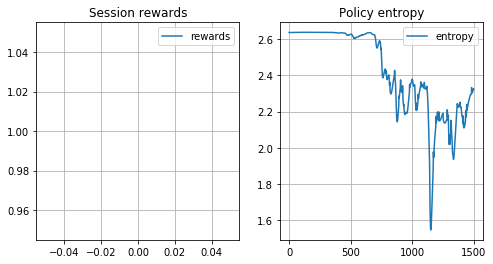

  2%|█                                                                         | 1501/100000 [03:43<7:01:55,  3.89it/s]

  2%|█                                                                         | 1502/100000 [03:43<5:49:58,  4.69it/s]

  2%|█                                                                         | 1503/100000 [03:43<5:14:52,  5.21it/s]

  2%|█                                                                         | 1504/100000 [03:44<4:52:45,  5.61it/s]

  2%|█                                                                         | 1505/100000 [03:44<4:32:51,  6.02it/s]

  2%|█                                                                         | 1506/100000 [03:44<4:16:27,  6.40it/s]

  2%|█                                                                         | 1507/100000 [03:44<4:05:57,  6.67it/s]

  2%|█                                                                         | 1508/100000 [03:44<4:03:32,  6.74it/s]

  2%|█                                                                         | 1509/100000 [03:44<4:00:51,  6.82it/s]

  2%|█                                                                         | 1510/100000 [03:44<3:57:00,  6.93it/s]

  2%|█                                                                         | 1511/100000 [03:45<3:56:17,  6.95it/s]

  2%|█                                                                         | 1512/100000 [03:45<3:59:42,  6.85it/s]

  2%|█                                                                         | 1513/100000 [03:45<3:58:10,  6.89it/s]

  2%|█                                                                         | 1514/100000 [03:45<3:55:07,  6.98it/s]

  2%|█                                                                         | 1515/100000 [03:45<3:50:02,  7.14it/s]

  2%|█                                                                         | 1516/100000 [03:45<3:53:51,  7.02it/s]

  2%|█                                                                         | 1517/100000 [03:45<3:50:38,  7.12it/s]

  2%|█                                                                         | 1518/100000 [03:46<3:51:48,  7.08it/s]

  2%|█                                                                         | 1519/100000 [03:46<3:51:10,  7.10it/s]

  2%|█                                                                         | 1520/100000 [03:46<3:50:13,  7.13it/s]

  2%|█▏                                                                        | 1521/100000 [03:46<3:53:29,  7.03it/s]

  2%|█▏                                                                        | 1522/100000 [03:46<3:53:19,  7.03it/s]

  2%|█▏                                                                        | 1523/100000 [03:46<3:49:15,  7.16it/s]

  2%|█▏                                                                        | 1524/100000 [03:46<3:51:20,  7.09it/s]

  2%|█▏                                                                        | 1525/100000 [03:47<3:51:19,  7.09it/s]

  2%|█▏                                                                        | 1526/100000 [03:47<3:51:18,  7.10it/s]

  2%|█▏                                                                        | 1527/100000 [03:47<3:50:18,  7.13it/s]

  2%|█▏                                                                        | 1528/100000 [03:47<3:53:03,  7.04it/s]

  2%|█▏                                                                        | 1529/100000 [03:47<3:54:59,  6.98it/s]

  2%|█▏                                                                        | 1530/100000 [03:47<3:49:26,  7.15it/s]

  2%|█▏                                                                        | 1531/100000 [03:47<3:48:30,  7.18it/s]

  2%|█▏                                                                        | 1532/100000 [03:48<3:47:51,  7.20it/s]

  2%|█▏                                                                        | 1533/100000 [03:48<3:48:23,  7.19it/s]

  2%|█▏                                                                        | 1534/100000 [03:48<3:49:14,  7.16it/s]

  2%|█▏                                                                        | 1535/100000 [03:48<3:51:19,  7.09it/s]

  2%|█▏                                                                        | 1536/100000 [03:48<3:49:20,  7.16it/s]

  2%|█▏                                                                        | 1537/100000 [03:48<3:50:24,  7.12it/s]

  2%|█▏                                                                        | 1538/100000 [03:48<3:50:09,  7.13it/s]

  2%|█▏                                                                        | 1539/100000 [03:49<3:52:27,  7.06it/s]

  2%|█▏                                                                        | 1540/100000 [03:49<3:54:33,  7.00it/s]

  2%|█▏                                                                        | 1541/100000 [03:49<3:52:05,  7.07it/s]

  2%|█▏                                                                        | 1542/100000 [03:49<3:53:47,  7.02it/s]

  2%|█▏                                                                        | 1543/100000 [03:49<3:50:04,  7.13it/s]

  2%|█▏                                                                        | 1544/100000 [03:49<3:50:25,  7.12it/s]

  2%|█▏                                                                        | 1545/100000 [03:49<3:54:06,  7.01it/s]

  2%|█▏                                                                        | 1546/100000 [03:50<3:51:16,  7.09it/s]

  2%|█▏                                                                        | 1547/100000 [03:50<3:52:44,  7.05it/s]

  2%|█▏                                                                        | 1548/100000 [03:50<3:47:51,  7.20it/s]

  2%|█▏                                                                        | 1549/100000 [03:50<3:46:24,  7.25it/s]

  2%|█▏                                                                        | 1550/100000 [03:50<3:47:50,  7.20it/s]

  2%|█▏                                                                        | 1551/100000 [03:50<3:47:52,  7.20it/s]

  2%|█▏                                                                        | 1552/100000 [03:50<3:47:24,  7.22it/s]

  2%|█▏                                                                        | 1553/100000 [03:50<3:49:02,  7.16it/s]

  2%|█▏                                                                        | 1554/100000 [03:51<3:53:07,  7.04it/s]

  2%|█▏                                                                        | 1555/100000 [03:51<3:54:01,  7.01it/s]

  2%|█▏                                                                        | 1556/100000 [03:51<3:53:10,  7.04it/s]

  2%|█▏                                                                        | 1557/100000 [03:51<3:49:08,  7.16it/s]

  2%|█▏                                                                        | 1558/100000 [03:51<3:51:43,  7.08it/s]

  2%|█▏                                                                        | 1559/100000 [03:51<3:52:03,  7.07it/s]

  2%|█▏                                                                        | 1560/100000 [03:51<3:50:49,  7.11it/s]

  2%|█▏                                                                        | 1561/100000 [03:52<3:46:59,  7.23it/s]

  2%|█▏                                                                        | 1562/100000 [03:52<3:45:47,  7.27it/s]

  2%|█▏                                                                        | 1563/100000 [03:52<3:43:58,  7.33it/s]

  2%|█▏                                                                        | 1564/100000 [03:52<3:43:11,  7.35it/s]

  2%|█▏                                                                        | 1565/100000 [03:52<3:43:07,  7.35it/s]

  2%|█▏                                                                        | 1566/100000 [03:52<3:48:00,  7.20it/s]

  2%|█▏                                                                        | 1567/100000 [03:52<3:56:49,  6.93it/s]

  2%|█▏                                                                        | 1568/100000 [03:53<3:52:10,  7.07it/s]

  2%|█▏                                                                        | 1569/100000 [03:53<3:51:23,  7.09it/s]

  2%|█▏                                                                        | 1570/100000 [03:53<3:47:52,  7.20it/s]

  2%|█▏                                                                        | 1571/100000 [03:53<3:48:22,  7.18it/s]

  2%|█▏                                                                        | 1572/100000 [03:53<3:47:14,  7.22it/s]

  2%|█▏                                                                        | 1573/100000 [03:53<3:48:54,  7.17it/s]

  2%|█▏                                                                        | 1574/100000 [03:53<3:47:07,  7.22it/s]

  2%|█▏                                                                        | 1575/100000 [03:54<3:46:22,  7.25it/s]

  2%|█▏                                                                        | 1576/100000 [03:54<3:50:45,  7.11it/s]

  2%|█▏                                                                        | 1577/100000 [03:54<3:50:23,  7.12it/s]

  2%|█▏                                                                        | 1578/100000 [03:54<3:46:40,  7.24it/s]

  2%|█▏                                                                        | 1579/100000 [03:54<3:43:06,  7.35it/s]

  2%|█▏                                                                        | 1580/100000 [03:54<3:46:00,  7.26it/s]

  2%|█▏                                                                        | 1581/100000 [03:54<3:48:32,  7.18it/s]

  2%|█▏                                                                        | 1582/100000 [03:55<3:46:51,  7.23it/s]

  2%|█▏                                                                        | 1583/100000 [03:55<3:47:39,  7.21it/s]

  2%|█▏                                                                        | 1584/100000 [03:55<3:49:11,  7.16it/s]

  2%|█▏                                                                        | 1585/100000 [03:55<3:54:41,  6.99it/s]

  2%|█▏                                                                        | 1586/100000 [03:55<3:50:10,  7.13it/s]

  2%|█▏                                                                        | 1587/100000 [03:55<3:48:59,  7.16it/s]

  2%|█▏                                                                        | 1588/100000 [03:55<3:46:40,  7.24it/s]

  2%|█▏                                                                        | 1589/100000 [03:55<3:44:04,  7.32it/s]

  2%|█▏                                                                        | 1590/100000 [03:56<3:47:40,  7.20it/s]

  2%|█▏                                                                        | 1591/100000 [03:56<3:45:45,  7.27it/s]

  2%|█▏                                                                        | 1592/100000 [03:56<3:46:22,  7.25it/s]

  2%|█▏                                                                        | 1593/100000 [03:56<3:50:45,  7.11it/s]

  2%|█▏                                                                        | 1594/100000 [03:56<3:53:19,  7.03it/s]

  2%|█▏                                                                        | 1595/100000 [03:56<3:51:11,  7.09it/s]

  2%|█▏                                                                        | 1596/100000 [03:56<3:49:41,  7.14it/s]

  2%|█▏                                                                        | 1597/100000 [03:57<3:52:34,  7.05it/s]

  2%|█▏                                                                        | 1598/100000 [03:57<3:51:38,  7.08it/s]

  2%|█▏                                                                        | 1599/100000 [03:57<3:49:30,  7.15it/s]

  2%|█▏                                                                        | 1600/100000 [03:57<3:55:23,  6.97it/s]

  2%|█▏                                                                        | 1601/100000 [03:57<3:51:38,  7.08it/s]

  2%|█▏                                                                        | 1602/100000 [03:57<3:51:58,  7.07it/s]

  2%|█▏                                                                        | 1603/100000 [03:57<3:49:15,  7.15it/s]

  2%|█▏                                                                        | 1604/100000 [03:58<3:53:44,  7.02it/s]

  2%|█▏                                                                        | 1605/100000 [03:58<3:55:53,  6.95it/s]

  2%|█▏                                                                        | 1606/100000 [03:58<3:54:27,  6.99it/s]

  2%|█▏                                                                        | 1607/100000 [03:58<3:52:27,  7.05it/s]

  2%|█▏                                                                        | 1608/100000 [03:58<3:51:03,  7.10it/s]

  2%|█▏                                                                        | 1609/100000 [03:58<3:45:10,  7.28it/s]

  2%|█▏                                                                        | 1610/100000 [03:58<3:46:56,  7.23it/s]

  2%|█▏                                                                        | 1611/100000 [03:59<3:46:12,  7.25it/s]

  2%|█▏                                                                        | 1612/100000 [03:59<3:48:39,  7.17it/s]

  2%|█▏                                                                        | 1613/100000 [03:59<3:48:23,  7.18it/s]

  2%|█▏                                                                        | 1614/100000 [03:59<3:45:45,  7.26it/s]

  2%|█▏                                                                        | 1615/100000 [03:59<3:41:27,  7.40it/s]

  2%|█▏                                                                        | 1616/100000 [03:59<3:43:21,  7.34it/s]

  2%|█▏                                                                        | 1617/100000 [03:59<3:43:41,  7.33it/s]

  2%|█▏                                                                        | 1618/100000 [04:00<3:49:50,  7.13it/s]

  2%|█▏                                                                        | 1619/100000 [04:00<3:49:13,  7.15it/s]

  2%|█▏                                                                        | 1620/100000 [04:00<3:48:17,  7.18it/s]

  2%|█▏                                                                        | 1621/100000 [04:00<3:52:04,  7.07it/s]

  2%|█▏                                                                        | 1622/100000 [04:00<3:50:46,  7.10it/s]

  2%|█▏                                                                        | 1623/100000 [04:00<3:43:58,  7.32it/s]

  2%|█▏                                                                        | 1624/100000 [04:00<3:48:03,  7.19it/s]

  2%|█▏                                                                        | 1625/100000 [04:01<3:53:22,  7.03it/s]

  2%|█▏                                                                        | 1626/100000 [04:01<3:52:40,  7.05it/s]

  2%|█▏                                                                        | 1627/100000 [04:01<3:53:39,  7.02it/s]

  2%|█▏                                                                        | 1628/100000 [04:01<3:54:21,  7.00it/s]

  2%|█▏                                                                        | 1629/100000 [04:01<3:54:49,  6.98it/s]

  2%|█▏                                                                        | 1630/100000 [04:01<3:59:05,  6.86it/s]

  2%|█▏                                                                        | 1631/100000 [04:01<4:03:33,  6.73it/s]

  2%|█▏                                                                        | 1632/100000 [04:02<4:08:38,  6.59it/s]

  2%|█▏                                                                        | 1633/100000 [04:02<4:09:45,  6.56it/s]

  2%|█▏                                                                        | 1634/100000 [04:02<4:09:32,  6.57it/s]

  2%|█▏                                                                        | 1635/100000 [04:02<4:09:23,  6.57it/s]

  2%|█▏                                                                        | 1636/100000 [04:02<4:14:41,  6.44it/s]

  2%|█▏                                                                        | 1637/100000 [04:02<4:17:54,  6.36it/s]

  2%|█▏                                                                        | 1638/100000 [04:03<4:17:42,  6.36it/s]

  2%|█▏                                                                        | 1639/100000 [04:03<4:23:27,  6.22it/s]

  2%|█▏                                                                        | 1640/100000 [04:03<4:20:06,  6.30it/s]

  2%|█▏                                                                        | 1641/100000 [04:03<4:23:10,  6.23it/s]

  2%|█▏                                                                        | 1642/100000 [04:03<4:18:55,  6.33it/s]

  2%|█▏                                                                        | 1643/100000 [04:03<4:13:59,  6.45it/s]

  2%|█▏                                                                        | 1644/100000 [04:03<4:03:39,  6.73it/s]

  2%|█▏                                                                        | 1645/100000 [04:04<4:03:47,  6.72it/s]

  2%|█▏                                                                        | 1646/100000 [04:04<4:14:41,  6.44it/s]

  2%|█▏                                                                        | 1647/100000 [04:04<4:17:54,  6.36it/s]

  2%|█▏                                                                        | 1648/100000 [04:04<4:28:30,  6.10it/s]

  2%|█▏                                                                        | 1649/100000 [04:04<4:29:32,  6.08it/s]

  2%|█▏                                                                        | 1650/100000 [04:04<4:34:40,  5.97it/s]

  2%|█▏                                                                        | 1651/100000 [04:05<4:29:55,  6.07it/s]

  2%|█▏                                                                        | 1652/100000 [04:05<4:31:01,  6.05it/s]

  2%|█▏                                                                        | 1653/100000 [04:05<4:32:16,  6.02it/s]

  2%|█▏                                                                        | 1654/100000 [04:05<4:32:39,  6.01it/s]

  2%|█▏                                                                        | 1655/100000 [04:05<4:30:58,  6.05it/s]

  2%|█▏                                                                        | 1656/100000 [04:05<4:29:17,  6.09it/s]

  2%|█▏                                                                        | 1657/100000 [04:06<4:12:52,  6.48it/s]

  2%|█▏                                                                        | 1658/100000 [04:06<4:01:23,  6.79it/s]

  2%|█▏                                                                        | 1659/100000 [04:06<3:53:50,  7.01it/s]

  2%|█▏                                                                        | 1660/100000 [04:06<3:49:32,  7.14it/s]

  2%|█▏                                                                        | 1661/100000 [04:06<3:48:29,  7.17it/s]

  2%|█▏                                                                        | 1662/100000 [04:06<3:53:39,  7.01it/s]

  2%|█▏                                                                        | 1663/100000 [04:06<3:55:17,  6.97it/s]

  2%|█▏                                                                        | 1664/100000 [04:07<3:50:33,  7.11it/s]

  2%|█▏                                                                        | 1665/100000 [04:07<3:49:41,  7.14it/s]

  2%|█▏                                                                        | 1666/100000 [04:07<3:48:35,  7.17it/s]

  2%|█▏                                                                        | 1667/100000 [04:07<3:48:48,  7.16it/s]

  2%|█▏                                                                        | 1668/100000 [04:07<3:46:29,  7.24it/s]

  2%|█▏                                                                        | 1669/100000 [04:07<3:44:53,  7.29it/s]

  2%|█▏                                                                        | 1670/100000 [04:07<3:50:08,  7.12it/s]

  2%|█▏                                                                        | 1671/100000 [04:08<3:53:49,  7.01it/s]

  2%|█▏                                                                        | 1672/100000 [04:08<3:57:22,  6.90it/s]

  2%|█▏                                                                        | 1673/100000 [04:08<3:53:28,  7.02it/s]

  2%|█▏                                                                        | 1674/100000 [04:08<3:51:43,  7.07it/s]

  2%|█▏                                                                        | 1675/100000 [04:08<3:54:55,  6.98it/s]

  2%|█▏                                                                        | 1676/100000 [04:08<3:48:19,  7.18it/s]

  2%|█▏                                                                        | 1677/100000 [04:08<3:49:35,  7.14it/s]

  2%|█▏                                                                        | 1678/100000 [04:08<3:46:33,  7.23it/s]

  2%|█▏                                                                        | 1679/100000 [04:09<3:50:48,  7.10it/s]

  2%|█▏                                                                        | 1680/100000 [04:09<3:48:22,  7.18it/s]

  2%|█▏                                                                        | 1681/100000 [04:09<3:50:07,  7.12it/s]

  2%|█▏                                                                        | 1682/100000 [04:09<3:49:52,  7.13it/s]

  2%|█▏                                                                        | 1683/100000 [04:09<3:49:11,  7.15it/s]

  2%|█▏                                                                        | 1684/100000 [04:09<3:45:17,  7.27it/s]

  2%|█▏                                                                        | 1685/100000 [04:09<3:45:29,  7.27it/s]

  2%|█▏                                                                        | 1686/100000 [04:10<3:46:37,  7.23it/s]

  2%|█▏                                                                        | 1687/100000 [04:10<3:49:22,  7.14it/s]

  2%|█▏                                                                        | 1688/100000 [04:10<3:50:49,  7.10it/s]

  2%|█▏                                                                        | 1689/100000 [04:10<3:51:49,  7.07it/s]

  2%|█▎                                                                        | 1690/100000 [04:10<3:53:30,  7.02it/s]

  2%|█▎                                                                        | 1691/100000 [04:10<3:50:15,  7.12it/s]

  2%|█▎                                                                        | 1692/100000 [04:10<3:54:22,  6.99it/s]

  2%|█▎                                                                        | 1693/100000 [04:11<3:50:52,  7.10it/s]

  2%|█▎                                                                        | 1694/100000 [04:11<3:52:21,  7.05it/s]

  2%|█▎                                                                        | 1695/100000 [04:11<3:49:27,  7.14it/s]

  2%|█▎                                                                        | 1696/100000 [04:11<3:48:24,  7.17it/s]

  2%|█▎                                                                        | 1697/100000 [04:11<3:45:42,  7.26it/s]

  2%|█▎                                                                        | 1698/100000 [04:11<3:46:45,  7.22it/s]

  2%|█▎                                                                        | 1699/100000 [04:11<3:44:04,  7.31it/s]

  2%|█▎                                                                        | 1700/100000 [04:12<3:43:39,  7.33it/s]

  2%|█▎                                                                        | 1701/100000 [04:12<3:44:49,  7.29it/s]

  2%|█▎                                                                        | 1702/100000 [04:12<3:46:09,  7.24it/s]

  2%|█▎                                                                        | 1703/100000 [04:12<3:53:56,  7.00it/s]

  2%|█▎                                                                        | 1704/100000 [04:12<3:50:33,  7.11it/s]

  2%|█▎                                                                        | 1705/100000 [04:12<3:49:40,  7.13it/s]

  2%|█▎                                                                        | 1706/100000 [04:12<3:43:38,  7.33it/s]

  2%|█▎                                                                        | 1707/100000 [04:13<3:48:15,  7.18it/s]

  2%|█▎                                                                        | 1708/100000 [04:13<3:49:02,  7.15it/s]

  2%|█▎                                                                        | 1709/100000 [04:13<3:47:07,  7.21it/s]

  2%|█▎                                                                        | 1710/100000 [04:13<3:47:44,  7.19it/s]

  2%|█▎                                                                        | 1711/100000 [04:13<3:48:11,  7.18it/s]

  2%|█▎                                                                        | 1712/100000 [04:13<3:50:27,  7.11it/s]

  2%|█▎                                                                        | 1713/100000 [04:13<3:52:02,  7.06it/s]

  2%|█▎                                                                        | 1714/100000 [04:14<3:50:41,  7.10it/s]

  2%|█▎                                                                        | 1715/100000 [04:14<3:53:11,  7.02it/s]

  2%|█▎                                                                        | 1716/100000 [04:14<3:52:58,  7.03it/s]

  2%|█▎                                                                        | 1717/100000 [04:14<3:50:21,  7.11it/s]

  2%|█▎                                                                        | 1718/100000 [04:14<3:46:05,  7.25it/s]

  2%|█▎                                                                        | 1719/100000 [04:14<3:48:29,  7.17it/s]

  2%|█▎                                                                        | 1720/100000 [04:14<3:53:36,  7.01it/s]

  2%|█▎                                                                        | 1721/100000 [04:15<3:53:45,  7.01it/s]

  2%|█▎                                                                        | 1722/100000 [04:15<3:57:46,  6.89it/s]

  2%|█▎                                                                        | 1723/100000 [04:15<3:55:12,  6.96it/s]

  2%|█▎                                                                        | 1724/100000 [04:15<3:54:22,  6.99it/s]

  2%|█▎                                                                        | 1725/100000 [04:15<3:54:17,  6.99it/s]

  2%|█▎                                                                        | 1726/100000 [04:15<3:52:45,  7.04it/s]

  2%|█▎                                                                        | 1727/100000 [04:15<3:49:42,  7.13it/s]

  2%|█▎                                                                        | 1728/100000 [04:16<3:47:05,  7.21it/s]

  2%|█▎                                                                        | 1729/100000 [04:16<3:51:08,  7.09it/s]

  2%|█▎                                                                        | 1730/100000 [04:16<3:51:02,  7.09it/s]

  2%|█▎                                                                        | 1731/100000 [04:16<3:49:00,  7.15it/s]

  2%|█▎                                                                        | 1732/100000 [04:16<3:50:31,  7.10it/s]

  2%|█▎                                                                        | 1733/100000 [04:16<3:48:38,  7.16it/s]

  2%|█▎                                                                        | 1734/100000 [04:16<3:50:15,  7.11it/s]

  2%|█▎                                                                        | 1735/100000 [04:16<3:50:54,  7.09it/s]

  2%|█▎                                                                        | 1736/100000 [04:17<3:50:52,  7.09it/s]

  2%|█▎                                                                        | 1737/100000 [04:17<3:51:49,  7.06it/s]

  2%|█▎                                                                        | 1738/100000 [04:17<3:49:32,  7.13it/s]

  2%|█▎                                                                        | 1739/100000 [04:17<3:47:57,  7.18it/s]

  2%|█▎                                                                        | 1740/100000 [04:17<3:51:15,  7.08it/s]

  2%|█▎                                                                        | 1741/100000 [04:17<3:46:11,  7.24it/s]

  2%|█▎                                                                        | 1742/100000 [04:17<3:48:33,  7.17it/s]

  2%|█▎                                                                        | 1743/100000 [04:18<3:48:43,  7.16it/s]

  2%|█▎                                                                        | 1744/100000 [04:18<3:47:22,  7.20it/s]

  2%|█▎                                                                        | 1745/100000 [04:18<3:48:23,  7.17it/s]

  2%|█▎                                                                        | 1746/100000 [04:18<3:46:38,  7.23it/s]

  2%|█▎                                                                        | 1747/100000 [04:18<3:44:55,  7.28it/s]

  2%|█▎                                                                        | 1748/100000 [04:18<3:47:10,  7.21it/s]

  2%|█▎                                                                        | 1749/100000 [04:18<3:48:14,  7.17it/s]

  2%|█▎                                                                        | 1750/100000 [04:19<3:51:27,  7.07it/s]

  2%|█▎                                                                        | 1751/100000 [04:19<3:50:44,  7.10it/s]

  2%|█▎                                                                        | 1752/100000 [04:19<3:50:44,  7.10it/s]

  2%|█▎                                                                        | 1753/100000 [04:19<3:54:40,  6.98it/s]

  2%|█▎                                                                        | 1754/100000 [04:19<3:55:27,  6.95it/s]

  2%|█▎                                                                        | 1755/100000 [04:19<3:46:11,  7.24it/s]

  2%|█▎                                                                        | 1756/100000 [04:19<3:49:30,  7.13it/s]

  2%|█▎                                                                        | 1757/100000 [04:20<3:46:56,  7.22it/s]

  2%|█▎                                                                        | 1758/100000 [04:20<3:48:04,  7.18it/s]

  2%|█▎                                                                        | 1759/100000 [04:20<3:47:53,  7.18it/s]

  2%|█▎                                                                        | 1760/100000 [04:20<3:50:42,  7.10it/s]

  2%|█▎                                                                        | 1761/100000 [04:20<3:49:43,  7.13it/s]

  2%|█▎                                                                        | 1762/100000 [04:20<3:49:02,  7.15it/s]

  2%|█▎                                                                        | 1763/100000 [04:20<3:51:30,  7.07it/s]

  2%|█▎                                                                        | 1764/100000 [04:21<3:59:07,  6.85it/s]

  2%|█▎                                                                        | 1765/100000 [04:21<3:54:38,  6.98it/s]

  2%|█▎                                                                        | 1766/100000 [04:21<3:51:59,  7.06it/s]

  2%|█▎                                                                        | 1767/100000 [04:21<3:49:08,  7.14it/s]

  2%|█▎                                                                        | 1768/100000 [04:21<3:50:06,  7.11it/s]

  2%|█▎                                                                        | 1769/100000 [04:21<3:53:13,  7.02it/s]

  2%|█▎                                                                        | 1770/100000 [04:21<3:54:55,  6.97it/s]

  2%|█▎                                                                        | 1771/100000 [04:22<3:53:39,  7.01it/s]

  2%|█▎                                                                        | 1772/100000 [04:22<3:53:45,  7.00it/s]

  2%|█▎                                                                        | 1773/100000 [04:22<3:50:52,  7.09it/s]

  2%|█▎                                                                        | 1774/100000 [04:22<3:56:13,  6.93it/s]

  2%|█▎                                                                        | 1775/100000 [04:22<3:49:09,  7.14it/s]

  2%|█▎                                                                        | 1776/100000 [04:22<3:54:31,  6.98it/s]

  2%|█▎                                                                        | 1777/100000 [04:22<3:51:54,  7.06it/s]

  2%|█▎                                                                        | 1778/100000 [04:23<3:56:56,  6.91it/s]

  2%|█▎                                                                        | 1779/100000 [04:23<3:54:04,  6.99it/s]

  2%|█▎                                                                        | 1780/100000 [04:23<3:54:02,  6.99it/s]

  2%|█▎                                                                        | 1781/100000 [04:23<3:52:02,  7.05it/s]

  2%|█▎                                                                        | 1782/100000 [04:23<3:49:40,  7.13it/s]

  2%|█▎                                                                        | 1783/100000 [04:23<3:52:55,  7.03it/s]

  2%|█▎                                                                        | 1784/100000 [04:23<3:51:45,  7.06it/s]

  2%|█▎                                                                        | 1785/100000 [04:24<3:47:00,  7.21it/s]

  2%|█▎                                                                        | 1786/100000 [04:24<3:44:40,  7.29it/s]

  2%|█▎                                                                        | 1787/100000 [04:24<3:48:55,  7.15it/s]

  2%|█▎                                                                        | 1788/100000 [04:24<3:54:21,  6.98it/s]

  2%|█▎                                                                        | 1789/100000 [04:24<3:48:20,  7.17it/s]

  2%|█▎                                                                        | 1790/100000 [04:24<3:45:06,  7.27it/s]

  2%|█▎                                                                        | 1791/100000 [04:24<3:46:16,  7.23it/s]

  2%|█▎                                                                        | 1792/100000 [04:25<3:49:33,  7.13it/s]

  2%|█▎                                                                        | 1793/100000 [04:25<3:56:15,  6.93it/s]

  2%|█▎                                                                        | 1794/100000 [04:25<3:56:32,  6.92it/s]

  2%|█▎                                                                        | 1795/100000 [04:25<3:54:16,  6.99it/s]

  2%|█▎                                                                        | 1796/100000 [04:25<3:55:09,  6.96it/s]

  2%|█▎                                                                        | 1797/100000 [04:25<3:55:45,  6.94it/s]

  2%|█▎                                                                        | 1798/100000 [04:25<3:51:16,  7.08it/s]

  2%|█▎                                                                        | 1799/100000 [04:26<3:47:39,  7.19it/s]

  2%|█▎                                                                        | 1800/100000 [04:26<3:48:03,  7.18it/s]

  2%|█▎                                                                        | 1801/100000 [04:26<3:50:47,  7.09it/s]

  2%|█▎                                                                        | 1802/100000 [04:26<3:44:51,  7.28it/s]

  2%|█▎                                                                        | 1803/100000 [04:26<3:45:06,  7.27it/s]

  2%|█▎                                                                        | 1804/100000 [04:26<3:49:42,  7.12it/s]

  2%|█▎                                                                        | 1805/100000 [04:26<3:49:29,  7.13it/s]

  2%|█▎                                                                        | 1806/100000 [04:26<3:53:15,  7.02it/s]

  2%|█▎                                                                        | 1807/100000 [04:27<3:52:28,  7.04it/s]

  2%|█▎                                                                        | 1808/100000 [04:27<3:54:51,  6.97it/s]

  2%|█▎                                                                        | 1809/100000 [04:27<3:54:33,  6.98it/s]

  2%|█▎                                                                        | 1810/100000 [04:27<3:57:47,  6.88it/s]

  2%|█▎                                                                        | 1811/100000 [04:27<3:58:34,  6.86it/s]

  2%|█▎                                                                        | 1812/100000 [04:27<3:56:11,  6.93it/s]

  2%|█▎                                                                        | 1813/100000 [04:28<3:54:01,  6.99it/s]

  2%|█▎                                                                        | 1814/100000 [04:28<3:52:00,  7.05it/s]

  2%|█▎                                                                        | 1815/100000 [04:28<3:53:03,  7.02it/s]

  2%|█▎                                                                        | 1816/100000 [04:28<3:52:19,  7.04it/s]

  2%|█▎                                                                        | 1817/100000 [04:28<3:51:18,  7.07it/s]

  2%|█▎                                                                        | 1818/100000 [04:28<3:50:36,  7.10it/s]

  2%|█▎                                                                        | 1819/100000 [04:28<3:49:37,  7.13it/s]

  2%|█▎                                                                        | 1820/100000 [04:28<3:48:26,  7.16it/s]

  2%|█▎                                                                        | 1821/100000 [04:29<3:50:33,  7.10it/s]

  2%|█▎                                                                        | 1822/100000 [04:29<3:53:00,  7.02it/s]

  2%|█▎                                                                        | 1823/100000 [04:29<3:58:39,  6.86it/s]

  2%|█▎                                                                        | 1824/100000 [04:29<4:02:36,  6.74it/s]

  2%|█▎                                                                        | 1825/100000 [04:29<4:01:27,  6.78it/s]

  2%|█▎                                                                        | 1826/100000 [04:29<3:59:39,  6.83it/s]

  2%|█▎                                                                        | 1827/100000 [04:30<4:02:49,  6.74it/s]

  2%|█▎                                                                        | 1828/100000 [04:30<3:59:38,  6.83it/s]

  2%|█▎                                                                        | 1829/100000 [04:30<3:58:52,  6.85it/s]

  2%|█▎                                                                        | 1830/100000 [04:30<4:00:18,  6.81it/s]

  2%|█▎                                                                        | 1831/100000 [04:30<3:56:24,  6.92it/s]

  2%|█▎                                                                        | 1832/100000 [04:30<4:02:29,  6.75it/s]

  2%|█▎                                                                        | 1833/100000 [04:30<4:00:52,  6.79it/s]

  2%|█▎                                                                        | 1834/100000 [04:31<4:02:41,  6.74it/s]

  2%|█▎                                                                        | 1835/100000 [04:31<3:58:03,  6.87it/s]

  2%|█▎                                                                        | 1836/100000 [04:31<4:00:13,  6.81it/s]

  2%|█▎                                                                        | 1837/100000 [04:31<4:05:39,  6.66it/s]

  2%|█▎                                                                        | 1838/100000 [04:31<4:09:57,  6.55it/s]

  2%|█▎                                                                        | 1839/100000 [04:31<4:12:57,  6.47it/s]

  2%|█▎                                                                        | 1840/100000 [04:31<4:24:52,  6.18it/s]

  2%|█▎                                                                        | 1841/100000 [04:32<4:28:18,  6.10it/s]

  2%|█▎                                                                        | 1842/100000 [04:32<4:28:44,  6.09it/s]

  2%|█▎                                                                        | 1843/100000 [04:32<4:30:31,  6.05it/s]

  2%|█▎                                                                        | 1844/100000 [04:32<4:27:50,  6.11it/s]

  2%|█▎                                                                        | 1845/100000 [04:32<4:22:32,  6.23it/s]

  2%|█▎                                                                        | 1846/100000 [04:32<4:22:25,  6.23it/s]

  2%|█▎                                                                        | 1847/100000 [04:33<4:27:04,  6.13it/s]

  2%|█▎                                                                        | 1848/100000 [04:33<4:21:30,  6.26it/s]

  2%|█▎                                                                        | 1849/100000 [04:33<4:47:31,  5.69it/s]

  2%|█▎                                                                        | 1850/100000 [04:33<5:00:20,  5.45it/s]

  2%|█▎                                                                        | 1851/100000 [04:33<4:59:29,  5.46it/s]

  2%|█▎                                                                        | 1852/100000 [04:34<5:07:14,  5.32it/s]

  2%|█▎                                                                        | 1853/100000 [04:34<4:53:03,  5.58it/s]

  2%|█▎                                                                        | 1854/100000 [04:34<4:36:44,  5.91it/s]

  2%|█▎                                                                        | 1855/100000 [04:34<4:27:48,  6.11it/s]

  2%|█▎                                                                        | 1856/100000 [04:34<4:25:26,  6.16it/s]

  2%|█▎                                                                        | 1857/100000 [04:34<4:28:56,  6.08it/s]

  2%|█▎                                                                        | 1858/100000 [04:35<4:28:11,  6.10it/s]

  2%|█▍                                                                        | 1859/100000 [04:35<4:18:21,  6.33it/s]

  2%|█▍                                                                        | 1860/100000 [04:35<4:17:21,  6.36it/s]

  2%|█▍                                                                        | 1861/100000 [04:35<4:07:49,  6.60it/s]

  2%|█▍                                                                        | 1862/100000 [04:35<4:08:00,  6.59it/s]

  2%|█▍                                                                        | 1863/100000 [04:35<4:12:04,  6.49it/s]

  2%|█▍                                                                        | 1864/100000 [04:35<4:05:06,  6.67it/s]

  2%|█▍                                                                        | 1865/100000 [04:36<3:59:14,  6.84it/s]

  2%|█▍                                                                        | 1866/100000 [04:36<3:55:08,  6.96it/s]

  2%|█▍                                                                        | 1867/100000 [04:36<3:52:45,  7.03it/s]

  2%|█▍                                                                        | 1868/100000 [04:36<3:55:30,  6.94it/s]

  2%|█▍                                                                        | 1869/100000 [04:36<3:51:32,  7.06it/s]

  2%|█▍                                                                        | 1870/100000 [04:36<4:11:49,  6.49it/s]

  2%|█▍                                                                        | 1871/100000 [04:36<4:17:40,  6.35it/s]

  2%|█▍                                                                        | 1872/100000 [04:37<4:18:49,  6.32it/s]

  2%|█▍                                                                        | 1873/100000 [04:37<4:20:07,  6.29it/s]

  2%|█▍                                                                        | 1874/100000 [04:37<4:22:00,  6.24it/s]

  2%|█▍                                                                        | 1875/100000 [04:37<4:21:51,  6.25it/s]

  2%|█▍                                                                        | 1876/100000 [04:37<4:24:41,  6.18it/s]

  2%|█▍                                                                        | 1877/100000 [04:37<4:24:43,  6.18it/s]

  2%|█▍                                                                        | 1878/100000 [04:38<4:27:40,  6.11it/s]

  2%|█▍                                                                        | 1879/100000 [04:38<4:35:08,  5.94it/s]

  2%|█▍                                                                        | 1880/100000 [04:38<4:39:22,  5.85it/s]

  2%|█▍                                                                        | 1881/100000 [04:38<4:38:55,  5.86it/s]

  2%|█▍                                                                        | 1882/100000 [04:38<4:34:40,  5.95it/s]

  2%|█▍                                                                        | 1883/100000 [04:38<4:43:27,  5.77it/s]

  2%|█▍                                                                        | 1884/100000 [04:39<4:48:08,  5.68it/s]

  2%|█▍                                                                        | 1885/100000 [04:39<4:42:35,  5.79it/s]

  2%|█▍                                                                        | 1886/100000 [04:39<4:37:14,  5.90it/s]

  2%|█▍                                                                        | 1887/100000 [04:39<4:34:57,  5.95it/s]

  2%|█▍                                                                        | 1888/100000 [04:39<4:20:07,  6.29it/s]

  2%|█▍                                                                        | 1889/100000 [04:39<4:15:08,  6.41it/s]

  2%|█▍                                                                        | 1890/100000 [04:40<4:20:57,  6.27it/s]

  2%|█▍                                                                        | 1891/100000 [04:40<4:26:01,  6.15it/s]

  2%|█▍                                                                        | 1892/100000 [04:40<4:34:56,  5.95it/s]

  2%|█▍                                                                        | 1893/100000 [04:40<4:39:14,  5.86it/s]

  2%|█▍                                                                        | 1894/100000 [04:40<4:44:11,  5.75it/s]

  2%|█▍                                                                        | 1895/100000 [04:40<4:41:17,  5.81it/s]

  2%|█▍                                                                        | 1896/100000 [04:41<4:38:46,  5.87it/s]

  2%|█▍                                                                        | 1897/100000 [04:41<4:44:21,  5.75it/s]

  2%|█▍                                                                        | 1898/100000 [04:41<4:55:34,  5.53it/s]

  2%|█▍                                                                        | 1899/100000 [04:41<5:00:02,  5.45it/s]

  2%|█▍                                                                        | 1900/100000 [04:41<5:06:06,  5.34it/s]

  2%|█▍                                                                        | 1901/100000 [04:42<4:51:14,  5.61it/s]

  2%|█▍                                                                        | 1902/100000 [04:42<4:36:24,  5.91it/s]

  2%|█▍                                                                        | 1903/100000 [04:42<4:25:03,  6.17it/s]

  2%|█▍                                                                        | 1904/100000 [04:42<4:25:26,  6.16it/s]

  2%|█▍                                                                        | 1905/100000 [04:42<4:23:15,  6.21it/s]

  2%|█▍                                                                        | 1906/100000 [04:42<4:13:53,  6.44it/s]

  2%|█▍                                                                        | 1907/100000 [04:42<4:13:41,  6.44it/s]

  2%|█▍                                                                        | 1908/100000 [04:43<4:08:10,  6.59it/s]

  2%|█▍                                                                        | 1909/100000 [04:43<4:00:22,  6.80it/s]

  2%|█▍                                                                        | 1910/100000 [04:43<3:57:52,  6.87it/s]

  2%|█▍                                                                        | 1911/100000 [04:43<3:57:05,  6.90it/s]

  2%|█▍                                                                        | 1912/100000 [04:43<3:53:06,  7.01it/s]

  2%|█▍                                                                        | 1913/100000 [04:43<3:50:19,  7.10it/s]

  2%|█▍                                                                        | 1914/100000 [04:43<3:51:48,  7.05it/s]

  2%|█▍                                                                        | 1915/100000 [04:44<3:52:21,  7.04it/s]

  2%|█▍                                                                        | 1916/100000 [04:44<3:46:01,  7.23it/s]

  2%|█▍                                                                        | 1917/100000 [04:44<4:04:28,  6.69it/s]

  2%|█▍                                                                        | 1918/100000 [04:44<4:02:41,  6.74it/s]

  2%|█▍                                                                        | 1919/100000 [04:44<3:55:33,  6.94it/s]

  2%|█▍                                                                        | 1920/100000 [04:44<3:53:59,  6.99it/s]

  2%|█▍                                                                        | 1921/100000 [04:44<3:50:56,  7.08it/s]

  2%|█▍                                                                        | 1922/100000 [04:45<3:52:43,  7.02it/s]

  2%|█▍                                                                        | 1923/100000 [04:45<3:52:59,  7.02it/s]

  2%|█▍                                                                        | 1924/100000 [04:45<3:49:15,  7.13it/s]

  2%|█▍                                                                        | 1925/100000 [04:45<3:53:59,  6.99it/s]

  2%|█▍                                                                        | 1926/100000 [04:45<3:50:56,  7.08it/s]

  2%|█▍                                                                        | 1927/100000 [04:45<3:49:17,  7.13it/s]

  2%|█▍                                                                        | 1928/100000 [04:45<3:45:40,  7.24it/s]

  2%|█▍                                                                        | 1929/100000 [04:46<3:48:32,  7.15it/s]

  2%|█▍                                                                        | 1930/100000 [04:46<3:45:09,  7.26it/s]

  2%|█▍                                                                        | 1931/100000 [04:46<3:47:41,  7.18it/s]

  2%|█▍                                                                        | 1932/100000 [04:46<3:46:31,  7.22it/s]

  2%|█▍                                                                        | 1933/100000 [04:46<3:42:16,  7.35it/s]

  2%|█▍                                                                        | 1934/100000 [04:46<3:42:13,  7.35it/s]

  2%|█▍                                                                        | 1935/100000 [04:46<3:40:14,  7.42it/s]

  2%|█▍                                                                        | 1936/100000 [04:47<3:44:14,  7.29it/s]

  2%|█▍                                                                        | 1937/100000 [04:47<3:46:03,  7.23it/s]

  2%|█▍                                                                        | 1938/100000 [04:47<3:46:21,  7.22it/s]

  2%|█▍                                                                        | 1939/100000 [04:47<3:45:05,  7.26it/s]

  2%|█▍                                                                        | 1940/100000 [04:47<3:43:42,  7.31it/s]

  2%|█▍                                                                        | 1941/100000 [04:47<3:43:43,  7.30it/s]

  2%|█▍                                                                        | 1942/100000 [04:47<3:47:39,  7.18it/s]

  2%|█▍                                                                        | 1943/100000 [04:48<3:46:00,  7.23it/s]

  2%|█▍                                                                        | 1944/100000 [04:48<3:48:16,  7.16it/s]

  2%|█▍                                                                        | 1945/100000 [04:48<3:53:17,  7.01it/s]

  2%|█▍                                                                        | 1946/100000 [04:48<3:48:28,  7.15it/s]

  2%|█▍                                                                        | 1947/100000 [04:48<3:53:54,  6.99it/s]

  2%|█▍                                                                        | 1948/100000 [04:48<3:51:50,  7.05it/s]

  2%|█▍                                                                        | 1949/100000 [04:48<3:50:53,  7.08it/s]

  2%|█▍                                                                        | 1950/100000 [04:49<3:54:37,  6.97it/s]

  2%|█▍                                                                        | 1951/100000 [04:49<3:55:46,  6.93it/s]

  2%|█▍                                                                        | 1952/100000 [04:49<3:53:08,  7.01it/s]

  2%|█▍                                                                        | 1953/100000 [04:49<3:52:46,  7.02it/s]

  2%|█▍                                                                        | 1954/100000 [04:49<3:53:58,  6.98it/s]

  2%|█▍                                                                        | 1955/100000 [04:49<3:51:53,  7.05it/s]

  2%|█▍                                                                        | 1956/100000 [04:49<3:45:31,  7.25it/s]

  2%|█▍                                                                        | 1957/100000 [04:50<3:50:22,  7.09it/s]

  2%|█▍                                                                        | 1958/100000 [04:50<3:52:47,  7.02it/s]

  2%|█▍                                                                        | 1959/100000 [04:50<3:52:01,  7.04it/s]

  2%|█▍                                                                        | 1960/100000 [04:50<3:58:50,  6.84it/s]

  2%|█▍                                                                        | 1961/100000 [04:50<3:57:14,  6.89it/s]

  2%|█▍                                                                        | 1962/100000 [04:50<3:51:43,  7.05it/s]

  2%|█▍                                                                        | 1963/100000 [04:50<3:53:14,  7.01it/s]

  2%|█▍                                                                        | 1964/100000 [04:51<3:53:48,  6.99it/s]

  2%|█▍                                                                        | 1965/100000 [04:51<3:53:13,  7.01it/s]

  2%|█▍                                                                        | 1966/100000 [04:51<3:50:22,  7.09it/s]

  2%|█▍                                                                        | 1967/100000 [04:51<3:49:21,  7.12it/s]

  2%|█▍                                                                        | 1968/100000 [04:51<3:56:58,  6.89it/s]

  2%|█▍                                                                        | 1969/100000 [04:51<3:58:22,  6.85it/s]

  2%|█▍                                                                        | 1970/100000 [04:51<3:52:59,  7.01it/s]

  2%|█▍                                                                        | 1971/100000 [04:52<3:50:12,  7.10it/s]

  2%|█▍                                                                        | 1972/100000 [04:52<3:47:45,  7.17it/s]

  2%|█▍                                                                        | 1973/100000 [04:52<3:45:33,  7.24it/s]

  2%|█▍                                                                        | 1974/100000 [04:52<3:46:28,  7.21it/s]

  2%|█▍                                                                        | 1975/100000 [04:52<3:45:08,  7.26it/s]

  2%|█▍                                                                        | 1976/100000 [04:52<3:43:14,  7.32it/s]

  2%|█▍                                                                        | 1977/100000 [04:52<3:42:53,  7.33it/s]

  2%|█▍                                                                        | 1978/100000 [04:52<3:48:01,  7.16it/s]

  2%|█▍                                                                        | 1979/100000 [04:53<3:48:11,  7.16it/s]

  2%|█▍                                                                        | 1980/100000 [04:53<3:50:45,  7.08it/s]

  2%|█▍                                                                        | 1981/100000 [04:53<3:49:36,  7.11it/s]

  2%|█▍                                                                        | 1982/100000 [04:53<3:49:47,  7.11it/s]

  2%|█▍                                                                        | 1983/100000 [04:53<3:47:57,  7.17it/s]

  2%|█▍                                                                        | 1984/100000 [04:53<3:48:08,  7.16it/s]

  2%|█▍                                                                        | 1985/100000 [04:53<3:48:15,  7.16it/s]

  2%|█▍                                                                        | 1986/100000 [04:54<3:48:21,  7.15it/s]

  2%|█▍                                                                        | 1987/100000 [04:54<3:44:59,  7.26it/s]

  2%|█▍                                                                        | 1988/100000 [04:54<3:44:06,  7.29it/s]

  2%|█▍                                                                        | 1989/100000 [04:54<3:42:00,  7.36it/s]

  2%|█▍                                                                        | 1990/100000 [04:54<3:43:28,  7.31it/s]

  2%|█▍                                                                        | 1991/100000 [04:54<3:41:05,  7.39it/s]

  2%|█▍                                                                        | 1992/100000 [04:54<3:38:54,  7.46it/s]

  2%|█▍                                                                        | 1993/100000 [04:55<3:41:48,  7.36it/s]

  2%|█▍                                                                        | 1994/100000 [04:55<3:46:16,  7.22it/s]

  2%|█▍                                                                        | 1995/100000 [04:55<3:44:59,  7.26it/s]

  2%|█▍                                                                        | 1996/100000 [04:55<3:42:08,  7.35it/s]

  2%|█▍                                                                        | 1997/100000 [04:55<3:46:01,  7.23it/s]

  2%|█▍                                                                        | 1998/100000 [04:55<3:44:48,  7.27it/s]

  2%|█▍                                                                        | 1999/100000 [04:55<3:44:27,  7.28it/s]

  2%|█▍                                                                        | 2000/100000 [04:56<3:48:07,  7.16it/s]

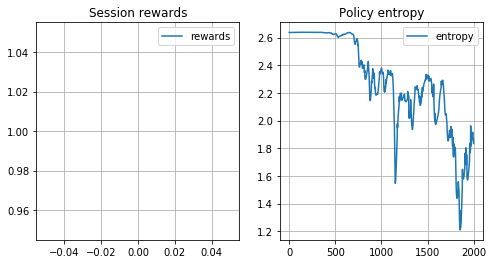

  2%|█▍                                                                        | 2001/100000 [04:56<6:57:16,  3.91it/s]

  2%|█▍                                                                        | 2002/100000 [04:56<5:50:22,  4.66it/s]

  2%|█▍                                                                        | 2003/100000 [04:56<5:22:37,  5.06it/s]

  2%|█▍                                                                        | 2004/100000 [04:56<4:57:19,  5.49it/s]

  2%|█▍                                                                        | 2005/100000 [04:57<4:35:42,  5.92it/s]

  2%|█▍                                                                        | 2006/100000 [04:57<4:23:59,  6.19it/s]

  2%|█▍                                                                        | 2007/100000 [04:57<4:10:24,  6.52it/s]

  2%|█▍                                                                        | 2008/100000 [04:57<4:02:51,  6.72it/s]

  2%|█▍                                                                        | 2009/100000 [04:57<3:58:33,  6.85it/s]

  2%|█▍                                                                        | 2010/100000 [04:57<3:53:05,  7.01it/s]

  2%|█▍                                                                        | 2011/100000 [04:57<3:50:14,  7.09it/s]

  2%|█▍                                                                        | 2012/100000 [04:58<3:51:41,  7.05it/s]

  2%|█▍                                                                        | 2013/100000 [04:58<3:46:48,  7.20it/s]

  2%|█▍                                                                        | 2014/100000 [04:58<3:50:15,  7.09it/s]

  2%|█▍                                                                        | 2015/100000 [04:58<3:47:46,  7.17it/s]

  2%|█▍                                                                        | 2016/100000 [04:58<3:49:56,  7.10it/s]

  2%|█▍                                                                        | 2017/100000 [04:58<3:46:04,  7.22it/s]

  2%|█▍                                                                        | 2018/100000 [04:58<3:45:20,  7.25it/s]

  2%|█▍                                                                        | 2019/100000 [04:59<3:43:49,  7.30it/s]

  2%|█▍                                                                        | 2020/100000 [04:59<3:43:16,  7.31it/s]

  2%|█▍                                                                        | 2021/100000 [04:59<3:45:19,  7.25it/s]

  2%|█▍                                                                        | 2022/100000 [04:59<3:42:21,  7.34it/s]

  2%|█▍                                                                        | 2023/100000 [04:59<3:45:39,  7.24it/s]

  2%|█▍                                                                        | 2024/100000 [04:59<3:48:27,  7.15it/s]

  2%|█▍                                                                        | 2025/100000 [04:59<3:48:57,  7.13it/s]

  2%|█▍                                                                        | 2026/100000 [05:00<3:50:46,  7.08it/s]

  2%|█▍                                                                        | 2027/100000 [05:00<3:47:37,  7.17it/s]

  2%|█▌                                                                        | 2028/100000 [05:00<3:51:18,  7.06it/s]

  2%|█▌                                                                        | 2029/100000 [05:00<3:50:56,  7.07it/s]

  2%|█▌                                                                        | 2030/100000 [05:00<3:54:36,  6.96it/s]

  2%|█▌                                                                        | 2031/100000 [05:00<3:51:17,  7.06it/s]

  2%|█▌                                                                        | 2032/100000 [05:00<3:50:26,  7.09it/s]

  2%|█▌                                                                        | 2033/100000 [05:01<3:48:51,  7.13it/s]

  2%|█▌                                                                        | 2034/100000 [05:01<3:51:11,  7.06it/s]

  2%|█▌                                                                        | 2035/100000 [05:01<3:50:51,  7.07it/s]

  2%|█▌                                                                        | 2036/100000 [05:01<3:50:07,  7.09it/s]

  2%|█▌                                                                        | 2037/100000 [05:01<3:54:01,  6.98it/s]

  2%|█▌                                                                        | 2038/100000 [05:01<4:00:40,  6.78it/s]

  2%|█▌                                                                        | 2039/100000 [05:01<4:07:46,  6.59it/s]

  2%|█▌                                                                        | 2040/100000 [05:02<4:10:17,  6.52it/s]

  2%|█▌                                                                        | 2041/100000 [05:02<4:14:59,  6.40it/s]

  2%|█▌                                                                        | 2042/100000 [05:02<4:11:55,  6.48it/s]

  2%|█▌                                                                        | 2043/100000 [05:02<4:00:28,  6.79it/s]

  2%|█▌                                                                        | 2044/100000 [05:02<4:13:29,  6.44it/s]

  2%|█▌                                                                        | 2045/100000 [05:02<4:17:14,  6.35it/s]

  2%|█▌                                                                        | 2046/100000 [05:03<4:20:49,  6.26it/s]

  2%|█▌                                                                        | 2047/100000 [05:03<4:22:51,  6.21it/s]

  2%|█▌                                                                        | 2048/100000 [05:03<4:23:17,  6.20it/s]

  2%|█▌                                                                        | 2049/100000 [05:03<4:13:48,  6.43it/s]

  2%|█▌                                                                        | 2050/100000 [05:03<4:04:43,  6.67it/s]

  2%|█▌                                                                        | 2051/100000 [05:03<3:59:49,  6.81it/s]

  2%|█▌                                                                        | 2052/100000 [05:03<3:55:54,  6.92it/s]

  2%|█▌                                                                        | 2053/100000 [05:04<3:52:40,  7.02it/s]

  2%|█▌                                                                        | 2054/100000 [05:04<3:53:21,  7.00it/s]

  2%|█▌                                                                        | 2055/100000 [05:04<3:51:22,  7.06it/s]

  2%|█▌                                                                        | 2056/100000 [05:04<3:50:58,  7.07it/s]

  2%|█▌                                                                        | 2057/100000 [05:04<3:48:14,  7.15it/s]

  2%|█▌                                                                        | 2058/100000 [05:04<3:49:16,  7.12it/s]

  2%|█▌                                                                        | 2059/100000 [05:04<3:49:59,  7.10it/s]

  2%|█▌                                                                        | 2060/100000 [05:05<3:45:35,  7.24it/s]

  2%|█▌                                                                        | 2061/100000 [05:05<3:49:21,  7.12it/s]

  2%|█▌                                                                        | 2062/100000 [05:05<3:47:36,  7.17it/s]

  2%|█▌                                                                        | 2063/100000 [05:05<3:48:19,  7.15it/s]

  2%|█▌                                                                        | 2064/100000 [05:05<3:49:48,  7.10it/s]

  2%|█▌                                                                        | 2065/100000 [05:05<3:47:54,  7.16it/s]

  2%|█▌                                                                        | 2066/100000 [05:05<3:44:37,  7.27it/s]

  2%|█▌                                                                        | 2067/100000 [05:05<3:46:14,  7.21it/s]

  2%|█▌                                                                        | 2068/100000 [05:06<3:42:57,  7.32it/s]

  2%|█▌                                                                        | 2069/100000 [05:06<3:46:32,  7.20it/s]

  2%|█▌                                                                        | 2070/100000 [05:06<3:49:02,  7.13it/s]

  2%|█▌                                                                        | 2071/100000 [05:06<3:51:17,  7.06it/s]

  2%|█▌                                                                        | 2072/100000 [05:06<3:50:54,  7.07it/s]

  2%|█▌                                                                        | 2073/100000 [05:06<3:47:12,  7.18it/s]

  2%|█▌                                                                        | 2074/100000 [05:06<3:45:06,  7.25it/s]

  2%|█▌                                                                        | 2075/100000 [05:07<3:48:31,  7.14it/s]

  2%|█▌                                                                        | 2076/100000 [05:07<3:47:59,  7.16it/s]

  2%|█▌                                                                        | 2077/100000 [05:07<3:51:31,  7.05it/s]

  2%|█▌                                                                        | 2078/100000 [05:07<3:53:59,  6.97it/s]

  2%|█▌                                                                        | 2079/100000 [05:07<3:51:19,  7.06it/s]

  2%|█▌                                                                        | 2080/100000 [05:07<3:49:56,  7.10it/s]

  2%|█▌                                                                        | 2081/100000 [05:07<3:49:56,  7.10it/s]

  2%|█▌                                                                        | 2082/100000 [05:08<3:53:22,  6.99it/s]

  2%|█▌                                                                        | 2083/100000 [05:08<3:51:22,  7.05it/s]

  2%|█▌                                                                        | 2084/100000 [05:08<3:49:29,  7.11it/s]

  2%|█▌                                                                        | 2085/100000 [05:08<3:54:01,  6.97it/s]

  2%|█▌                                                                        | 2086/100000 [05:08<3:53:17,  6.99it/s]

  2%|█▌                                                                        | 2087/100000 [05:08<3:53:45,  6.98it/s]

  2%|█▌                                                                        | 2088/100000 [05:08<3:54:34,  6.96it/s]

  2%|█▌                                                                        | 2089/100000 [05:09<3:54:39,  6.95it/s]

  2%|█▌                                                                        | 2090/100000 [05:09<3:52:45,  7.01it/s]

  2%|█▌                                                                        | 2091/100000 [05:09<3:49:28,  7.11it/s]

  2%|█▌                                                                        | 2092/100000 [05:09<3:49:36,  7.11it/s]

  2%|█▌                                                                        | 2093/100000 [05:09<3:48:14,  7.15it/s]

  2%|█▌                                                                        | 2094/100000 [05:09<3:49:14,  7.12it/s]

  2%|█▌                                                                        | 2095/100000 [05:09<3:53:21,  6.99it/s]

  2%|█▌                                                                        | 2096/100000 [05:10<4:09:27,  6.54it/s]

  2%|█▌                                                                        | 2097/100000 [05:10<4:05:04,  6.66it/s]

  2%|█▌                                                                        | 2098/100000 [05:10<3:57:35,  6.87it/s]

  2%|█▌                                                                        | 2099/100000 [05:10<3:57:15,  6.88it/s]

  2%|█▌                                                                        | 2100/100000 [05:10<3:55:03,  6.94it/s]

  2%|█▌                                                                        | 2101/100000 [05:10<3:49:06,  7.12it/s]

  2%|█▌                                                                        | 2102/100000 [05:10<3:46:25,  7.21it/s]

  2%|█▌                                                                        | 2103/100000 [05:11<3:48:26,  7.14it/s]

  2%|█▌                                                                        | 2104/100000 [05:11<3:48:53,  7.13it/s]

  2%|█▌                                                                        | 2105/100000 [05:11<3:47:43,  7.16it/s]

  2%|█▌                                                                        | 2106/100000 [05:11<3:43:00,  7.32it/s]

  2%|█▌                                                                        | 2107/100000 [05:11<3:46:32,  7.20it/s]

  2%|█▌                                                                        | 2108/100000 [05:11<3:45:06,  7.25it/s]

  2%|█▌                                                                        | 2109/100000 [05:11<3:49:28,  7.11it/s]

  2%|█▌                                                                        | 2110/100000 [05:12<3:53:01,  7.00it/s]

  2%|█▌                                                                        | 2111/100000 [05:12<3:54:32,  6.96it/s]

  2%|█▌                                                                        | 2112/100000 [05:12<3:58:31,  6.84it/s]

  2%|█▌                                                                        | 2113/100000 [05:12<4:01:19,  6.76it/s]

  2%|█▌                                                                        | 2114/100000 [05:12<3:58:52,  6.83it/s]

  2%|█▌                                                                        | 2115/100000 [05:12<3:53:43,  6.98it/s]

  2%|█▌                                                                        | 2116/100000 [05:12<3:49:09,  7.12it/s]

  2%|█▌                                                                        | 2117/100000 [05:13<3:47:25,  7.17it/s]

  2%|█▌                                                                        | 2118/100000 [05:13<3:47:10,  7.18it/s]

  2%|█▌                                                                        | 2119/100000 [05:13<3:54:50,  6.95it/s]

  2%|█▌                                                                        | 2120/100000 [05:13<3:55:18,  6.93it/s]

  2%|█▌                                                                        | 2121/100000 [05:13<3:55:08,  6.94it/s]

  2%|█▌                                                                        | 2122/100000 [05:13<3:53:34,  6.98it/s]

  2%|█▌                                                                        | 2123/100000 [05:13<3:56:22,  6.90it/s]

  2%|█▌                                                                        | 2124/100000 [05:14<3:52:27,  7.02it/s]

  2%|█▌                                                                        | 2125/100000 [05:14<3:53:09,  7.00it/s]

  2%|█▌                                                                        | 2126/100000 [05:14<3:53:08,  7.00it/s]

  2%|█▌                                                                        | 2127/100000 [05:14<3:54:07,  6.97it/s]

  2%|█▌                                                                        | 2128/100000 [05:14<3:55:17,  6.93it/s]

  2%|█▌                                                                        | 2129/100000 [05:14<4:03:55,  6.69it/s]

  2%|█▌                                                                        | 2130/100000 [05:14<3:57:45,  6.86it/s]

  2%|█▌                                                                        | 2131/100000 [05:15<3:54:24,  6.96it/s]

  2%|█▌                                                                        | 2132/100000 [05:15<3:51:34,  7.04it/s]

  2%|█▌                                                                        | 2133/100000 [05:15<3:50:04,  7.09it/s]

  2%|█▌                                                                        | 2134/100000 [05:15<3:50:00,  7.09it/s]

  2%|█▌                                                                        | 2135/100000 [05:15<3:49:57,  7.09it/s]

  2%|█▌                                                                        | 2136/100000 [05:15<3:47:28,  7.17it/s]

  2%|█▌                                                                        | 2137/100000 [05:15<3:50:37,  7.07it/s]

  2%|█▌                                                                        | 2138/100000 [05:16<3:51:22,  7.05it/s]

  2%|█▌                                                                        | 2139/100000 [05:16<3:50:54,  7.06it/s]

  2%|█▌                                                                        | 2140/100000 [05:16<3:55:28,  6.93it/s]

  2%|█▌                                                                        | 2141/100000 [05:16<3:51:20,  7.05it/s]

  2%|█▌                                                                        | 2142/100000 [05:16<3:50:23,  7.08it/s]

  2%|█▌                                                                        | 2143/100000 [05:16<3:48:45,  7.13it/s]

  2%|█▌                                                                        | 2144/100000 [05:16<3:48:35,  7.13it/s]

  2%|█▌                                                                        | 2145/100000 [05:17<3:55:48,  6.92it/s]

  2%|█▌                                                                        | 2146/100000 [05:17<3:54:59,  6.94it/s]

  2%|█▌                                                                        | 2147/100000 [05:17<3:55:52,  6.91it/s]

  2%|█▌                                                                        | 2148/100000 [05:17<3:56:01,  6.91it/s]

  2%|█▌                                                                        | 2149/100000 [05:17<3:56:36,  6.89it/s]

  2%|█▌                                                                        | 2150/100000 [05:17<3:53:05,  7.00it/s]

  2%|█▌                                                                        | 2151/100000 [05:17<3:53:05,  7.00it/s]

  2%|█▌                                                                        | 2152/100000 [05:18<3:51:36,  7.04it/s]

  2%|█▌                                                                        | 2153/100000 [05:18<3:51:33,  7.04it/s]

  2%|█▌                                                                        | 2154/100000 [05:18<3:49:04,  7.12it/s]

  2%|█▌                                                                        | 2155/100000 [05:18<3:50:16,  7.08it/s]

  2%|█▌                                                                        | 2156/100000 [05:18<3:51:35,  7.04it/s]

  2%|█▌                                                                        | 2157/100000 [05:18<3:51:32,  7.04it/s]

  2%|█▌                                                                        | 2158/100000 [05:18<3:53:57,  6.97it/s]

  2%|█▌                                                                        | 2159/100000 [05:19<3:49:46,  7.10it/s]

  2%|█▌                                                                        | 2160/100000 [05:19<3:48:47,  7.13it/s]

  2%|█▌                                                                        | 2161/100000 [05:19<3:48:36,  7.13it/s]

  2%|█▌                                                                        | 2162/100000 [05:19<3:46:01,  7.21it/s]

  2%|█▌                                                                        | 2163/100000 [05:19<3:48:07,  7.15it/s]

  2%|█▌                                                                        | 2164/100000 [05:19<3:47:09,  7.18it/s]

  2%|█▌                                                                        | 2165/100000 [05:19<3:51:21,  7.05it/s]

  2%|█▌                                                                        | 2166/100000 [05:20<3:50:23,  7.08it/s]

  2%|█▌                                                                        | 2167/100000 [05:20<3:50:12,  7.08it/s]

  2%|█▌                                                                        | 2168/100000 [05:20<3:50:04,  7.09it/s]

  2%|█▌                                                                        | 2169/100000 [05:20<3:47:02,  7.18it/s]

  2%|█▌                                                                        | 2170/100000 [05:20<3:44:26,  7.26it/s]

  2%|█▌                                                                        | 2171/100000 [05:20<3:51:54,  7.03it/s]

  2%|█▌                                                                        | 2172/100000 [05:20<3:51:44,  7.04it/s]

  2%|█▌                                                                        | 2173/100000 [05:21<3:47:14,  7.17it/s]

  2%|█▌                                                                        | 2174/100000 [05:21<3:46:31,  7.20it/s]

  2%|█▌                                                                        | 2175/100000 [05:21<3:48:57,  7.12it/s]

  2%|█▌                                                                        | 2176/100000 [05:21<3:48:13,  7.14it/s]

  2%|█▌                                                                        | 2177/100000 [05:21<3:50:08,  7.08it/s]

  2%|█▌                                                                        | 2178/100000 [05:21<3:47:34,  7.16it/s]

  2%|█▌                                                                        | 2179/100000 [05:21<3:48:13,  7.14it/s]

  2%|█▌                                                                        | 2180/100000 [05:22<3:46:43,  7.19it/s]

  2%|█▌                                                                        | 2181/100000 [05:22<3:47:37,  7.16it/s]

  2%|█▌                                                                        | 2182/100000 [05:22<3:50:12,  7.08it/s]

  2%|█▌                                                                        | 2183/100000 [05:22<3:51:02,  7.06it/s]

  2%|█▌                                                                        | 2184/100000 [05:22<3:56:31,  6.89it/s]

  2%|█▌                                                                        | 2185/100000 [05:22<3:54:58,  6.94it/s]

  2%|█▌                                                                        | 2186/100000 [05:22<3:53:23,  6.98it/s]

  2%|█▌                                                                        | 2187/100000 [05:23<3:57:10,  6.87it/s]

  2%|█▌                                                                        | 2188/100000 [05:23<4:08:08,  6.57it/s]

  2%|█▌                                                                        | 2189/100000 [05:23<3:57:14,  6.87it/s]

  2%|█▌                                                                        | 2190/100000 [05:23<3:55:57,  6.91it/s]

  2%|█▌                                                                        | 2191/100000 [05:23<3:54:05,  6.96it/s]

  2%|█▌                                                                        | 2192/100000 [05:23<3:52:17,  7.02it/s]

  2%|█▌                                                                        | 2193/100000 [05:23<3:52:29,  7.01it/s]

  2%|█▌                                                                        | 2194/100000 [05:24<3:52:08,  7.02it/s]

  2%|█▌                                                                        | 2195/100000 [05:24<3:55:19,  6.93it/s]

  2%|█▋                                                                        | 2196/100000 [05:24<3:50:42,  7.07it/s]

  2%|█▋                                                                        | 2197/100000 [05:24<3:49:25,  7.10it/s]

  2%|█▋                                                                        | 2198/100000 [05:24<3:46:34,  7.19it/s]

  2%|█▋                                                                        | 2199/100000 [05:24<3:50:26,  7.07it/s]

  2%|█▋                                                                        | 2200/100000 [05:24<3:54:36,  6.95it/s]

  2%|█▋                                                                        | 2201/100000 [05:25<3:49:13,  7.11it/s]

  2%|█▋                                                                        | 2202/100000 [05:25<3:54:15,  6.96it/s]

  2%|█▋                                                                        | 2203/100000 [05:25<3:48:58,  7.12it/s]

  2%|█▋                                                                        | 2204/100000 [05:25<3:48:41,  7.13it/s]

  2%|█▋                                                                        | 2205/100000 [05:25<3:52:24,  7.01it/s]

  2%|█▋                                                                        | 2206/100000 [05:25<3:50:36,  7.07it/s]

  2%|█▋                                                                        | 2207/100000 [05:25<3:46:25,  7.20it/s]

  2%|█▋                                                                        | 2208/100000 [05:26<3:44:28,  7.26it/s]

  2%|█▋                                                                        | 2209/100000 [05:26<3:48:57,  7.12it/s]

  2%|█▋                                                                        | 2210/100000 [05:26<3:47:42,  7.16it/s]

  2%|█▋                                                                        | 2211/100000 [05:26<3:47:48,  7.15it/s]

  2%|█▋                                                                        | 2212/100000 [05:26<3:45:25,  7.23it/s]

  2%|█▋                                                                        | 2213/100000 [05:26<3:46:12,  7.20it/s]

  2%|█▋                                                                        | 2214/100000 [05:26<3:46:16,  7.20it/s]

  2%|█▋                                                                        | 2215/100000 [05:26<3:42:53,  7.31it/s]

  2%|█▋                                                                        | 2216/100000 [05:27<3:40:01,  7.41it/s]

  2%|█▋                                                                        | 2217/100000 [05:27<3:44:23,  7.26it/s]

  2%|█▋                                                                        | 2218/100000 [05:27<3:44:59,  7.24it/s]

  2%|█▋                                                                        | 2219/100000 [05:27<3:45:24,  7.23it/s]

  2%|█▋                                                                        | 2220/100000 [05:27<3:46:11,  7.20it/s]

  2%|█▋                                                                        | 2221/100000 [05:27<3:46:44,  7.19it/s]

  2%|█▋                                                                        | 2222/100000 [05:27<3:48:35,  7.13it/s]

  2%|█▋                                                                        | 2223/100000 [05:28<3:46:27,  7.20it/s]

  2%|█▋                                                                        | 2224/100000 [05:28<3:45:27,  7.23it/s]

  2%|█▋                                                                        | 2225/100000 [05:28<3:48:39,  7.13it/s]

  2%|█▋                                                                        | 2226/100000 [05:28<3:48:27,  7.13it/s]

  2%|█▋                                                                        | 2227/100000 [05:28<3:49:18,  7.11it/s]

  2%|█▋                                                                        | 2228/100000 [05:28<3:48:25,  7.13it/s]

  2%|█▋                                                                        | 2229/100000 [05:28<3:49:16,  7.11it/s]

  2%|█▋                                                                        | 2230/100000 [05:29<3:50:50,  7.06it/s]

  2%|█▋                                                                        | 2231/100000 [05:29<3:50:57,  7.06it/s]

  2%|█▋                                                                        | 2232/100000 [05:29<3:46:09,  7.20it/s]

  2%|█▋                                                                        | 2233/100000 [05:29<3:48:10,  7.14it/s]

  2%|█▋                                                                        | 2234/100000 [05:29<4:01:18,  6.75it/s]

  2%|█▋                                                                        | 2235/100000 [05:29<3:54:22,  6.95it/s]

  2%|█▋                                                                        | 2236/100000 [05:29<3:55:52,  6.91it/s]

  2%|█▋                                                                        | 2237/100000 [05:30<3:54:58,  6.93it/s]

  2%|█▋                                                                        | 2238/100000 [05:30<3:49:56,  7.09it/s]

  2%|█▋                                                                        | 2239/100000 [05:30<3:49:21,  7.10it/s]

  2%|█▋                                                                        | 2240/100000 [05:30<3:49:25,  7.10it/s]

  2%|█▋                                                                        | 2241/100000 [05:30<3:50:27,  7.07it/s]

  2%|█▋                                                                        | 2242/100000 [05:30<3:51:39,  7.03it/s]

  2%|█▋                                                                        | 2243/100000 [05:30<3:53:28,  6.98it/s]

  2%|█▋                                                                        | 2244/100000 [05:31<3:50:21,  7.07it/s]

  2%|█▋                                                                        | 2245/100000 [05:31<3:47:41,  7.16it/s]

  2%|█▋                                                                        | 2246/100000 [05:31<4:01:56,  6.73it/s]

  2%|█▋                                                                        | 2247/100000 [05:31<3:59:12,  6.81it/s]

  2%|█▋                                                                        | 2248/100000 [05:31<4:01:12,  6.75it/s]

  2%|█▋                                                                        | 2249/100000 [05:31<4:04:33,  6.66it/s]

  2%|█▋                                                                        | 2250/100000 [05:32<4:25:56,  6.13it/s]

  2%|█▋                                                                        | 2251/100000 [05:32<4:34:34,  5.93it/s]

  2%|█▋                                                                        | 2252/100000 [05:32<4:31:49,  5.99it/s]

  2%|█▋                                                                        | 2253/100000 [05:32<4:17:11,  6.33it/s]

  2%|█▋                                                                        | 2254/100000 [05:32<4:15:15,  6.38it/s]

  2%|█▋                                                                        | 2255/100000 [05:32<4:11:27,  6.48it/s]

  2%|█▋                                                                        | 2256/100000 [05:32<4:11:43,  6.47it/s]

  2%|█▋                                                                        | 2257/100000 [05:33<4:04:05,  6.67it/s]

  2%|█▋                                                                        | 2258/100000 [05:33<3:55:49,  6.91it/s]

  2%|█▋                                                                        | 2259/100000 [05:33<3:52:58,  6.99it/s]

  2%|█▋                                                                        | 2260/100000 [05:33<3:51:27,  7.04it/s]

  2%|█▋                                                                        | 2261/100000 [05:33<3:52:50,  7.00it/s]

  2%|█▋                                                                        | 2262/100000 [05:33<3:48:55,  7.12it/s]

  2%|█▋                                                                        | 2263/100000 [05:33<3:53:00,  6.99it/s]

  2%|█▋                                                                        | 2264/100000 [05:34<3:51:58,  7.02it/s]

  2%|█▋                                                                        | 2265/100000 [05:34<3:53:41,  6.97it/s]

  2%|█▋                                                                        | 2266/100000 [05:34<3:54:52,  6.93it/s]

  2%|█▋                                                                        | 2267/100000 [05:34<3:55:43,  6.91it/s]

  2%|█▋                                                                        | 2268/100000 [05:34<3:54:21,  6.95it/s]

  2%|█▋                                                                        | 2269/100000 [05:34<3:53:23,  6.98it/s]

  2%|█▋                                                                        | 2270/100000 [05:34<3:50:46,  7.06it/s]

  2%|█▋                                                                        | 2271/100000 [05:35<3:49:54,  7.08it/s]

  2%|█▋                                                                        | 2272/100000 [05:35<3:50:46,  7.06it/s]

  2%|█▋                                                                        | 2273/100000 [05:35<3:45:59,  7.21it/s]

  2%|█▋                                                                        | 2274/100000 [05:35<3:41:41,  7.35it/s]

  2%|█▋                                                                        | 2275/100000 [05:35<3:43:03,  7.30it/s]

  2%|█▋                                                                        | 2276/100000 [05:35<3:42:03,  7.33it/s]

  2%|█▋                                                                        | 2277/100000 [05:35<3:43:19,  7.29it/s]

  2%|█▋                                                                        | 2278/100000 [05:36<3:41:16,  7.36it/s]

  2%|█▋                                                                        | 2279/100000 [05:36<3:40:48,  7.38it/s]

  2%|█▋                                                                        | 2280/100000 [05:36<3:39:01,  7.44it/s]

  2%|█▋                                                                        | 2281/100000 [05:36<3:40:42,  7.38it/s]

  2%|█▋                                                                        | 2282/100000 [05:36<3:40:24,  7.39it/s]

  2%|█▋                                                                        | 2283/100000 [05:36<3:45:05,  7.24it/s]

  2%|█▋                                                                        | 2284/100000 [05:36<3:44:56,  7.24it/s]

  2%|█▋                                                                        | 2285/100000 [05:36<3:44:21,  7.26it/s]

  2%|█▋                                                                        | 2286/100000 [05:37<3:41:30,  7.35it/s]

  2%|█▋                                                                        | 2287/100000 [05:37<3:42:26,  7.32it/s]

  2%|█▋                                                                        | 2288/100000 [05:37<3:43:34,  7.28it/s]

  2%|█▋                                                                        | 2289/100000 [05:37<3:47:17,  7.16it/s]

  2%|█▋                                                                        | 2290/100000 [05:37<3:49:25,  7.10it/s]

  2%|█▋                                                                        | 2291/100000 [05:37<3:50:24,  7.07it/s]

  2%|█▋                                                                        | 2292/100000 [05:37<3:47:41,  7.15it/s]

  2%|█▋                                                                        | 2293/100000 [05:38<3:47:14,  7.17it/s]

  2%|█▋                                                                        | 2294/100000 [05:38<3:50:21,  7.07it/s]

  2%|█▋                                                                        | 2295/100000 [05:38<3:49:06,  7.11it/s]

  2%|█▋                                                                        | 2296/100000 [05:38<3:47:16,  7.17it/s]

  2%|█▋                                                                        | 2297/100000 [05:38<3:51:49,  7.02it/s]

  2%|█▋                                                                        | 2298/100000 [05:38<3:54:03,  6.96it/s]

  2%|█▋                                                                        | 2299/100000 [05:38<3:49:15,  7.10it/s]

  2%|█▋                                                                        | 2300/100000 [05:39<3:49:18,  7.10it/s]

  2%|█▋                                                                        | 2301/100000 [05:39<3:51:18,  7.04it/s]

  2%|█▋                                                                        | 2302/100000 [05:39<3:50:45,  7.06it/s]

  2%|█▋                                                                        | 2303/100000 [05:39<3:44:30,  7.25it/s]

  2%|█▋                                                                        | 2304/100000 [05:39<3:45:59,  7.21it/s]

  2%|█▋                                                                        | 2305/100000 [05:39<3:46:32,  7.19it/s]

  2%|█▋                                                                        | 2306/100000 [05:39<3:48:52,  7.11it/s]

  2%|█▋                                                                        | 2307/100000 [05:40<3:49:02,  7.11it/s]

  2%|█▋                                                                        | 2308/100000 [05:40<3:58:26,  6.83it/s]

  2%|█▋                                                                        | 2309/100000 [05:40<3:55:14,  6.92it/s]

  2%|█▋                                                                        | 2310/100000 [05:40<3:46:10,  7.20it/s]

  2%|█▋                                                                        | 2311/100000 [05:40<3:47:09,  7.17it/s]

  2%|█▋                                                                        | 2312/100000 [05:40<3:47:50,  7.15it/s]

  2%|█▋                                                                        | 2313/100000 [05:40<3:48:48,  7.12it/s]

  2%|█▋                                                                        | 2314/100000 [05:41<3:49:57,  7.08it/s]

  2%|█▋                                                                        | 2315/100000 [05:41<3:47:51,  7.15it/s]

  2%|█▋                                                                        | 2316/100000 [05:41<3:45:23,  7.22it/s]

  2%|█▋                                                                        | 2317/100000 [05:41<3:47:34,  7.15it/s]

  2%|█▋                                                                        | 2318/100000 [05:41<3:45:11,  7.23it/s]

  2%|█▋                                                                        | 2319/100000 [05:41<3:49:52,  7.08it/s]

  2%|█▋                                                                        | 2320/100000 [05:41<3:51:12,  7.04it/s]

  2%|█▋                                                                        | 2321/100000 [05:42<3:50:10,  7.07it/s]

  2%|█▋                                                                        | 2322/100000 [05:42<3:48:58,  7.11it/s]

  2%|█▋                                                                        | 2323/100000 [05:42<3:51:32,  7.03it/s]

  2%|█▋                                                                        | 2324/100000 [05:42<3:51:23,  7.04it/s]

  2%|█▋                                                                        | 2325/100000 [05:42<3:48:20,  7.13it/s]

  2%|█▋                                                                        | 2326/100000 [05:42<3:49:38,  7.09it/s]

  2%|█▋                                                                        | 2327/100000 [05:42<4:01:46,  6.73it/s]

  2%|█▋                                                                        | 2328/100000 [05:43<3:55:07,  6.92it/s]

  2%|█▋                                                                        | 2329/100000 [05:43<3:51:27,  7.03it/s]

  2%|█▋                                                                        | 2330/100000 [05:43<3:49:22,  7.10it/s]

  2%|█▋                                                                        | 2331/100000 [05:43<3:51:19,  7.04it/s]

  2%|█▋                                                                        | 2332/100000 [05:43<3:46:21,  7.19it/s]

  2%|█▋                                                                        | 2333/100000 [05:43<3:47:44,  7.15it/s]

  2%|█▋                                                                        | 2334/100000 [05:43<3:51:39,  7.03it/s]

  2%|█▋                                                                        | 2335/100000 [05:44<3:49:30,  7.09it/s]

  2%|█▋                                                                        | 2336/100000 [05:44<3:54:20,  6.95it/s]

  2%|█▋                                                                        | 2337/100000 [05:44<3:54:48,  6.93it/s]

  2%|█▋                                                                        | 2338/100000 [05:44<3:52:41,  7.00it/s]

  2%|█▋                                                                        | 2339/100000 [05:44<3:58:31,  6.82it/s]

  2%|█▋                                                                        | 2340/100000 [05:44<3:55:17,  6.92it/s]

  2%|█▋                                                                        | 2341/100000 [05:44<3:57:54,  6.84it/s]

  2%|█▋                                                                        | 2342/100000 [05:45<3:58:45,  6.82it/s]

  2%|█▋                                                                        | 2343/100000 [05:45<3:56:54,  6.87it/s]

  2%|█▋                                                                        | 2344/100000 [05:45<3:56:35,  6.88it/s]

  2%|█▋                                                                        | 2345/100000 [05:45<3:51:29,  7.03it/s]

  2%|█▋                                                                        | 2346/100000 [05:45<3:52:48,  6.99it/s]

  2%|█▋                                                                        | 2347/100000 [05:45<3:54:12,  6.95it/s]

  2%|█▋                                                                        | 2348/100000 [05:45<3:50:47,  7.05it/s]

  2%|█▋                                                                        | 2349/100000 [05:46<3:46:56,  7.17it/s]

  2%|█▋                                                                        | 2350/100000 [05:46<3:47:10,  7.16it/s]

  2%|█▋                                                                        | 2351/100000 [05:46<3:49:46,  7.08it/s]

  2%|█▋                                                                        | 2352/100000 [05:46<3:47:12,  7.16it/s]

  2%|█▋                                                                        | 2353/100000 [05:46<3:49:47,  7.08it/s]

  2%|█▋                                                                        | 2354/100000 [05:46<3:50:08,  7.07it/s]

  2%|█▋                                                                        | 2355/100000 [05:46<3:50:23,  7.06it/s]

  2%|█▋                                                                        | 2356/100000 [05:47<3:51:02,  7.04it/s]

  2%|█▋                                                                        | 2357/100000 [05:47<3:49:33,  7.09it/s]

  2%|█▋                                                                        | 2358/100000 [05:47<3:49:58,  7.08it/s]

  2%|█▋                                                                        | 2359/100000 [05:47<3:48:47,  7.11it/s]

  2%|█▋                                                                        | 2360/100000 [05:47<3:49:26,  7.09it/s]

  2%|█▋                                                                        | 2361/100000 [05:47<3:45:30,  7.22it/s]

  2%|█▋                                                                        | 2362/100000 [05:47<3:46:38,  7.18it/s]

  2%|█▋                                                                        | 2363/100000 [05:48<3:48:54,  7.11it/s]

  2%|█▋                                                                        | 2364/100000 [05:48<3:46:35,  7.18it/s]

  2%|█▊                                                                        | 2365/100000 [05:48<3:50:19,  7.06it/s]

  2%|█▊                                                                        | 2366/100000 [05:48<3:52:56,  6.99it/s]

  2%|█▊                                                                        | 2367/100000 [05:48<3:48:55,  7.11it/s]

  2%|█▊                                                                        | 2368/100000 [05:48<3:49:02,  7.10it/s]

  2%|█▊                                                                        | 2369/100000 [05:48<3:47:39,  7.15it/s]

  2%|█▊                                                                        | 2370/100000 [05:49<3:50:35,  7.06it/s]

  2%|█▊                                                                        | 2371/100000 [05:49<3:49:13,  7.10it/s]

  2%|█▊                                                                        | 2372/100000 [05:49<3:50:12,  7.07it/s]

  2%|█▊                                                                        | 2373/100000 [05:49<3:47:59,  7.14it/s]

  2%|█▊                                                                        | 2374/100000 [05:49<3:46:25,  7.19it/s]

  2%|█▊                                                                        | 2375/100000 [05:49<3:44:50,  7.24it/s]

  2%|█▊                                                                        | 2376/100000 [05:49<3:45:41,  7.21it/s]

  2%|█▊                                                                        | 2377/100000 [05:49<3:46:16,  7.19it/s]

  2%|█▊                                                                        | 2378/100000 [05:50<3:46:11,  7.19it/s]

  2%|█▊                                                                        | 2379/100000 [05:50<3:45:39,  7.21it/s]

  2%|█▊                                                                        | 2380/100000 [05:50<3:45:16,  7.22it/s]

  2%|█▊                                                                        | 2381/100000 [05:50<3:50:22,  7.06it/s]

  2%|█▊                                                                        | 2382/100000 [05:50<3:51:01,  7.04it/s]

  2%|█▊                                                                        | 2383/100000 [05:50<4:04:09,  6.66it/s]

  2%|█▊                                                                        | 2384/100000 [05:50<4:00:39,  6.76it/s]

  2%|█▊                                                                        | 2385/100000 [05:51<3:52:50,  6.99it/s]

  2%|█▊                                                                        | 2386/100000 [05:51<3:54:41,  6.93it/s]

  2%|█▊                                                                        | 2387/100000 [05:51<3:52:05,  7.01it/s]

  2%|█▊                                                                        | 2388/100000 [05:51<3:56:36,  6.88it/s]

  2%|█▊                                                                        | 2389/100000 [05:51<3:56:20,  6.88it/s]

  2%|█▊                                                                        | 2390/100000 [05:51<3:51:46,  7.02it/s]

  2%|█▊                                                                        | 2391/100000 [05:51<3:50:31,  7.06it/s]

  2%|█▊                                                                        | 2392/100000 [05:52<3:49:10,  7.10it/s]

  2%|█▊                                                                        | 2393/100000 [05:52<3:51:37,  7.02it/s]

  2%|█▊                                                                        | 2394/100000 [05:52<3:46:31,  7.18it/s]

  2%|█▊                                                                        | 2395/100000 [05:52<3:45:52,  7.20it/s]

  2%|█▊                                                                        | 2396/100000 [05:52<3:44:26,  7.25it/s]

  2%|█▊                                                                        | 2397/100000 [05:52<3:43:55,  7.26it/s]

  2%|█▊                                                                        | 2398/100000 [05:52<3:47:28,  7.15it/s]

  2%|█▊                                                                        | 2399/100000 [05:53<3:48:58,  7.10it/s]

  2%|█▊                                                                        | 2400/100000 [05:53<3:50:30,  7.06it/s]

  2%|█▊                                                                        | 2401/100000 [05:53<3:51:35,  7.02it/s]

  2%|█▊                                                                        | 2402/100000 [05:53<3:47:27,  7.15it/s]

  2%|█▊                                                                        | 2403/100000 [05:53<3:50:25,  7.06it/s]

  2%|█▊                                                                        | 2404/100000 [05:53<3:52:00,  7.01it/s]

  2%|█▊                                                                        | 2405/100000 [05:53<3:53:07,  6.98it/s]

  2%|█▊                                                                        | 2406/100000 [05:54<3:50:29,  7.06it/s]

  2%|█▊                                                                        | 2407/100000 [05:54<3:52:03,  7.01it/s]

  2%|█▊                                                                        | 2408/100000 [05:54<3:49:44,  7.08it/s]

  2%|█▊                                                                        | 2409/100000 [05:54<3:53:28,  6.97it/s]

  2%|█▊                                                                        | 2410/100000 [05:54<3:49:45,  7.08it/s]

  2%|█▊                                                                        | 2411/100000 [05:54<3:47:38,  7.15it/s]

  2%|█▊                                                                        | 2412/100000 [05:54<3:46:38,  7.18it/s]

  2%|█▊                                                                        | 2413/100000 [05:55<3:47:24,  7.15it/s]

  2%|█▊                                                                        | 2414/100000 [05:55<3:46:28,  7.18it/s]

  2%|█▊                                                                        | 2415/100000 [05:55<3:47:17,  7.16it/s]

  2%|█▊                                                                        | 2416/100000 [05:55<3:50:17,  7.06it/s]

  2%|█▊                                                                        | 2417/100000 [05:55<3:54:50,  6.93it/s]

  2%|█▊                                                                        | 2418/100000 [05:55<3:49:43,  7.08it/s]

  2%|█▊                                                                        | 2419/100000 [05:55<3:49:04,  7.10it/s]

  2%|█▊                                                                        | 2420/100000 [05:56<3:48:37,  7.11it/s]

  2%|█▊                                                                        | 2421/100000 [05:56<3:47:19,  7.15it/s]

  2%|█▊                                                                        | 2422/100000 [05:56<3:47:52,  7.14it/s]

  2%|█▊                                                                        | 2423/100000 [05:56<3:49:43,  7.08it/s]

  2%|█▊                                                                        | 2424/100000 [05:56<3:47:36,  7.15it/s]

  2%|█▊                                                                        | 2425/100000 [05:56<3:43:11,  7.29it/s]

  2%|█▊                                                                        | 2426/100000 [05:56<3:39:08,  7.42it/s]

  2%|█▊                                                                        | 2427/100000 [05:57<3:41:39,  7.34it/s]

  2%|█▊                                                                        | 2428/100000 [05:57<3:46:20,  7.18it/s]

  2%|█▊                                                                        | 2429/100000 [05:57<3:50:06,  7.07it/s]

  2%|█▊                                                                        | 2430/100000 [05:57<3:44:56,  7.23it/s]

  2%|█▊                                                                        | 2431/100000 [05:57<3:40:50,  7.36it/s]

  2%|█▊                                                                        | 2432/100000 [05:57<3:39:26,  7.41it/s]

  2%|█▊                                                                        | 2433/100000 [05:57<3:41:22,  7.35it/s]

  2%|█▊                                                                        | 2434/100000 [05:57<3:38:20,  7.45it/s]

  2%|█▊                                                                        | 2435/100000 [05:58<3:42:04,  7.32it/s]

  2%|█▊                                                                        | 2436/100000 [05:58<3:40:46,  7.37it/s]

  2%|█▊                                                                        | 2437/100000 [05:58<3:44:15,  7.25it/s]

  2%|█▊                                                                        | 2438/100000 [05:58<3:44:15,  7.25it/s]

  2%|█▊                                                                        | 2439/100000 [05:58<3:44:15,  7.25it/s]

  2%|█▊                                                                        | 2440/100000 [05:58<3:45:43,  7.20it/s]

  2%|█▊                                                                        | 2441/100000 [05:58<3:46:15,  7.19it/s]

  2%|█▊                                                                        | 2442/100000 [05:59<3:46:37,  7.17it/s]

  2%|█▊                                                                        | 2443/100000 [05:59<3:42:30,  7.31it/s]

  2%|█▊                                                                        | 2444/100000 [05:59<3:45:56,  7.20it/s]

  2%|█▊                                                                        | 2445/100000 [05:59<3:42:30,  7.31it/s]

  2%|█▊                                                                        | 2446/100000 [05:59<3:42:03,  7.32it/s]

  2%|█▊                                                                        | 2447/100000 [05:59<3:39:47,  7.40it/s]

  2%|█▊                                                                        | 2448/100000 [05:59<3:40:08,  7.39it/s]

  2%|█▊                                                                        | 2449/100000 [06:00<3:42:50,  7.30it/s]

  2%|█▊                                                                        | 2450/100000 [06:00<3:42:16,  7.31it/s]

  2%|█▊                                                                        | 2451/100000 [06:00<3:48:42,  7.11it/s]

  2%|█▊                                                                        | 2452/100000 [06:00<3:46:23,  7.18it/s]

  2%|█▊                                                                        | 2453/100000 [06:00<3:49:09,  7.09it/s]

  2%|█▊                                                                        | 2454/100000 [06:00<3:46:41,  7.17it/s]

  2%|█▊                                                                        | 2455/100000 [06:00<3:49:51,  7.07it/s]

  2%|█▊                                                                        | 2456/100000 [06:01<3:47:11,  7.16it/s]

  2%|█▊                                                                        | 2457/100000 [06:01<3:50:40,  7.05it/s]

  2%|█▊                                                                        | 2458/100000 [06:01<3:56:03,  6.89it/s]

  2%|█▊                                                                        | 2459/100000 [06:01<3:56:53,  6.86it/s]

  2%|█▊                                                                        | 2460/100000 [06:01<3:56:00,  6.89it/s]

  2%|█▊                                                                        | 2461/100000 [06:01<4:01:43,  6.73it/s]

  2%|█▊                                                                        | 2462/100000 [06:01<4:20:50,  6.23it/s]

  2%|█▊                                                                        | 2463/100000 [06:02<4:22:02,  6.20it/s]

  2%|█▊                                                                        | 2464/100000 [06:02<4:19:27,  6.27it/s]

  2%|█▊                                                                        | 2465/100000 [06:02<4:19:06,  6.27it/s]

  2%|█▊                                                                        | 2466/100000 [06:02<4:20:49,  6.23it/s]

  2%|█▊                                                                        | 2467/100000 [06:02<4:22:30,  6.19it/s]

  2%|█▊                                                                        | 2468/100000 [06:02<4:19:17,  6.27it/s]

  2%|█▊                                                                        | 2469/100000 [06:03<4:13:38,  6.41it/s]

  2%|█▊                                                                        | 2470/100000 [06:03<4:12:06,  6.45it/s]

  2%|█▊                                                                        | 2471/100000 [06:03<4:06:10,  6.60it/s]

  2%|█▊                                                                        | 2472/100000 [06:03<4:08:20,  6.55it/s]

  2%|█▊                                                                        | 2473/100000 [06:03<4:08:53,  6.53it/s]

  2%|█▊                                                                        | 2474/100000 [06:03<4:09:45,  6.51it/s]

  2%|█▊                                                                        | 2475/100000 [06:04<4:16:13,  6.34it/s]

  2%|█▊                                                                        | 2476/100000 [06:04<4:29:01,  6.04it/s]

  2%|█▊                                                                        | 2477/100000 [06:04<4:33:35,  5.94it/s]

  2%|█▊                                                                        | 2478/100000 [06:04<4:19:44,  6.26it/s]

  2%|█▊                                                                        | 2479/100000 [06:04<4:19:44,  6.26it/s]

  2%|█▊                                                                        | 2480/100000 [06:04<4:21:15,  6.22it/s]

  2%|█▊                                                                        | 2481/100000 [06:04<4:20:21,  6.24it/s]

  2%|█▊                                                                        | 2482/100000 [06:05<4:29:28,  6.03it/s]

  2%|█▊                                                                        | 2483/100000 [06:05<4:24:39,  6.14it/s]

  2%|█▊                                                                        | 2484/100000 [06:05<4:32:58,  5.95it/s]

  2%|█▊                                                                        | 2485/100000 [06:05<4:26:07,  6.11it/s]

  2%|█▊                                                                        | 2486/100000 [06:05<4:12:33,  6.44it/s]

  2%|█▊                                                                        | 2487/100000 [06:05<4:03:32,  6.67it/s]

  2%|█▊                                                                        | 2488/100000 [06:06<3:55:46,  6.89it/s]

  2%|█▊                                                                        | 2489/100000 [06:06<3:55:12,  6.91it/s]

  2%|█▊                                                                        | 2490/100000 [06:06<3:59:41,  6.78it/s]

  2%|█▊                                                                        | 2491/100000 [06:06<3:59:53,  6.77it/s]

  2%|█▊                                                                        | 2492/100000 [06:06<3:57:06,  6.85it/s]

  2%|█▊                                                                        | 2493/100000 [06:06<3:57:07,  6.85it/s]

  2%|█▊                                                                        | 2494/100000 [06:06<4:01:30,  6.73it/s]

  2%|█▊                                                                        | 2495/100000 [06:07<3:58:14,  6.82it/s]

  2%|█▊                                                                        | 2496/100000 [06:07<3:57:54,  6.83it/s]

  2%|█▊                                                                        | 2497/100000 [06:07<3:56:41,  6.87it/s]

  2%|█▊                                                                        | 2498/100000 [06:07<3:59:44,  6.78it/s]

  2%|█▊                                                                        | 2499/100000 [06:07<3:57:29,  6.84it/s]

  2%|█▊                                                                        | 2500/100000 [06:07<3:48:36,  7.11it/s]

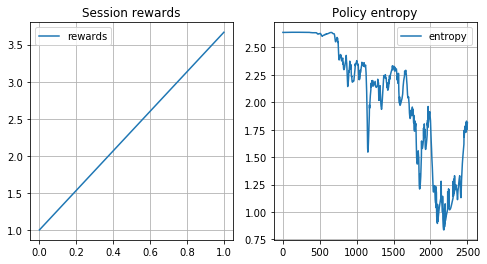

  3%|█▊                                                                       | 2501/100000 [06:18<93:03:12,  3.44s/it]

  3%|█▊                                                                       | 2502/100000 [06:19<66:05:42,  2.44s/it]

  3%|█▊                                                                       | 2503/100000 [06:19<47:25:37,  1.75s/it]

  3%|█▊                                                                       | 2504/100000 [06:19<34:20:07,  1.27s/it]

  3%|█▊                                                                       | 2505/100000 [06:19<25:09:18,  1.08it/s]

  3%|█▊                                                                       | 2506/100000 [06:19<18:44:42,  1.44it/s]

  3%|█▊                                                                       | 2507/100000 [06:19<14:15:29,  1.90it/s]

  3%|█▊                                                                       | 2508/100000 [06:19<11:08:59,  2.43it/s]

  3%|█▊                                                                        | 2509/100000 [06:20<8:58:26,  3.02it/s]

  3%|█▊                                                                        | 2510/100000 [06:20<7:19:45,  3.69it/s]

  3%|█▊                                                                        | 2511/100000 [06:20<6:23:20,  4.24it/s]

  3%|█▊                                                                        | 2512/100000 [06:20<5:34:35,  4.86it/s]

  3%|█▊                                                                        | 2513/100000 [06:20<5:00:27,  5.41it/s]

  3%|█▊                                                                        | 2514/100000 [06:20<4:47:17,  5.66it/s]

  3%|█▊                                                                        | 2515/100000 [06:20<4:32:42,  5.96it/s]

  3%|█▊                                                                        | 2516/100000 [06:21<4:24:56,  6.13it/s]

  3%|█▊                                                                        | 2517/100000 [06:21<4:11:42,  6.45it/s]

  3%|█▊                                                                        | 2518/100000 [06:21<4:12:40,  6.43it/s]

  3%|█▊                                                                        | 2519/100000 [06:21<4:06:31,  6.59it/s]

  3%|█▊                                                                        | 2520/100000 [06:21<4:02:42,  6.69it/s]

  3%|█▊                                                                        | 2521/100000 [06:21<4:01:59,  6.71it/s]

  3%|█▊                                                                        | 2522/100000 [06:21<4:00:30,  6.75it/s]

  3%|█▊                                                                        | 2523/100000 [06:22<4:01:25,  6.73it/s]

  3%|█▊                                                                        | 2524/100000 [06:22<3:57:11,  6.85it/s]

  3%|█▊                                                                        | 2525/100000 [06:22<3:55:11,  6.91it/s]

  3%|█▊                                                                        | 2526/100000 [06:22<3:55:15,  6.91it/s]

  3%|█▊                                                                        | 2527/100000 [06:22<3:56:46,  6.86it/s]

  3%|█▊                                                                        | 2528/100000 [06:22<3:53:55,  6.94it/s]

  3%|█▊                                                                        | 2529/100000 [06:22<3:49:01,  7.09it/s]

  3%|█▊                                                                        | 2530/100000 [06:23<3:48:00,  7.12it/s]

  3%|█▊                                                                        | 2531/100000 [06:23<3:47:18,  7.15it/s]

  3%|█▊                                                                        | 2532/100000 [06:23<3:48:45,  7.10it/s]

  3%|█▊                                                                        | 2533/100000 [06:23<3:50:16,  7.05it/s]

  3%|█▉                                                                        | 2534/100000 [06:23<3:49:51,  7.07it/s]

  3%|█▉                                                                        | 2535/100000 [06:23<3:49:34,  7.08it/s]

  3%|█▉                                                                        | 2536/100000 [06:23<3:49:51,  7.07it/s]

  3%|█▉                                                                        | 2537/100000 [06:24<3:56:23,  6.87it/s]

  3%|█▉                                                                        | 2538/100000 [06:24<3:54:37,  6.92it/s]

  3%|█▉                                                                        | 2539/100000 [06:24<3:53:23,  6.96it/s]

  3%|█▉                                                                        | 2540/100000 [06:24<3:50:35,  7.04it/s]

  3%|█▉                                                                        | 2541/100000 [06:24<3:44:13,  7.24it/s]

  3%|█▉                                                                        | 2542/100000 [06:24<3:47:34,  7.14it/s]

  3%|█▉                                                                        | 2543/100000 [06:24<3:48:27,  7.11it/s]

  3%|█▉                                                                        | 2544/100000 [06:25<3:58:48,  6.80it/s]

  3%|█▉                                                                        | 2545/100000 [06:25<3:52:54,  6.97it/s]

  3%|█▉                                                                        | 2546/100000 [06:25<3:47:19,  7.15it/s]

  3%|█▉                                                                        | 2547/100000 [06:25<3:53:37,  6.95it/s]

  3%|█▉                                                                        | 2548/100000 [06:25<3:53:39,  6.95it/s]

  3%|█▉                                                                        | 2549/100000 [06:25<3:50:45,  7.04it/s]

  3%|█▉                                                                        | 2550/100000 [06:25<3:53:07,  6.97it/s]

  3%|█▉                                                                        | 2551/100000 [06:26<3:48:55,  7.09it/s]

  3%|█▉                                                                        | 2552/100000 [06:26<3:53:17,  6.96it/s]

  3%|█▉                                                                        | 2553/100000 [06:26<3:59:15,  6.79it/s]

  3%|█▉                                                                        | 2554/100000 [06:26<3:56:08,  6.88it/s]

  3%|█▉                                                                        | 2555/100000 [06:26<3:49:34,  7.07it/s]

  3%|█▉                                                                        | 2556/100000 [06:26<3:49:21,  7.08it/s]

  3%|█▉                                                                        | 2557/100000 [06:26<3:51:38,  7.01it/s]

  3%|█▉                                                                        | 2558/100000 [06:27<3:50:48,  7.04it/s]

  3%|█▉                                                                        | 2559/100000 [06:27<3:47:47,  7.13it/s]

  3%|█▉                                                                        | 2560/100000 [06:27<3:46:38,  7.17it/s]

  3%|█▉                                                                        | 2561/100000 [06:27<3:51:11,  7.02it/s]

  3%|█▉                                                                        | 2562/100000 [06:27<3:47:04,  7.15it/s]

  3%|█▉                                                                        | 2563/100000 [06:27<3:44:41,  7.23it/s]

  3%|█▉                                                                        | 2564/100000 [06:27<3:40:05,  7.38it/s]

  3%|█▉                                                                        | 2565/100000 [06:28<3:36:52,  7.49it/s]

  3%|█▉                                                                        | 2566/100000 [06:28<3:35:35,  7.53it/s]

  3%|█▉                                                                        | 2567/100000 [06:28<3:41:30,  7.33it/s]

  3%|█▉                                                                        | 2568/100000 [06:28<3:42:14,  7.31it/s]

  3%|█▉                                                                        | 2569/100000 [06:28<3:47:08,  7.15it/s]

  3%|█▉                                                                        | 2570/100000 [06:28<3:45:12,  7.21it/s]

  3%|█▉                                                                        | 2571/100000 [06:28<3:45:48,  7.19it/s]

  3%|█▉                                                                        | 2572/100000 [06:28<3:47:11,  7.15it/s]

  3%|█▉                                                                        | 2573/100000 [06:29<3:44:45,  7.22it/s]

  3%|█▉                                                                        | 2574/100000 [06:29<3:42:34,  7.30it/s]

  3%|█▉                                                                        | 2575/100000 [06:29<3:41:02,  7.35it/s]

  3%|█▉                                                                        | 2576/100000 [06:29<3:40:26,  7.37it/s]

  3%|█▉                                                                        | 2577/100000 [06:29<3:40:01,  7.38it/s]

  3%|█▉                                                                        | 2578/100000 [06:29<3:37:47,  7.46it/s]

  3%|█▉                                                                        | 2579/100000 [06:29<3:40:36,  7.36it/s]

  3%|█▉                                                                        | 2580/100000 [06:30<3:45:30,  7.20it/s]

  3%|█▉                                                                        | 2581/100000 [06:30<3:42:35,  7.29it/s]

  3%|█▉                                                                        | 2582/100000 [06:30<3:43:28,  7.27it/s]

  3%|█▉                                                                        | 2583/100000 [06:30<3:47:01,  7.15it/s]

  3%|█▉                                                                        | 2584/100000 [06:30<3:47:33,  7.14it/s]

  3%|█▉                                                                        | 2585/100000 [06:30<3:46:56,  7.15it/s]

  3%|█▉                                                                        | 2586/100000 [06:30<3:48:57,  7.09it/s]

  3%|█▉                                                                        | 2587/100000 [06:31<3:48:54,  7.09it/s]

  3%|█▉                                                                        | 2588/100000 [06:31<3:47:24,  7.14it/s]

  3%|█▉                                                                        | 2589/100000 [06:31<3:47:20,  7.14it/s]

  3%|█▉                                                                        | 2590/100000 [06:31<3:49:42,  7.07it/s]

  3%|█▉                                                                        | 2591/100000 [06:31<3:52:21,  6.99it/s]

  3%|█▉                                                                        | 2592/100000 [06:31<3:58:34,  6.80it/s]

  3%|█▉                                                                        | 2593/100000 [06:31<4:02:27,  6.70it/s]

  3%|█▉                                                                        | 2594/100000 [06:32<4:05:09,  6.62it/s]

  3%|█▉                                                                        | 2595/100000 [06:32<4:12:53,  6.42it/s]

  3%|█▉                                                                        | 2596/100000 [06:32<4:11:29,  6.45it/s]

  3%|█▉                                                                        | 2597/100000 [06:32<4:08:05,  6.54it/s]

  3%|█▉                                                                        | 2598/100000 [06:32<4:04:13,  6.65it/s]

  3%|█▉                                                                        | 2599/100000 [06:32<4:02:30,  6.69it/s]

  3%|█▉                                                                        | 2600/100000 [06:32<3:58:22,  6.81it/s]

  3%|█▉                                                                        | 2601/100000 [06:33<3:56:28,  6.86it/s]

  3%|█▉                                                                        | 2602/100000 [06:33<3:54:38,  6.92it/s]

  3%|█▉                                                                        | 2603/100000 [06:33<3:50:26,  7.04it/s]

  3%|█▉                                                                        | 2604/100000 [06:33<3:52:21,  6.99it/s]

  3%|█▉                                                                        | 2605/100000 [06:33<3:52:44,  6.97it/s]

  3%|█▉                                                                        | 2606/100000 [06:33<3:52:01,  7.00it/s]

  3%|█▉                                                                        | 2607/100000 [06:33<3:52:29,  6.98it/s]

  3%|█▉                                                                        | 2608/100000 [06:34<3:50:52,  7.03it/s]

  3%|█▉                                                                        | 2609/100000 [06:34<3:45:51,  7.19it/s]

  3%|█▉                                                                        | 2610/100000 [06:34<3:45:44,  7.19it/s]

  3%|█▉                                                                        | 2611/100000 [06:34<3:49:33,  7.07it/s]

  3%|█▉                                                                        | 2612/100000 [06:34<3:50:16,  7.05it/s]

  3%|█▉                                                                        | 2613/100000 [06:34<3:44:56,  7.22it/s]

  3%|█▉                                                                        | 2614/100000 [06:34<3:48:59,  7.09it/s]

  3%|█▉                                                                        | 2615/100000 [06:35<3:47:27,  7.14it/s]

  3%|█▉                                                                        | 2616/100000 [06:35<3:47:20,  7.14it/s]

  3%|█▉                                                                        | 2617/100000 [06:35<3:46:17,  7.17it/s]

  3%|█▉                                                                        | 2618/100000 [06:35<3:47:30,  7.13it/s]

  3%|█▉                                                                        | 2619/100000 [06:35<3:47:22,  7.14it/s]

  3%|█▉                                                                        | 2620/100000 [06:35<3:48:15,  7.11it/s]

  3%|█▉                                                                        | 2621/100000 [06:35<3:49:51,  7.06it/s]

  3%|█▉                                                                        | 2622/100000 [06:36<3:48:32,  7.10it/s]

  3%|█▉                                                                        | 2623/100000 [06:36<3:47:36,  7.13it/s]

  3%|█▉                                                                        | 2624/100000 [06:36<3:48:54,  7.09it/s]

  3%|█▉                                                                        | 2625/100000 [06:36<3:48:50,  7.09it/s]

  3%|█▉                                                                        | 2626/100000 [06:36<3:52:12,  6.99it/s]

  3%|█▉                                                                        | 2627/100000 [06:36<3:55:02,  6.90it/s]

  3%|█▉                                                                        | 2628/100000 [06:36<4:02:22,  6.70it/s]

  3%|█▉                                                                        | 2629/100000 [06:37<4:05:05,  6.62it/s]

  3%|█▉                                                                        | 2630/100000 [06:37<4:08:24,  6.53it/s]

  3%|█▉                                                                        | 2631/100000 [06:37<4:12:13,  6.43it/s]

  3%|█▉                                                                        | 2632/100000 [06:37<4:15:22,  6.35it/s]

  3%|█▉                                                                        | 2633/100000 [06:37<4:18:04,  6.29it/s]

  3%|█▉                                                                        | 2634/100000 [06:37<4:31:08,  5.98it/s]

  3%|█▉                                                                        | 2635/100000 [06:38<4:34:56,  5.90it/s]

  3%|█▉                                                                        | 2636/100000 [06:38<4:29:19,  6.03it/s]

  3%|█▉                                                                        | 2637/100000 [06:38<4:39:01,  5.82it/s]

  3%|█▉                                                                        | 2638/100000 [06:38<4:46:32,  5.66it/s]

  3%|█▉                                                                        | 2639/100000 [06:38<4:46:41,  5.66it/s]

  3%|█▉                                                                        | 2640/100000 [06:38<4:39:30,  5.81it/s]

  3%|█▉                                                                        | 2641/100000 [06:39<4:31:03,  5.99it/s]

  3%|█▉                                                                        | 2642/100000 [06:39<4:18:31,  6.28it/s]

  3%|█▉                                                                        | 2643/100000 [06:39<4:15:24,  6.35it/s]

  3%|█▉                                                                        | 2644/100000 [06:39<4:03:58,  6.65it/s]

  3%|█▉                                                                        | 2645/100000 [06:39<3:58:24,  6.81it/s]

  3%|█▉                                                                        | 2646/100000 [06:39<3:54:59,  6.90it/s]

  3%|█▉                                                                        | 2647/100000 [06:39<3:51:08,  7.02it/s]

  3%|█▉                                                                        | 2648/100000 [06:40<4:07:25,  6.56it/s]

  3%|█▉                                                                        | 2649/100000 [06:40<4:22:12,  6.19it/s]

  3%|█▉                                                                        | 2650/100000 [06:40<4:12:08,  6.43it/s]

  3%|█▉                                                                        | 2651/100000 [06:40<4:20:39,  6.22it/s]

  3%|█▉                                                                        | 2652/100000 [06:40<4:22:14,  6.19it/s]

  3%|█▉                                                                        | 2653/100000 [06:40<4:23:49,  6.15it/s]

  3%|█▉                                                                        | 2654/100000 [06:41<4:23:28,  6.16it/s]

  3%|█▉                                                                        | 2655/100000 [06:41<4:13:59,  6.39it/s]

  3%|█▉                                                                        | 2656/100000 [06:41<4:19:01,  6.26it/s]

  3%|█▉                                                                        | 2657/100000 [06:41<4:09:25,  6.50it/s]

  3%|█▉                                                                        | 2658/100000 [06:41<4:04:09,  6.64it/s]

  3%|█▉                                                                        | 2659/100000 [06:41<4:05:19,  6.61it/s]

  3%|█▉                                                                        | 2660/100000 [06:42<4:13:26,  6.40it/s]

  3%|█▉                                                                        | 2661/100000 [06:42<4:07:56,  6.54it/s]

  3%|█▉                                                                        | 2662/100000 [06:42<4:09:26,  6.50it/s]

  3%|█▉                                                                        | 2663/100000 [06:42<4:02:12,  6.70it/s]

  3%|█▉                                                                        | 2664/100000 [06:42<3:58:07,  6.81it/s]

  3%|█▉                                                                        | 2665/100000 [06:42<4:02:04,  6.70it/s]

  3%|█▉                                                                        | 2666/100000 [06:42<4:00:57,  6.73it/s]

  3%|█▉                                                                        | 2667/100000 [06:43<4:01:37,  6.71it/s]

  3%|█▉                                                                        | 2668/100000 [06:43<3:53:49,  6.94it/s]

  3%|█▉                                                                        | 2669/100000 [06:43<3:59:03,  6.79it/s]

  3%|█▉                                                                        | 2670/100000 [06:43<3:58:21,  6.81it/s]

  3%|█▉                                                                        | 2671/100000 [06:43<3:56:52,  6.85it/s]

  3%|█▉                                                                        | 2672/100000 [06:43<3:52:56,  6.96it/s]

  3%|█▉                                                                        | 2673/100000 [06:43<3:49:40,  7.06it/s]

  3%|█▉                                                                        | 2674/100000 [06:44<3:51:46,  7.00it/s]

  3%|█▉                                                                        | 2675/100000 [06:44<3:54:13,  6.93it/s]

  3%|█▉                                                                        | 2676/100000 [06:44<3:49:07,  7.08it/s]

  3%|█▉                                                                        | 2677/100000 [06:44<3:49:26,  7.07it/s]

  3%|█▉                                                                        | 2678/100000 [06:44<3:50:09,  7.05it/s]

  3%|█▉                                                                        | 2679/100000 [06:44<3:48:42,  7.09it/s]

  3%|█▉                                                                        | 2680/100000 [06:44<3:46:13,  7.17it/s]

  3%|█▉                                                                        | 2681/100000 [06:45<3:52:16,  6.98it/s]

  3%|█▉                                                                        | 2682/100000 [06:45<3:51:09,  7.02it/s]

  3%|█▉                                                                        | 2683/100000 [06:45<3:49:24,  7.07it/s]

  3%|█▉                                                                        | 2684/100000 [06:45<3:46:43,  7.15it/s]

  3%|█▉                                                                        | 2685/100000 [06:45<3:46:47,  7.15it/s]

  3%|█▉                                                                        | 2686/100000 [06:45<3:47:18,  7.14it/s]

  3%|█▉                                                                        | 2687/100000 [06:45<3:45:44,  7.18it/s]

  3%|█▉                                                                        | 2688/100000 [06:46<3:44:09,  7.24it/s]

  3%|█▉                                                                        | 2689/100000 [06:46<3:43:31,  7.26it/s]

  3%|█▉                                                                        | 2690/100000 [06:46<3:45:01,  7.21it/s]

  3%|█▉                                                                        | 2691/100000 [06:46<3:45:35,  7.19it/s]

  3%|█▉                                                                        | 2692/100000 [06:46<3:43:04,  7.27it/s]

  3%|█▉                                                                        | 2693/100000 [06:46<3:43:15,  7.26it/s]

  3%|█▉                                                                        | 2694/100000 [06:46<3:43:51,  7.24it/s]

  3%|█▉                                                                        | 2695/100000 [06:47<3:42:20,  7.29it/s]

  3%|█▉                                                                        | 2696/100000 [06:47<3:45:39,  7.19it/s]

  3%|█▉                                                                        | 2697/100000 [06:47<3:41:10,  7.33it/s]

  3%|█▉                                                                        | 2698/100000 [06:47<3:39:29,  7.39it/s]

  3%|█▉                                                                        | 2699/100000 [06:47<3:43:39,  7.25it/s]

  3%|█▉                                                                        | 2700/100000 [06:47<3:46:05,  7.17it/s]

  3%|█▉                                                                        | 2701/100000 [06:47<3:48:16,  7.10it/s]

  3%|█▉                                                                        | 2702/100000 [06:48<3:46:24,  7.16it/s]

  3%|██                                                                        | 2703/100000 [06:48<3:46:03,  7.17it/s]

  3%|██                                                                        | 2704/100000 [06:48<3:44:51,  7.21it/s]

  3%|██                                                                        | 2705/100000 [06:48<3:44:29,  7.22it/s]

  3%|██                                                                        | 2706/100000 [06:48<3:38:24,  7.42it/s]

  3%|██                                                                        | 2707/100000 [06:48<3:39:58,  7.37it/s]

  3%|██                                                                        | 2708/100000 [06:48<3:41:04,  7.33it/s]

  3%|██                                                                        | 2709/100000 [06:48<3:51:33,  7.00it/s]

  3%|██                                                                        | 2710/100000 [06:49<3:48:12,  7.11it/s]

  3%|██                                                                        | 2711/100000 [06:49<3:47:19,  7.13it/s]

  3%|██                                                                        | 2712/100000 [06:49<3:46:42,  7.15it/s]

  3%|██                                                                        | 2713/100000 [06:49<3:46:15,  7.17it/s]

  3%|██                                                                        | 2714/100000 [06:49<3:54:42,  6.91it/s]

  3%|██                                                                        | 2715/100000 [06:49<3:50:24,  7.04it/s]

  3%|██                                                                        | 2716/100000 [06:49<3:58:05,  6.81it/s]

  3%|██                                                                        | 2717/100000 [06:50<4:03:57,  6.65it/s]

  3%|██                                                                        | 2718/100000 [06:50<4:02:13,  6.69it/s]

  3%|██                                                                        | 2719/100000 [06:50<3:58:06,  6.81it/s]

  3%|██                                                                        | 2720/100000 [06:50<4:00:33,  6.74it/s]

  3%|██                                                                        | 2721/100000 [06:50<3:57:25,  6.83it/s]

  3%|██                                                                        | 2722/100000 [06:50<3:54:14,  6.92it/s]

  3%|██                                                                        | 2723/100000 [06:51<3:52:59,  6.96it/s]

  3%|██                                                                        | 2724/100000 [06:51<3:50:39,  7.03it/s]

  3%|██                                                                        | 2725/100000 [06:51<3:52:55,  6.96it/s]

  3%|██                                                                        | 2726/100000 [06:51<3:49:38,  7.06it/s]

  3%|██                                                                        | 2727/100000 [06:51<3:45:23,  7.19it/s]

  3%|██                                                                        | 2728/100000 [06:51<3:44:22,  7.23it/s]

  3%|██                                                                        | 2729/100000 [06:51<3:40:43,  7.34it/s]

  3%|██                                                                        | 2730/100000 [06:51<3:40:07,  7.36it/s]

  3%|██                                                                        | 2731/100000 [06:52<3:42:08,  7.30it/s]

KeyboardInterrupt: 

In [17]:
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)
n_lives = 3
for i in trange(100000): 
    
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    

    batch_states = batch_next_states
    loss, ent_t = compute_loss(batch_states, batch_actions, batch_rewards, batch_next_states, batch_done,
                       agent, device=device)
    loss.backward()
    # grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad() 
    entropy_history.append(np.mean(ent_t.data.cpu().numpy()))

    if i % 500 == 0: 
        if i % 2500 == 0:
            rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
            if rewards_history[-1] >= 50:
                print("Your agent has earned the yellow belt" % color)

        clear_output(True)
        plt.figure(figsize=[8,4])
        plt.subplot(1, 2, 1)
        plt.plot(rewards_history, label='rewards')
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.show()
        
        



Relax and grab some refreshments while your agent is locked in an infinite loop of violence and death.

__How to interpret plots:__

The session reward is the easy thing: it should in general go up over time, but it's okay if it fluctuates ~~like crazy~~. It's also OK if it reward doesn't increase substantially before some 10k initial steps. However, if reward reaches zero and doesn't seem to get up over 2-3 evaluations, there's something wrong happening.


Since we use a policy-based method, we also keep track of __policy entropy__ - the same one you used as a regularizer. The only important thing about it is that your entropy shouldn't drop too low (`< 0.1`) before your agent gets the yellow belt. Or at least it can drop there, but _it shouldn't stay there for long_.

If it does, the culprit is likely:
* Some bug in entropy computation. Remember that it is $ - \sum p(a_i) \cdot log p(a_i) $
* Your agent architecture converges too fast. Increase entropy coefficient in actor loss. 
* Gradient explosion - just [clip gradients](https://stackoverflow.com/a/43486487) and maybe use a smaller network
* Us. Or TF developers. Or aliens. Or lizardfolk. Contact us on forums before it's too late!

If you're debugging, just run `logits, values = agent.step(batch_states)` and manually look into logits and values. This will reveal the problem 9 times out of 10: you'll likely see some NaNs or insanely large numbers or zeros. Try to catch the moment when this happens for the first time and investigate from there.

In [30]:
rewards_history

[1.0]

### "Final" evaluation

In [ ]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=20,)
env_monitor.close()
print("Final mean reward:", np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

In [ ]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1])) 

In [ ]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-2])) #try other indices 

In [ ]:
# if you don't see videos, just navigate to ./kungfu_videos and download .mp4 files from there.

```

```
```

```
```

```
```

```
```

```
```

```
```

```
```

```


### Now what?
Well, 5k reward is [just the beginning](https://www.buzzfeed.com/mattjayyoung/what-the-color-of-your-karate-belt-actually-means-lg3g). Can you get past 200? With recurrent neural network memory, chances are you can even beat 400!